In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from tqdm.notebook import tqdm
from sklearn.utils import shuffle
import time

from sklearn.datasets import load_iris
from sklearn.cluster import KMeans
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.cluster import kmeans_plusplus
from sklearn.datasets import make_moons, make_circles
from contrastive_datasets import *
from contrastive_models import *
device = 'cpu' if torch.backends.mps.is_available() else 'cpu'
EMBED = 1
BATCH = 200
EPOCHS = 100
N_CLUST = 2
N_TENS = 4
METHOD = ''


/Users/omardebouni/miniconda3/envs/pytorch/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/omardebouni/miniconda3/envs/pytorch/lib/python3.9/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <2D1B8D5C-7891-3680-9CF9-F771AE880676> /Users/omardebouni/miniconda3/envs/pytorch/lib/python3.9/site-packages/torchvision/image.so
  Expected in:     <657200D0-E150-3B86-A0C5-7FD4B7F7C533> /Users/omardebouni/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [2]:
moon_triplet_dataset, moon_X, moon_Y= contrastive_data_loader(generator='many', dataset='moons',
                                                                 class_labels_list=[n for n in range(2)],
                                                                 num_samples=BATCH, num_aug=1,
                                                                 isImg=False,
                                                                 n_pos=50,n_neg=50,
                                                                 noise_level=0.1)
moon_triplet_loader = DataLoader(moon_triplet_dataset, batch_size=BATCH, shuffle=True)
####################################################################################################################################
circles_triplet_dataset, circles_X, circles_Y= contrastive_data_loader(generator='many',dataset='circles',
                                                                 class_labels_list=[n for n in range(12)],
                                                                 num_samples=600, num_aug=1,
                                                                 isImg=False,
                                                                 n_pos=10,n_neg=10,
                                                                 noise_level=0.01)
circles_triplet_loader = DataLoader(circles_triplet_dataset, batch_size=600, shuffle=True)
####################################################################################################################################
mnist_triplet_dataset, mnist_X, mnist_Y= contrastive_data_loader(generator='many',dataset='mnist',
                                                                 class_labels_list=[n for n in range(3)],
                                                                 num_samples=BATCH, num_aug=1,
                                                                 isImg=True,
                                                                 n_pos=100,n_neg=100,
                                                                 noise_level=0.1)
mnist_triplet_loader = DataLoader(mnist_triplet_dataset, batch_size=BATCH, shuffle=True)
####################################################################################################################################
sphere_triplet_dataset, sphere_X, sphere_Y= contrastive_data_loader(generator='many',dataset='sphere',
                                                                    class_labels_list=[n for n in range(2)],
                                                                    num_samples=BATCH, num_aug=1,
                                                                    isImg=False,
                                                                    n_pos=50,n_neg=50,
                                                                    noise_level=0.1)
sphere_triplet_loader = DataLoader(sphere_triplet_dataset, batch_size=BATCH, shuffle=True)

MNIST loaded dataset Dataset MNIST
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
           )


number of batches 1
batch of anchors: torch.Size([200, 2])
batch of positives: torch.Size([200, 50, 2])
batch of negative: torch.Size([200, 50, 2])
number of batches 1
batch of anchors: torch.Size([600, 2])
batch of positives: torch.Size([600, 10, 2])
batch of negative: torch.Size([600, 10, 2])
number of batches 1
batch of anchors: torch.Size([200, 784])
batch of positives: torch.Size([200, 100, 784])
batch of negative: torch.Size([200, 100, 784])
number of batches 1
batch of anchors: torch.Size([200, 3])
batch of positives: torch.Size([200, 50, 3])
batch of negative: torch.Size([200, 50, 3])


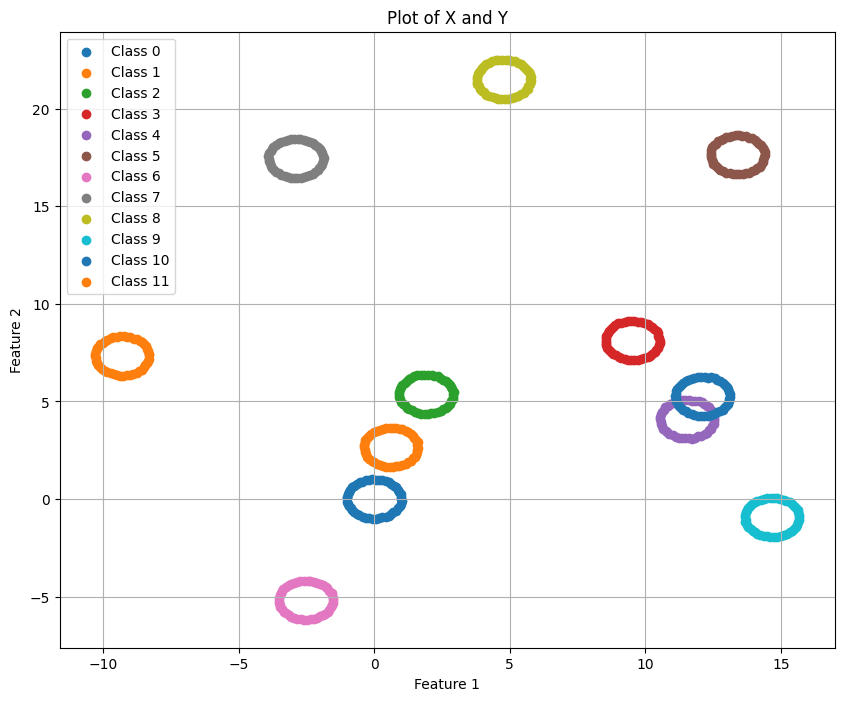

In [3]:
print("number of batches", len(moon_triplet_loader))
for batch in moon_triplet_loader:
    print("batch of anchors:", batch[0].shape)
    print("batch of positives:", batch[1].shape)
    print("batch of negative:", batch[2].shape)
    break

print("number of batches", len(circles_triplet_loader))
for batch in circles_triplet_loader:
    print("batch of anchors:", batch[0].shape)
    print("batch of positives:", batch[1].shape)
    print("batch of negative:", batch[2].shape)
    break
print("number of batches", len(mnist_triplet_loader))
for batch in mnist_triplet_loader:
    print("batch of anchors:", batch[0].shape)
    print("batch of positives:", batch[1].shape)
    print("batch of negative:", batch[2].shape)
    break
print("number of batches", len(sphere_triplet_loader))
for batch in sphere_triplet_loader:
    print("batch of anchors:", batch[0].shape)
    print("batch of positives:", batch[1].shape)
    print("batch of negative:", batch[2].shape)
    break
X_np = circles_X.numpy()
Y_np = circles_Y.numpy()

plt.figure(figsize=(10, 8))
# We'll go through each class and plot it with a unique color
unique_classes = np.unique(Y_np)
for class_label in unique_classes:
    # Select indices of the current class for plotting
    idx = Y_np == class_label
    plt.scatter(X_np[idx, 0], X_np[idx, 1], label=f"Class {class_label}")

plt.title("Plot of X and Y")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.grid(True)
plt.show()

In [4]:
non_moon_triplet_dataset, non_moon_X, non_moon_Y= contrastive_data_loader(generator='many', contra=False, dataset='moons',
                                                                 class_labels_list=[n for n in range(2)],
                                                                 num_samples=BATCH, num_aug=1,
                                                                 isImg=False,
                                                                 n_pos=50,
                                                                 noise_level=0.1)
non_moon_triplet_loader = DataLoader(non_moon_triplet_dataset, batch_size=BATCH, shuffle=True)
####################################################################################################################################

non_circle_triplet_dataset, non_circle_X, non_circle_Y= contrastive_data_loader(generator='many',contra=False,dataset='circles',
                                                                 class_labels_list=[n for n in range(12)],
                                                                 num_samples=600, num_aug=1,
                                                                 isImg=False,
                                                                 n_pos=10,
                                                                 noise_level=0.01)
non_circle_triplet_loader = DataLoader(non_circle_triplet_dataset, batch_size=600, shuffle=True)
####################################################################################################################################

non_mnist_triplet_dataset, non_mnist_X, non_mnist_Y= contrastive_data_loader(generator='many',contra=False,dataset='mnist',
                                                                 class_labels_list=[n for n in range(3)],
                                                                 num_samples=200, num_aug=1,
                                                                 isImg=True,
                                                                 n_pos=100,
                                                                 noise_level=0.1)
non_mnist_triplet_loader = DataLoader(non_mnist_triplet_dataset, batch_size=200, shuffle=True)
####################################################################################################################################

non_sphere_triplet_dataset, non_sphere_X, non_sphere_Y= contrastive_data_loader(generator='many',contra=False,dataset='sphere',
                                                                    class_labels_list=[n for n in range(2)],
                                                                    num_samples=BATCH, num_aug=1,
                                                                    isImg=False,
                                                                    n_pos=50,
                                                                    noise_level=0.1)
non_sphere_triplet_loader = DataLoader(non_sphere_triplet_dataset, batch_size=BATCH, shuffle=True)

MNIST loaded dataset Dataset MNIST
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
           )


In [5]:
datasets = {
    'moons': {'loader': moon_triplet_loader, 'X': moon_X, 'Y': moon_Y, 'n_clusters': 2, 'epochs': 30, 'embed': 1, 'method': '', 'batch': BATCH},
    'circles': {'loader': circles_triplet_loader, 'X': circles_X, 'Y': circles_Y, 'n_clusters': 12, 'epochs': 100, 'embed': 1, 'method': '', 'batch': 600},
    'mnist': {'loader': mnist_triplet_loader, 'X': mnist_X, 'Y': mnist_Y, 'n_clusters': 3, 'epochs': 50, 'embed': 10, 'method': '', 'batch': BATCH},
    'spheres': {'loader': sphere_triplet_loader, 'X': sphere_X, 'Y': sphere_Y, 'n_clusters': 2, 'epochs': 50, 'embed': 1, 'method': '', 'batch': BATCH}
}

versions = ['KMeans', 'CAE', 'Tensor']
results = {dataset: {version: [] for version in versions} for dataset in datasets}

n_runs = 10
# (dataset_loader, X, Y, method, n_clusters,n_tensors,epochs, batch_size, embed, lr):
for dataset_name, dataset_info in datasets.items():
    for version in versions:
        for _ in range(n_runs):
            ari_score = run_experiment(dataset_info['loader'], dataset_info['X'], dataset_info['Y'], 
                                       method='', n_clusters=dataset_info['n_clusters'], n_tensors=dataset_info['n_clusters'],
                                       epochs=dataset_info['epochs'], batch_size=dataset_info['batch'], embed= dataset_info['embed'], lr=0.1, model='contrastive', version=version)
            results[dataset_name][version].append(ari_score)

# This loop will populate the `results` dictionary with ARI scores for each method across each dataset.


Training Epochs:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 1/30:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  1  loss  -0.5760257244110107


Epoch 2/30:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  2  loss  -0.7436320781707764


Epoch 3/30:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  3  loss  -0.9329310059547424


Epoch 4/30:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  4  loss  -1.1364341974258423


Epoch 5/30:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  5  loss  -1.4350707530975342


Epoch 6/30:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  6  loss  -1.6614265441894531


Epoch 7/30:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  7  loss  -1.967768907546997


Epoch 8/30:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  8  loss  -2.34525203704834


Epoch 9/30:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  9  loss  -2.676398277282715


Epoch 10/30:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  10  loss  -3.048092842102051


Epoch 11/30:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  11  loss  -3.553452730178833


Epoch 12/30:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  12  loss  -3.9362246990203857


Epoch 13/30:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  13  loss  -4.540166854858398


Epoch 14/30:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  14  loss  -5.051848888397217


Epoch 15/30:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  15  loss  -5.607868194580078


Epoch 16/30:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  16  loss  -6.14956521987915


Epoch 17/30:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  17  loss  -6.871264457702637


Epoch 18/30:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  18  loss  -7.483171463012695


Epoch 19/30:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  19  loss  -8.246184349060059


Epoch 20/30:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  20  loss  -9.142142295837402


Epoch 21/30:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  21  loss  -9.953993797302246


Epoch 22/30:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  22  loss  -10.67273235321045


Epoch 23/30:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  23  loss  -11.816200256347656


Epoch 24/30:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  24  loss  -12.719621658325195


Epoch 25/30:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  25  loss  -13.4769287109375


Epoch 26/30:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  26  loss  -14.633209228515625


Epoch 27/30:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  27  loss  -15.809618949890137


Epoch 28/30:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  28  loss  -16.747894287109375


Epoch 29/30:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  29  loss  -17.928979873657227


Epoch 30/30:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  30  loss  -19.248668670654297


/Users/omardebouni/miniconda3/envs/pytorch/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Training Epochs:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 1/30:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  1  loss  -0.2114022821187973


Epoch 2/30:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  2  loss  -0.284172385931015


Epoch 3/30:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  3  loss  -0.3906148076057434


Epoch 4/30:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  4  loss  -0.5232672691345215


Epoch 5/30:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  5  loss  -0.6972503662109375


Epoch 6/30:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  6  loss  -0.8794243335723877


Epoch 7/30:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  7  loss  -1.1163074970245361


Epoch 8/30:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  8  loss  -1.32192063331604


Epoch 9/30:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  9  loss  -1.6299198865890503


Epoch 10/30:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  10  loss  -1.918428659439087


Epoch 11/30:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  11  loss  -2.25815486907959


Epoch 12/30:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  12  loss  -2.6639280319213867


Epoch 13/30:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  13  loss  -3.075352191925049


Epoch 14/30:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  14  loss  -3.4804632663726807


Epoch 15/30:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  15  loss  -3.937776803970337


Epoch 16/30:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  16  loss  -4.402925968170166


Epoch 17/30:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  17  loss  -4.984226226806641


Epoch 18/30:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  18  loss  -5.617712497711182


Epoch 19/30:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  19  loss  -6.2830424308776855


Epoch 20/30:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  20  loss  -6.7561140060424805


Epoch 21/30:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  21  loss  -7.791258335113525


Epoch 22/30:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  22  loss  -8.348620414733887


Epoch 23/30:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  23  loss  -9.126208305358887


Epoch 24/30:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  24  loss  -10.113319396972656


Epoch 25/30:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  25  loss  -11.056670188903809


Epoch 26/30:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  26  loss  -11.976849555969238


Epoch 27/30:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  27  loss  -12.865966796875


Epoch 28/30:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  28  loss  -14.19764518737793


Epoch 29/30:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  29  loss  -15.113836288452148


Epoch 30/30:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  30  loss  -16.23395538330078


/Users/omardebouni/miniconda3/envs/pytorch/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Training Epochs:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 1/30:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  1  loss  -0.5687768459320068


Epoch 2/30:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  2  loss  -0.7412787675857544


Epoch 3/30:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  3  loss  -0.97635817527771


Epoch 4/30:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  4  loss  -1.2134766578674316


Epoch 5/30:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  5  loss  -1.4942233562469482


Epoch 6/30:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  6  loss  -1.741235375404358


Epoch 7/30:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  7  loss  -2.104810953140259


Epoch 8/30:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  8  loss  -2.435091257095337


Epoch 9/30:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  9  loss  -2.886916399002075


Epoch 10/30:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  10  loss  -3.302971124649048


Epoch 11/30:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  11  loss  -3.8126327991485596


Epoch 12/30:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  12  loss  -4.2567362785339355


Epoch 13/30:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  13  loss  -4.880776405334473


Epoch 14/30:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  14  loss  -5.336766242980957


Epoch 15/30:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  15  loss  -5.934170722961426


Epoch 16/30:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  16  loss  -6.662755966186523


Epoch 17/30:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  17  loss  -7.271263599395752


Epoch 18/30:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  18  loss  -8.200572967529297


Epoch 19/30:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  19  loss  -8.844673156738281


Epoch 20/30:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  20  loss  -9.750036239624023


Epoch 21/30:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  21  loss  -10.521145820617676


Epoch 22/30:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  22  loss  -11.098087310791016


Epoch 23/30:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  23  loss  -12.472225189208984


Epoch 24/30:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  24  loss  -13.040855407714844


Epoch 25/30:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  25  loss  -14.303977012634277


Epoch 26/30:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  26  loss  -15.283447265625


Epoch 27/30:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  27  loss  -16.839813232421875


Epoch 28/30:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  28  loss  -17.465721130371094


Epoch 29/30:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  29  loss  -18.9055233001709


Epoch 30/30:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  30  loss  -19.92835235595703


/Users/omardebouni/miniconda3/envs/pytorch/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Training Epochs:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 1/30:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  1  loss  -0.22281116247177124


Epoch 2/30:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  2  loss  -0.28818535804748535


Epoch 3/30:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  3  loss  -0.3713148534297943


Epoch 4/30:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  4  loss  -0.4848702549934387


Epoch 5/30:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  5  loss  -0.5862476229667664


Epoch 6/30:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  6  loss  -0.7036548852920532


Epoch 7/30:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  7  loss  -0.8260427117347717


Epoch 8/30:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  8  loss  -1.051596760749817


Epoch 9/30:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  9  loss  -1.1593437194824219


Epoch 10/30:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  10  loss  -1.3507335186004639


Epoch 11/30:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  11  loss  -1.5347132682800293


Epoch 12/30:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  12  loss  -1.7101714611053467


Epoch 13/30:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  13  loss  -1.9393714666366577


Epoch 14/30:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  14  loss  -2.2064263820648193


Epoch 15/30:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  15  loss  -2.490187406539917


Epoch 16/30:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  16  loss  -2.699918746948242


Epoch 17/30:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  17  loss  -3.026038885116577


Epoch 18/30:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  18  loss  -3.4370360374450684


Epoch 19/30:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  19  loss  -3.754209041595459


Epoch 20/30:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  20  loss  -3.952981948852539


Epoch 21/30:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  21  loss  -4.3557047843933105


Epoch 22/30:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  22  loss  -4.7491536140441895


Epoch 23/30:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  23  loss  -5.188126087188721


Epoch 24/30:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  24  loss  -5.63532829284668


Epoch 25/30:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  25  loss  -6.071186542510986


Epoch 26/30:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  26  loss  -6.436530113220215


Epoch 27/30:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  27  loss  -6.744899749755859


Epoch 28/30:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  28  loss  -7.386742115020752


Epoch 29/30:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  29  loss  -8.085500717163086


Epoch 30/30:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  30  loss  -8.551878929138184


/Users/omardebouni/miniconda3/envs/pytorch/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Training Epochs:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 1/30:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  1  loss  -0.21030491590499878


Epoch 2/30:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  2  loss  -0.29505378007888794


Epoch 3/30:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  3  loss  -0.3987591862678528


Epoch 4/30:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  4  loss  -0.5296496748924255


Epoch 5/30:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  5  loss  -0.6925737261772156


Epoch 6/30:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  6  loss  -0.883608341217041


Epoch 7/30:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  7  loss  -1.0974364280700684


Epoch 8/30:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  8  loss  -1.3294507265090942


Epoch 9/30:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  9  loss  -1.6475297212600708


Epoch 10/30:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  10  loss  -1.9111299514770508


Epoch 11/30:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  11  loss  -2.2568278312683105


Epoch 12/30:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  12  loss  -2.6011600494384766


Epoch 13/30:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  13  loss  -3.09562349319458


Epoch 14/30:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  14  loss  -3.498940944671631


Epoch 15/30:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  15  loss  -4.0000104904174805


Epoch 16/30:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  16  loss  -4.476095199584961


Epoch 17/30:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  17  loss  -5.176241874694824


Epoch 18/30:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  18  loss  -5.663595676422119


Epoch 19/30:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  19  loss  -6.23182487487793


Epoch 20/30:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  20  loss  -7.1095781326293945


Epoch 21/30:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  21  loss  -7.524587631225586


Epoch 22/30:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  22  loss  -8.558818817138672


Epoch 23/30:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  23  loss  -9.2086763381958


Epoch 24/30:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  24  loss  -10.113636016845703


Epoch 25/30:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  25  loss  -10.873369216918945


Epoch 26/30:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  26  loss  -11.917593002319336


Epoch 27/30:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  27  loss  -13.079636573791504


Epoch 28/30:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  28  loss  -14.049586296081543


Epoch 29/30:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  29  loss  -14.992897987365723


Epoch 30/30:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  30  loss  -16.367271423339844


/Users/omardebouni/miniconda3/envs/pytorch/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Training Epochs:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 1/30:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  1  loss  -0.22926922142505646


Epoch 2/30:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  2  loss  -0.30876004695892334


Epoch 3/30:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  3  loss  -0.41442108154296875


Epoch 4/30:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  4  loss  -0.5053523778915405


Epoch 5/30:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  5  loss  -0.6455686688423157


Epoch 6/30:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  6  loss  -0.7514879107475281


Epoch 7/30:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  7  loss  -0.8999966382980347


Epoch 8/30:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  8  loss  -1.0459909439086914


Epoch 9/30:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  9  loss  -1.2326972484588623


Epoch 10/30:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  10  loss  -1.3962918519973755


Epoch 11/30:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  11  loss  -1.6401488780975342


Epoch 12/30:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  12  loss  -1.8541297912597656


Epoch 13/30:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  13  loss  -2.0851829051971436


Epoch 14/30:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  14  loss  -2.275449275970459


Epoch 15/30:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  15  loss  -2.555492639541626


Epoch 16/30:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  16  loss  -2.8826119899749756


Epoch 17/30:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  17  loss  -3.1819276809692383


Epoch 18/30:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  18  loss  -3.4870758056640625


Epoch 19/30:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  19  loss  -3.811734914779663


Epoch 20/30:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  20  loss  -4.12650728225708


Epoch 21/30:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  21  loss  -4.617746353149414


Epoch 22/30:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  22  loss  -5.0741658210754395


Epoch 23/30:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  23  loss  -5.417221546173096


Epoch 24/30:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  24  loss  -5.675961494445801


Epoch 25/30:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  25  loss  -6.3716044425964355


Epoch 26/30:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  26  loss  -6.73213005065918


Epoch 27/30:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  27  loss  -7.223834991455078


Epoch 28/30:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  28  loss  -7.705849647521973


Epoch 29/30:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  29  loss  -8.392426490783691


Epoch 30/30:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  30  loss  -8.7128324508667


/Users/omardebouni/miniconda3/envs/pytorch/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Training Epochs:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 1/30:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  1  loss  -0.4027591645717621


Epoch 2/30:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  2  loss  -0.5282798409461975


Epoch 3/30:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  3  loss  -0.6635183691978455


Epoch 4/30:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  4  loss  -0.8292341828346252


Epoch 5/30:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  5  loss  -1.0266518592834473


Epoch 6/30:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  6  loss  -1.2365573644638062


Epoch 7/30:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  7  loss  -1.472379207611084


Epoch 8/30:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  8  loss  -1.7700402736663818


Epoch 9/30:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  9  loss  -2.0853259563446045


Epoch 10/30:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  10  loss  -2.446085214614868


Epoch 11/30:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  11  loss  -2.8052639961242676


Epoch 12/30:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  12  loss  -3.1641929149627686


Epoch 13/30:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  13  loss  -3.6106672286987305


Epoch 14/30:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  14  loss  -4.1249494552612305


Epoch 15/30:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  15  loss  -4.683855056762695


Epoch 16/30:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  16  loss  -5.143226146697998


Epoch 17/30:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  17  loss  -5.907027721405029


Epoch 18/30:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  18  loss  -6.520681381225586


Epoch 19/30:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  19  loss  -7.224772930145264


Epoch 20/30:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  20  loss  -7.873683929443359


Epoch 21/30:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  21  loss  -8.667201042175293


Epoch 22/30:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  22  loss  -9.498374938964844


Epoch 23/30:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  23  loss  -10.103261947631836


Epoch 24/30:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  24  loss  -11.180655479431152


Epoch 25/30:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  25  loss  -12.033361434936523


Epoch 26/30:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  26  loss  -13.230011940002441


Epoch 27/30:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  27  loss  -14.085688591003418


Epoch 28/30:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  28  loss  -15.127437591552734


Epoch 29/30:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  29  loss  -16.5124454498291


Epoch 30/30:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  30  loss  -17.429670333862305


/Users/omardebouni/miniconda3/envs/pytorch/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Training Epochs:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 1/30:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  1  loss  -0.2568150758743286


Epoch 2/30:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  2  loss  -0.3209109604358673


Epoch 3/30:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  3  loss  -0.4321083724498749


Epoch 4/30:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  4  loss  -0.5368722677230835


Epoch 5/30:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  5  loss  -0.6316267848014832


Epoch 6/30:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  6  loss  -0.7984017133712769


Epoch 7/30:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  7  loss  -0.9374010562896729


Epoch 8/30:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  8  loss  -1.0964640378952026


Epoch 9/30:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  9  loss  -1.3025356531143188


Epoch 10/30:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  10  loss  -1.4651849269866943


Epoch 11/30:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  11  loss  -1.6373018026351929


Epoch 12/30:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  12  loss  -1.9052249193191528


Epoch 13/30:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  13  loss  -2.1491901874542236


Epoch 14/30:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  14  loss  -2.359755754470825


Epoch 15/30:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  15  loss  -2.64523983001709


Epoch 16/30:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  16  loss  -2.9801108837127686


Epoch 17/30:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  17  loss  -3.240701198577881


Epoch 18/30:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  18  loss  -3.498459577560425


Epoch 19/30:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  19  loss  -3.9588122367858887


Epoch 20/30:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  20  loss  -4.175553321838379


Epoch 21/30:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  21  loss  -4.680226802825928


Epoch 22/30:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  22  loss  -4.983587265014648


Epoch 23/30:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  23  loss  -5.459831714630127


Epoch 24/30:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  24  loss  -6.108297824859619


Epoch 25/30:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  25  loss  -6.242286205291748


Epoch 26/30:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  26  loss  -6.659831523895264


Epoch 27/30:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  27  loss  -7.078094482421875


Epoch 28/30:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  28  loss  -7.901591777801514


Epoch 29/30:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  29  loss  -8.150617599487305


Epoch 30/30:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  30  loss  -9.02663516998291


/Users/omardebouni/miniconda3/envs/pytorch/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Training Epochs:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 1/30:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  1  loss  -0.4291975796222687


Epoch 2/30:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  2  loss  -0.5727009177207947


Epoch 3/30:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  3  loss  -0.760958194732666


Epoch 4/30:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  4  loss  -0.992595374584198


Epoch 5/30:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  5  loss  -1.1971570253372192


Epoch 6/30:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  6  loss  -1.4894846677780151


Epoch 7/30:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  7  loss  -1.7551181316375732


Epoch 8/30:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  8  loss  -2.1580052375793457


Epoch 9/30:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  9  loss  -2.4779510498046875


Epoch 10/30:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  10  loss  -2.877960443496704


Epoch 11/30:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  11  loss  -3.355959177017212


Epoch 12/30:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  12  loss  -3.852332830429077


Epoch 13/30:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  13  loss  -4.259764194488525


Epoch 14/30:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  14  loss  -4.9019455909729


Epoch 15/30:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  15  loss  -5.398749351501465


Epoch 16/30:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  16  loss  -6.101946830749512


Epoch 17/30:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  17  loss  -6.753322601318359


Epoch 18/30:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  18  loss  -7.384059906005859


Epoch 19/30:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  19  loss  -8.080243110656738


Epoch 20/30:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  20  loss  -8.700703620910645


Epoch 21/30:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  21  loss  -9.792232513427734


Epoch 22/30:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  22  loss  -10.472735404968262


Epoch 23/30:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  23  loss  -11.219388008117676


Epoch 24/30:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  24  loss  -12.454179763793945


Epoch 25/30:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  25  loss  -13.242226600646973


Epoch 26/30:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  26  loss  -14.4667329788208


Epoch 27/30:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  27  loss  -15.423687934875488


Epoch 28/30:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  28  loss  -16.413986206054688


Epoch 29/30:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  29  loss  -17.78410530090332


Epoch 30/30:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  30  loss  -19.035131454467773


/Users/omardebouni/miniconda3/envs/pytorch/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Training Epochs:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 1/30:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  1  loss  -0.5549293160438538


Epoch 2/30:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  2  loss  -0.753364086151123


Epoch 3/30:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  3  loss  -0.9627172946929932


Epoch 4/30:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  4  loss  -1.2009270191192627


Epoch 5/30:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  5  loss  -1.458879828453064


Epoch 6/30:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  6  loss  -1.8079968690872192


Epoch 7/30:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  7  loss  -2.174075126647949


Epoch 8/30:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  8  loss  -2.5058677196502686


Epoch 9/30:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  9  loss  -2.863029718399048


Epoch 10/30:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  10  loss  -3.322711229324341


Epoch 11/30:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  11  loss  -3.783712863922119


Epoch 12/30:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  12  loss  -4.2325873374938965


Epoch 13/30:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  13  loss  -4.768941879272461


Epoch 14/30:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  14  loss  -5.295443058013916


Epoch 15/30:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  15  loss  -5.932037353515625


Epoch 16/30:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  16  loss  -6.640986442565918


Epoch 17/30:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  17  loss  -7.188937187194824


Epoch 18/30:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  18  loss  -8.085890769958496


Epoch 19/30:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  19  loss  -8.761214256286621


Epoch 20/30:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  20  loss  -9.559845924377441


Epoch 21/30:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  21  loss  -10.523796081542969


Epoch 22/30:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  22  loss  -11.322301864624023


Epoch 23/30:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  23  loss  -12.394391059875488


Epoch 24/30:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  24  loss  -13.166607856750488


Epoch 25/30:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  25  loss  -14.03131103515625


Epoch 26/30:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  26  loss  -15.063554763793945


Epoch 27/30:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  27  loss  -15.864343643188477


Epoch 28/30:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  28  loss  -17.896400451660156


Epoch 29/30:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  29  loss  -18.68548011779785


Epoch 30/30:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  30  loss  -19.9022216796875


/Users/omardebouni/miniconda3/envs/pytorch/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Training Epochs:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 1/30:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 2/30:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 3/30:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 4/30:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 5/30:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 6/30:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 7/30:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 8/30:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 9/30:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 10/30:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 11/30:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 12/30:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 13/30:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 14/30:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 15/30:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 16/30:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 17/30:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 18/30:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 19/30:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 20/30:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 21/30:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 22/30:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 23/30:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 24/30:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 25/30:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 26/30:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 27/30:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 28/30:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 29/30:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 30/30:   0%|          | 0/1 [00:00<?, ?it/s]

Training Epochs:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 1/30:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 2/30:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 3/30:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 4/30:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 5/30:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 6/30:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 7/30:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 8/30:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 9/30:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 10/30:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 11/30:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 12/30:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 13/30:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 14/30:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 15/30:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 16/30:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 17/30:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 18/30:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 19/30:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 20/30:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 21/30:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 22/30:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 23/30:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 24/30:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 25/30:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 26/30:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 27/30:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 28/30:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 29/30:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 30/30:   0%|          | 0/1 [00:00<?, ?it/s]

Training Epochs:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 1/30:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 2/30:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 3/30:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 4/30:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 5/30:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 6/30:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 7/30:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 8/30:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 9/30:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 10/30:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 11/30:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 12/30:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 13/30:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 14/30:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 15/30:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 16/30:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 17/30:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 18/30:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 19/30:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 20/30:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 21/30:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 22/30:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 23/30:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 24/30:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 25/30:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 26/30:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 27/30:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 28/30:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 29/30:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 30/30:   0%|          | 0/1 [00:00<?, ?it/s]

Training Epochs:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 1/30:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 2/30:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 3/30:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 4/30:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 5/30:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 6/30:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 7/30:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 8/30:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 9/30:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 10/30:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 11/30:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 12/30:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 13/30:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 14/30:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 15/30:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 16/30:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 17/30:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 18/30:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 19/30:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 20/30:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 21/30:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 22/30:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 23/30:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 24/30:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 25/30:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 26/30:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 27/30:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 28/30:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 29/30:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 30/30:   0%|          | 0/1 [00:00<?, ?it/s]

Training Epochs:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 1/30:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 2/30:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 3/30:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 4/30:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 5/30:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 6/30:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 7/30:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 8/30:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 9/30:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 10/30:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 11/30:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 12/30:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 13/30:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 14/30:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 15/30:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 16/30:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 17/30:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 18/30:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 19/30:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 20/30:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 21/30:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 22/30:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 23/30:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 24/30:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 25/30:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 26/30:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 27/30:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 28/30:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 29/30:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 30/30:   0%|          | 0/1 [00:00<?, ?it/s]

Training Epochs:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 1/30:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 2/30:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 3/30:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 4/30:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 5/30:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 6/30:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 7/30:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 8/30:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 9/30:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 10/30:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 11/30:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 12/30:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 13/30:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 14/30:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 15/30:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 16/30:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 17/30:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 18/30:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 19/30:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 20/30:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 21/30:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 22/30:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 23/30:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 24/30:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 25/30:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 26/30:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 27/30:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 28/30:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 29/30:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 30/30:   0%|          | 0/1 [00:00<?, ?it/s]

Training Epochs:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 1/30:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 2/30:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 3/30:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 4/30:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 5/30:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 6/30:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 7/30:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 8/30:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 9/30:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 10/30:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 11/30:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 12/30:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 13/30:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 14/30:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 15/30:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 16/30:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 17/30:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 18/30:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 19/30:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 20/30:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 21/30:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 22/30:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 23/30:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 24/30:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 25/30:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 26/30:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 27/30:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 28/30:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 29/30:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 30/30:   0%|          | 0/1 [00:00<?, ?it/s]

Training Epochs:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 1/30:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 2/30:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 3/30:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 4/30:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 5/30:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 6/30:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 7/30:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 8/30:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 9/30:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 10/30:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 11/30:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 12/30:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 13/30:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 14/30:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 15/30:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 16/30:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 17/30:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 18/30:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 19/30:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 20/30:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 21/30:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 22/30:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 23/30:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 24/30:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 25/30:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 26/30:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 27/30:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 28/30:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 29/30:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 30/30:   0%|          | 0/1 [00:00<?, ?it/s]

Training Epochs:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 1/30:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 2/30:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 3/30:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 4/30:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 5/30:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 6/30:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 7/30:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 8/30:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 9/30:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 10/30:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 11/30:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 12/30:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 13/30:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 14/30:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 15/30:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 16/30:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 17/30:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 18/30:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 19/30:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 20/30:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 21/30:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 22/30:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 23/30:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 24/30:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 25/30:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 26/30:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 27/30:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 28/30:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 29/30:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 30/30:   0%|          | 0/1 [00:00<?, ?it/s]

Training Epochs:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 1/30:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 2/30:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 3/30:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 4/30:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 5/30:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 6/30:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 7/30:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 8/30:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 9/30:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 10/30:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 11/30:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 12/30:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 13/30:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 14/30:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 15/30:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 16/30:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 17/30:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 18/30:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 19/30:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 20/30:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 21/30:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 22/30:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 23/30:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 24/30:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 25/30:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 26/30:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 27/30:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 28/30:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 29/30:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 30/30:   0%|          | 0/1 [00:00<?, ?it/s]

Training Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  1  loss  -57.73318862915039


Epoch 2/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  2  loss  -78.40509796142578


Epoch 3/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  3  loss  -94.46823120117188


Epoch 4/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  4  loss  -118.78984069824219


Epoch 5/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  5  loss  -144.083984375


Epoch 6/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  6  loss  -176.36834716796875


Epoch 7/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  7  loss  -203.28851318359375


Epoch 8/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  8  loss  -234.89405822753906


Epoch 9/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  9  loss  -268.91912841796875


Epoch 10/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  10  loss  -313.8239440917969


Epoch 11/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  11  loss  -356.775634765625


Epoch 12/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  12  loss  -390.9526672363281


Epoch 13/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  13  loss  -461.02740478515625


Epoch 14/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  14  loss  -486.5001525878906


Epoch 15/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  15  loss  -540.7011108398438


Epoch 16/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  16  loss  -615.1492919921875


Epoch 17/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  17  loss  -665.952392578125


Epoch 18/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  18  loss  -755.025146484375


Epoch 19/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  19  loss  -813.2691040039062


Epoch 20/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  20  loss  -904.4124755859375


Epoch 21/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  21  loss  -977.0931396484375


Epoch 22/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  22  loss  -1049.1920166015625


Epoch 23/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  23  loss  -1107.565185546875


Epoch 24/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  24  loss  -1193.4642333984375


Epoch 25/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  25  loss  -1281.24267578125


Epoch 26/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  26  loss  -1380.59619140625


Epoch 27/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  27  loss  -1424.5921630859375


Epoch 28/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  28  loss  -1600.9346923828125


Epoch 29/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  29  loss  -1656.2685546875


Epoch 30/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  30  loss  -1792.340576171875


Epoch 31/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  31  loss  -1938.08349609375


Epoch 32/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  32  loss  -2074.425537109375


Epoch 33/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  33  loss  -2127.974609375


Epoch 34/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  34  loss  -2307.673095703125


Epoch 35/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  35  loss  -2543.54150390625


Epoch 36/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  36  loss  -2656.419921875


Epoch 37/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  37  loss  -2824.205322265625


Epoch 38/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  38  loss  -2873.609619140625


Epoch 39/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  39  loss  -2964.845947265625


Epoch 40/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  40  loss  -3167.910400390625


Epoch 41/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  41  loss  -3492.0771484375


Epoch 42/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  42  loss  -3603.92822265625


Epoch 43/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  43  loss  -3704.71240234375


Epoch 44/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  44  loss  -3880.462890625


Epoch 45/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  45  loss  -4251.69921875


Epoch 46/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  46  loss  -4271.0009765625


Epoch 47/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  47  loss  -4508.9130859375


Epoch 48/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  48  loss  -4697.99658203125


Epoch 49/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  49  loss  -4873.64697265625


Epoch 50/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  50  loss  -5058.2685546875


Epoch 51/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  51  loss  -5504.03173828125


Epoch 52/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  52  loss  -5871.54931640625


Epoch 53/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  53  loss  -5841.43115234375


Epoch 54/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  54  loss  -6320.45166015625


Epoch 55/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  55  loss  -6384.3486328125


Epoch 56/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  56  loss  -6674.6376953125


Epoch 57/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  57  loss  -7002.71826171875


Epoch 58/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  58  loss  -7178.29931640625


Epoch 59/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  59  loss  -7429.11767578125


Epoch 60/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  60  loss  -7645.1689453125


Epoch 61/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  61  loss  -7784.42431640625


Epoch 62/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  62  loss  -8433.568359375


Epoch 63/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  63  loss  -8790.0244140625


Epoch 64/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  64  loss  -8935.4619140625


Epoch 65/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  65  loss  -9323.1435546875


Epoch 66/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  66  loss  -9631.0771484375


Epoch 67/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  67  loss  -9581.8798828125


Epoch 68/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  68  loss  -10456.775390625


Epoch 69/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  69  loss  -10876.6162109375


Epoch 70/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  70  loss  -10672.517578125


Epoch 71/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  71  loss  -10937.22265625


Epoch 72/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  72  loss  -11676.896484375


Epoch 73/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  73  loss  -11542.1728515625


Epoch 74/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  74  loss  -12466.3896484375


Epoch 75/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  75  loss  -12865.412109375


Epoch 76/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  76  loss  -12906.6494140625


Epoch 77/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  77  loss  -13437.1181640625


Epoch 78/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  78  loss  -13659.388671875


Epoch 79/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  79  loss  -14153.6298828125


Epoch 80/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  80  loss  -14745.875


Epoch 81/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  81  loss  -15134.9580078125


Epoch 82/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  82  loss  -15759.486328125


Epoch 83/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  83  loss  -16456.9375


Epoch 84/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  84  loss  -16225.8798828125


Epoch 85/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  85  loss  -16993.642578125


Epoch 86/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  86  loss  -17420.251953125


Epoch 87/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  87  loss  -17789.224609375


Epoch 88/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  88  loss  -18519.845703125


Epoch 89/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  89  loss  -18144.939453125


Epoch 90/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  90  loss  -19433.095703125


Epoch 91/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  91  loss  -19306.62890625


Epoch 92/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  92  loss  -20004.642578125


Epoch 93/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  93  loss  -20581.501953125


Epoch 94/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  94  loss  -21291.208984375


Epoch 95/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  95  loss  -22203.234375


Epoch 96/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  96  loss  -22159.431640625


Epoch 97/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  97  loss  -22797.134765625


Epoch 98/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  98  loss  -23340.076171875


Epoch 99/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  99  loss  -23639.396484375


Epoch 100/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  100  loss  -24687.142578125


/Users/omardebouni/miniconda3/envs/pytorch/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Training Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  1  loss  -56.77311325073242


Epoch 2/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  2  loss  -74.19438171386719


Epoch 3/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  3  loss  -92.48020935058594


Epoch 4/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  4  loss  -109.19054412841797


Epoch 5/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  5  loss  -133.91490173339844


Epoch 6/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  6  loss  -155.8602294921875


Epoch 7/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  7  loss  -178.74984741210938


Epoch 8/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  8  loss  -208.75135803222656


Epoch 9/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  9  loss  -235.46343994140625


Epoch 10/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  10  loss  -270.4233093261719


Epoch 11/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  11  loss  -306.9697265625


Epoch 12/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  12  loss  -344.3116149902344


Epoch 13/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  13  loss  -384.8122863769531


Epoch 14/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  14  loss  -425.1693115234375


Epoch 15/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  15  loss  -480.9922790527344


Epoch 16/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  16  loss  -537.0023193359375


Epoch 17/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  17  loss  -588.1461181640625


Epoch 18/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  18  loss  -647.899169921875


Epoch 19/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  19  loss  -678.9254150390625


Epoch 20/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  20  loss  -764.4059448242188


Epoch 21/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  21  loss  -842.6165161132812


Epoch 22/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  22  loss  -894.9193725585938


Epoch 23/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  23  loss  -972.752685546875


Epoch 24/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  24  loss  -1044.47900390625


Epoch 25/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  25  loss  -1085.1339111328125


Epoch 26/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  26  loss  -1186.518310546875


Epoch 27/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  27  loss  -1325.787109375


Epoch 28/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  28  loss  -1389.95458984375


Epoch 29/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  29  loss  -1459.7708740234375


Epoch 30/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  30  loss  -1561.581298828125


Epoch 31/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  31  loss  -1671.106201171875


Epoch 32/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  32  loss  -1809.728759765625


Epoch 33/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  33  loss  -1947.251220703125


Epoch 34/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  34  loss  -1968.4832763671875


Epoch 35/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  35  loss  -2173.51611328125


Epoch 36/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  36  loss  -2283.28173828125


Epoch 37/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  37  loss  -2353.99755859375


Epoch 38/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  38  loss  -2541.46337890625


Epoch 39/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  39  loss  -2651.009033203125


Epoch 40/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  40  loss  -2807.134765625


Epoch 41/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  41  loss  -3023.018798828125


Epoch 42/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  42  loss  -3050.979736328125


Epoch 43/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  43  loss  -3219.786376953125


Epoch 44/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  44  loss  -3403.421142578125


Epoch 45/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  45  loss  -3584.27294921875


Epoch 46/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  46  loss  -3808.824951171875


Epoch 47/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  47  loss  -3954.17333984375


Epoch 48/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  48  loss  -4162.125


Epoch 49/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  49  loss  -4351.16796875


Epoch 50/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  50  loss  -4599.31298828125


Epoch 51/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  51  loss  -4700.224609375


Epoch 52/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  52  loss  -4969.125


Epoch 53/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  53  loss  -4941.78076171875


Epoch 54/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  54  loss  -5298.3232421875


Epoch 55/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  55  loss  -5466.39697265625


Epoch 56/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  56  loss  -5752.4794921875


Epoch 57/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  57  loss  -5866.87353515625


Epoch 58/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  58  loss  -6402.21728515625


Epoch 59/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  59  loss  -6397.265625


Epoch 60/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  60  loss  -6588.61865234375


Epoch 61/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  61  loss  -7025.60498046875


Epoch 62/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  62  loss  -7197.74169921875


Epoch 63/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  63  loss  -7283.82080078125


Epoch 64/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  64  loss  -7596.291015625


Epoch 65/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  65  loss  -8001.9375


Epoch 66/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  66  loss  -8073.9873046875


Epoch 67/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  67  loss  -8588.751953125


Epoch 68/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  68  loss  -8916.826171875


Epoch 69/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  69  loss  -9154.9736328125


Epoch 70/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  70  loss  -9472.904296875


Epoch 71/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  71  loss  -9720.72265625


Epoch 72/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  72  loss  -9962.41796875


Epoch 73/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  73  loss  -10291.283203125


Epoch 74/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  74  loss  -10936.962890625


Epoch 75/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  75  loss  -11131.630859375


Epoch 76/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  76  loss  -11140.2421875


Epoch 77/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  77  loss  -11676.052734375


Epoch 78/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  78  loss  -12138.697265625


Epoch 79/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  79  loss  -12511.1103515625


Epoch 80/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  80  loss  -12764.8447265625


Epoch 81/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  81  loss  -13110.751953125


Epoch 82/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  82  loss  -13563.7333984375


Epoch 83/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  83  loss  -13728.14453125


Epoch 84/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  84  loss  -14230.0380859375


Epoch 85/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  85  loss  -14441.0615234375


Epoch 86/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  86  loss  -15044.91015625


Epoch 87/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  87  loss  -15183.20703125


Epoch 88/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  88  loss  -15767.7314453125


Epoch 89/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  89  loss  -16234.64453125


Epoch 90/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  90  loss  -16949.353515625


Epoch 91/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  91  loss  -17030.876953125


Epoch 92/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  92  loss  -17616.869140625


Epoch 93/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  93  loss  -17927.025390625


Epoch 94/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  94  loss  -18591.7109375


Epoch 95/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  95  loss  -18547.005859375


Epoch 96/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  96  loss  -19547.287109375


Epoch 97/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  97  loss  -19766.1015625


Epoch 98/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  98  loss  -20007.875


Epoch 99/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  99  loss  -20895.595703125


Epoch 100/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  100  loss  -21074.67578125


/Users/omardebouni/miniconda3/envs/pytorch/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Training Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  1  loss  -64.99665832519531


Epoch 2/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  2  loss  -79.209716796875


Epoch 3/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  3  loss  -100.313720703125


Epoch 4/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  4  loss  -120.8936996459961


Epoch 5/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  5  loss  -145.47251892089844


Epoch 6/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  6  loss  -174.99893188476562


Epoch 7/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  7  loss  -208.3333282470703


Epoch 8/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  8  loss  -233.22354125976562


Epoch 9/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  9  loss  -264.85052490234375


Epoch 10/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  10  loss  -310.974609375


Epoch 11/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  11  loss  -350.7836608886719


Epoch 12/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  12  loss  -408.23199462890625


Epoch 13/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  13  loss  -438.22900390625


Epoch 14/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  14  loss  -496.1166076660156


Epoch 15/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  15  loss  -563.7395629882812


Epoch 16/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  16  loss  -621.4351196289062


Epoch 17/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  17  loss  -680.5840454101562


Epoch 18/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  18  loss  -707.4786376953125


Epoch 19/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  19  loss  -827.0418701171875


Epoch 20/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  20  loss  -871.4776000976562


Epoch 21/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  21  loss  -951.2702026367188


Epoch 22/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  22  loss  -1048.473876953125


Epoch 23/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  23  loss  -1116.66650390625


Epoch 24/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  24  loss  -1214.2230224609375


Epoch 25/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  25  loss  -1307.6214599609375


Epoch 26/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  26  loss  -1353.0511474609375


Epoch 27/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  27  loss  -1525.49365234375


Epoch 28/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  28  loss  -1607.5841064453125


Epoch 29/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  29  loss  -1696.1212158203125


Epoch 30/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  30  loss  -1875.1837158203125


Epoch 31/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  31  loss  -1989.16162109375


Epoch 32/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  32  loss  -1998.82958984375


Epoch 33/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  33  loss  -2179.5673828125


Epoch 34/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  34  loss  -2281.566650390625


Epoch 35/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  35  loss  -2390.751220703125


Epoch 36/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  36  loss  -2552.16845703125


Epoch 37/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  37  loss  -2737.26220703125


Epoch 38/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  38  loss  -2930.530029296875


Epoch 39/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  39  loss  -3106.45751953125


Epoch 40/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  40  loss  -3261.65966796875


Epoch 41/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  41  loss  -3367.418212890625


Epoch 42/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  42  loss  -3515.76416015625


Epoch 43/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  43  loss  -3747.699462890625


Epoch 44/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  44  loss  -3917.842041015625


Epoch 45/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  45  loss  -4161.6123046875


Epoch 46/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  46  loss  -4118.025390625


Epoch 47/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  47  loss  -4417.59423828125


Epoch 48/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  48  loss  -4732.056640625


Epoch 49/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  49  loss  -4922.49267578125


Epoch 50/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  50  loss  -5157.4609375


Epoch 51/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  51  loss  -5380.00341796875


Epoch 52/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  52  loss  -5585.46142578125


Epoch 53/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  53  loss  -5584.81298828125


Epoch 54/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  54  loss  -6056.52294921875


Epoch 55/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  55  loss  -6424.05615234375


Epoch 56/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  56  loss  -6546.54931640625


Epoch 57/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  57  loss  -6672.76611328125


Epoch 58/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  58  loss  -7199.38818359375


Epoch 59/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  59  loss  -7292.0400390625


Epoch 60/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  60  loss  -7421.568359375


Epoch 61/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  61  loss  -7892.8349609375


Epoch 62/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  62  loss  -8079.25146484375


Epoch 63/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  63  loss  -8368.11328125


Epoch 64/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  64  loss  -8581.7470703125


Epoch 65/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  65  loss  -8942.8017578125


Epoch 66/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  66  loss  -9331.296875


Epoch 67/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  67  loss  -9755.197265625


Epoch 68/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  68  loss  -10054.6201171875


Epoch 69/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  69  loss  -10345.603515625


Epoch 70/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  70  loss  -10576.0185546875


Epoch 71/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  71  loss  -10895.1767578125


Epoch 72/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  72  loss  -11315.208984375


Epoch 73/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  73  loss  -11713.4287109375


Epoch 74/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  74  loss  -11774.3544921875


Epoch 75/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  75  loss  -12955.6650390625


Epoch 76/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  76  loss  -13176.86328125


Epoch 77/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  77  loss  -13414.8427734375


Epoch 78/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  78  loss  -13920.51171875


Epoch 79/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  79  loss  -14322.4814453125


Epoch 80/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  80  loss  -14577.75


Epoch 81/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  81  loss  -14748.0869140625


Epoch 82/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  82  loss  -15425.01953125


Epoch 83/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  83  loss  -15863.6103515625


Epoch 84/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  84  loss  -16816.654296875


Epoch 85/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  85  loss  -16532.1796875


Epoch 86/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  86  loss  -17501.37890625


Epoch 87/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  87  loss  -17537.69140625


Epoch 88/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  88  loss  -17332.828125


Epoch 89/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  89  loss  -18732.0703125


Epoch 90/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  90  loss  -19124.919921875


Epoch 91/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  91  loss  -19845.900390625


Epoch 92/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  92  loss  -20525.40234375


Epoch 93/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  93  loss  -20495.185546875


Epoch 94/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  94  loss  -21691.0078125


Epoch 95/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  95  loss  -20683.853515625


Epoch 96/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  96  loss  -21885.47265625


Epoch 97/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  97  loss  -22351.396484375


Epoch 98/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  98  loss  -23409.322265625


Epoch 99/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  99  loss  -23948.91796875


Epoch 100/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  100  loss  -24228.517578125


/Users/omardebouni/miniconda3/envs/pytorch/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Training Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  1  loss  -62.01133346557617


Epoch 2/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  2  loss  -76.09986877441406


Epoch 3/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  3  loss  -92.57575225830078


Epoch 4/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  4  loss  -112.81132507324219


Epoch 5/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  5  loss  -141.0081329345703


Epoch 6/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  6  loss  -161.58157348632812


Epoch 7/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  7  loss  -197.585205078125


Epoch 8/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  8  loss  -221.9327392578125


Epoch 9/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  9  loss  -269.67425537109375


Epoch 10/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  10  loss  -288.7506103515625


Epoch 11/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  11  loss  -332.2991027832031


Epoch 12/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  12  loss  -380.773193359375


Epoch 13/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  13  loss  -443.5450439453125


Epoch 14/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  14  loss  -476.87567138671875


Epoch 15/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  15  loss  -536.041259765625


Epoch 16/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  16  loss  -597.667724609375


Epoch 17/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  17  loss  -629.0531616210938


Epoch 18/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  18  loss  -684.2525024414062


Epoch 19/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  19  loss  -759.2210083007812


Epoch 20/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  20  loss  -848.402099609375


Epoch 21/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  21  loss  -897.3377075195312


Epoch 22/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  22  loss  -971.308837890625


Epoch 23/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  23  loss  -1052.8797607421875


Epoch 24/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  24  loss  -1129.498779296875


Epoch 25/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  25  loss  -1236.3883056640625


Epoch 26/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  26  loss  -1333.43896484375


Epoch 27/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  27  loss  -1436.085693359375


Epoch 28/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  28  loss  -1542.990234375


Epoch 29/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  29  loss  -1588.7357177734375


Epoch 30/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  30  loss  -1814.4171142578125


Epoch 31/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  31  loss  -1896.2489013671875


Epoch 32/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  32  loss  -2041.59814453125


Epoch 33/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  33  loss  -2170.526123046875


Epoch 34/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  34  loss  -2309.957763671875


Epoch 35/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  35  loss  -2445.477783203125


Epoch 36/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  36  loss  -2637.26416015625


Epoch 37/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  37  loss  -2686.38134765625


Epoch 38/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  38  loss  -2903.279052734375


Epoch 39/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  39  loss  -2866.991455078125


Epoch 40/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  40  loss  -3018.316162109375


Epoch 41/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  41  loss  -3307.34033203125


Epoch 42/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  42  loss  -3506.976318359375


Epoch 43/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  43  loss  -3797.169921875


Epoch 44/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  44  loss  -3809.54248046875


Epoch 45/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  45  loss  -4102.8349609375


Epoch 46/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  46  loss  -4285.232421875


Epoch 47/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  47  loss  -4244.55322265625


Epoch 48/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  48  loss  -4669.25927734375


Epoch 49/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  49  loss  -4851.70751953125


Epoch 50/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  50  loss  -4989.9072265625


Epoch 51/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  51  loss  -5180.56884765625


Epoch 52/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  52  loss  -5342.833984375


Epoch 53/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  53  loss  -5764.97314453125


Epoch 54/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  54  loss  -5986.85791015625


Epoch 55/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  55  loss  -6259.9150390625


Epoch 56/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  56  loss  -6438.1171875


Epoch 57/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  57  loss  -6806.99169921875


Epoch 58/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  58  loss  -6992.75


Epoch 59/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  59  loss  -7126.6767578125


Epoch 60/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  60  loss  -7538.78173828125


Epoch 61/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  61  loss  -7873.259765625


Epoch 62/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  62  loss  -8112.47998046875


Epoch 63/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  63  loss  -8525.1142578125


Epoch 64/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  64  loss  -8813.111328125


Epoch 65/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  65  loss  -9317.216796875


Epoch 66/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  66  loss  -9370.4267578125


Epoch 67/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  67  loss  -9535.69140625


Epoch 68/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  68  loss  -10073.908203125


Epoch 69/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  69  loss  -10304.9091796875


Epoch 70/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  70  loss  -10664.1455078125


Epoch 71/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  71  loss  -10876.0302734375


Epoch 72/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  72  loss  -11449.2060546875


Epoch 73/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  73  loss  -11497.521484375


Epoch 74/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  74  loss  -11978.5078125


Epoch 75/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  75  loss  -12728.5595703125


Epoch 76/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  76  loss  -12789.9912109375


Epoch 77/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  77  loss  -12865.1083984375


Epoch 78/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  78  loss  -13401.80078125


Epoch 79/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  79  loss  -13998.4765625


Epoch 80/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  80  loss  -14422.98046875


Epoch 81/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  81  loss  -14377.33984375


Epoch 82/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  82  loss  -15302.93359375


Epoch 83/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  83  loss  -15690.740234375


Epoch 84/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  84  loss  -16421.859375


Epoch 85/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  85  loss  -16109.9619140625


Epoch 86/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  86  loss  -16994.021484375


Epoch 87/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  87  loss  -17180.234375


Epoch 88/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  88  loss  -17406.560546875


Epoch 89/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  89  loss  -18003.697265625


Epoch 90/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  90  loss  -18674.642578125


Epoch 91/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  91  loss  -19687.52734375


Epoch 92/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  92  loss  -20175.767578125


Epoch 93/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  93  loss  -20701.748046875


Epoch 94/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  94  loss  -21203.0390625


Epoch 95/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  95  loss  -21188.00390625


Epoch 96/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  96  loss  -22215.22265625


Epoch 97/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  97  loss  -22574.90625


Epoch 98/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  98  loss  -22859.67578125


Epoch 99/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  99  loss  -23323.869140625


Epoch 100/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  100  loss  -24293.25


/Users/omardebouni/miniconda3/envs/pytorch/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Training Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  1  loss  -63.402889251708984


Epoch 2/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  2  loss  -80.47715759277344


Epoch 3/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  3  loss  -102.99769592285156


Epoch 4/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  4  loss  -124.39615631103516


Epoch 5/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  5  loss  -155.4771270751953


Epoch 6/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  6  loss  -180.19561767578125


Epoch 7/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  7  loss  -202.16339111328125


Epoch 8/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  8  loss  -246.65721130371094


Epoch 9/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  9  loss  -269.39990234375


Epoch 10/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  10  loss  -326.57952880859375


Epoch 11/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  11  loss  -370.547119140625


Epoch 12/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  12  loss  -415.0283203125


Epoch 13/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  13  loss  -459.9984436035156


Epoch 14/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  14  loss  -507.91656494140625


Epoch 15/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  15  loss  -580.7390747070312


Epoch 16/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  16  loss  -632.3378295898438


Epoch 17/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  17  loss  -689.73876953125


Epoch 18/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  18  loss  -738.8953247070312


Epoch 19/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  19  loss  -806.9376220703125


Epoch 20/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  20  loss  -928.4781494140625


Epoch 21/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  21  loss  -984.511474609375


Epoch 22/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  22  loss  -1029.5804443359375


Epoch 23/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  23  loss  -1144.486083984375


Epoch 24/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  24  loss  -1248.5452880859375


Epoch 25/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  25  loss  -1314.536376953125


Epoch 26/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  26  loss  -1385.845703125


Epoch 27/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  27  loss  -1541.694580078125


Epoch 28/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  28  loss  -1643.2049560546875


Epoch 29/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  29  loss  -1744.4619140625


Epoch 30/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  30  loss  -1861.86474609375


Epoch 31/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  31  loss  -2031.139404296875


Epoch 32/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  32  loss  -2072.5517578125


Epoch 33/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  33  loss  -2197.8955078125


Epoch 34/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  34  loss  -2344.2646484375


Epoch 35/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  35  loss  -2507.9169921875


Epoch 36/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  36  loss  -2659.435791015625


Epoch 37/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  37  loss  -2776.797607421875


Epoch 38/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  38  loss  -2974.947265625


Epoch 39/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  39  loss  -3129.914794921875


Epoch 40/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  40  loss  -3226.0888671875


Epoch 41/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  41  loss  -3401.68212890625


Epoch 42/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  42  loss  -3575.92919921875


Epoch 43/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  43  loss  -3793.28759765625


Epoch 44/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  44  loss  -3993.350341796875


Epoch 45/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  45  loss  -4211.56494140625


Epoch 46/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  46  loss  -4368.03173828125


Epoch 47/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  47  loss  -4551.87060546875


Epoch 48/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  48  loss  -4694.8623046875


Epoch 49/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  49  loss  -4816.0166015625


Epoch 50/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  50  loss  -5105.53369140625


Epoch 51/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  51  loss  -5481.5009765625


Epoch 52/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  52  loss  -5691.57861328125


Epoch 53/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  53  loss  -5936.09228515625


Epoch 54/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  54  loss  -6141.8876953125


Epoch 55/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  55  loss  -6529.01806640625


Epoch 56/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  56  loss  -6638.16064453125


Epoch 57/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  57  loss  -6826.359375


Epoch 58/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  58  loss  -7299.38330078125


Epoch 59/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  59  loss  -7260.466796875


Epoch 60/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  60  loss  -7637.81982421875


Epoch 61/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  61  loss  -8214.4609375


Epoch 62/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  62  loss  -8150.5732421875


Epoch 63/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  63  loss  -8636.7529296875


Epoch 64/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  64  loss  -9008.6171875


Epoch 65/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  65  loss  -9355.4580078125


Epoch 66/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  66  loss  -9446.501953125


Epoch 67/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  67  loss  -9904.986328125


Epoch 68/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  68  loss  -10088.5419921875


Epoch 69/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  69  loss  -10846.2001953125


Epoch 70/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  70  loss  -11271.8564453125


Epoch 71/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  71  loss  -10970.939453125


Epoch 72/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  72  loss  -11584.7587890625


Epoch 73/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  73  loss  -11930.046875


Epoch 74/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  74  loss  -12443.1015625


Epoch 75/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  75  loss  -12416.5439453125


Epoch 76/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  76  loss  -12797.95703125


Epoch 77/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  77  loss  -14116.0947265625


Epoch 78/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  78  loss  -13348.9521484375


Epoch 79/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  79  loss  -13980.34765625


Epoch 80/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  80  loss  -14973.341796875


Epoch 81/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  81  loss  -15118.0615234375


Epoch 82/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  82  loss  -15978.45703125


Epoch 83/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  83  loss  -16623.818359375


Epoch 84/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  84  loss  -16779.55078125


Epoch 85/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  85  loss  -16821.4921875


Epoch 86/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  86  loss  -17388.275390625


Epoch 87/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  87  loss  -17675.998046875


Epoch 88/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  88  loss  -18047.69921875


Epoch 89/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  89  loss  -18613.748046875


Epoch 90/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  90  loss  -19369.017578125


Epoch 91/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  91  loss  -18778.833984375


Epoch 92/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  92  loss  -20165.505859375


Epoch 93/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  93  loss  -20038.22265625


Epoch 94/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  94  loss  -21694.05859375


Epoch 95/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  95  loss  -21561.306640625


Epoch 96/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  96  loss  -22248.97265625


Epoch 97/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  97  loss  -22779.533203125


Epoch 98/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  98  loss  -23348.01953125


Epoch 99/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  99  loss  -23953.484375


Epoch 100/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  100  loss  -24458.490234375


/Users/omardebouni/miniconda3/envs/pytorch/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Training Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  1  loss  -58.74199295043945


Epoch 2/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  2  loss  -76.60489654541016


Epoch 3/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  3  loss  -96.15432739257812


Epoch 4/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  4  loss  -115.57416534423828


Epoch 5/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  5  loss  -144.16458129882812


Epoch 6/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  6  loss  -165.46710205078125


Epoch 7/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  7  loss  -193.78848266601562


Epoch 8/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  8  loss  -227.71151733398438


Epoch 9/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  9  loss  -263.96466064453125


Epoch 10/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  10  loss  -301.22882080078125


Epoch 11/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  11  loss  -335.5516662597656


Epoch 12/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  12  loss  -386.8457946777344


Epoch 13/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  13  loss  -438.5011901855469


Epoch 14/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  14  loss  -483.2222900390625


Epoch 15/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  15  loss  -529.2294311523438


Epoch 16/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  16  loss  -583.59521484375


Epoch 17/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  17  loss  -649.1912841796875


Epoch 18/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  18  loss  -701.3618774414062


Epoch 19/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  19  loss  -786.8491821289062


Epoch 20/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  20  loss  -862.8673706054688


Epoch 21/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  21  loss  -946.477294921875


Epoch 22/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  22  loss  -1017.258544921875


Epoch 23/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  23  loss  -1108.7188720703125


Epoch 24/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  24  loss  -1176.3948974609375


Epoch 25/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  25  loss  -1238.5465087890625


Epoch 26/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  26  loss  -1351.77880859375


Epoch 27/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  27  loss  -1471.7537841796875


Epoch 28/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  28  loss  -1596.8460693359375


Epoch 29/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  29  loss  -1718.9053955078125


Epoch 30/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  30  loss  -1776.431640625


Epoch 31/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  31  loss  -1925.5074462890625


Epoch 32/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  32  loss  -2081.771240234375


Epoch 33/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  33  loss  -2191.800537109375


Epoch 34/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  34  loss  -2282.68359375


Epoch 35/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  35  loss  -2431.0576171875


Epoch 36/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  36  loss  -2546.68701171875


Epoch 37/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  37  loss  -2728.038330078125


Epoch 38/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  38  loss  -2822.729736328125


Epoch 39/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  39  loss  -2976.108642578125


Epoch 40/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  40  loss  -3157.48193359375


Epoch 41/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  41  loss  -3317.43212890625


Epoch 42/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  42  loss  -3479.160888671875


Epoch 43/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  43  loss  -3716.90576171875


Epoch 44/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  44  loss  -3958.356689453125


Epoch 45/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  45  loss  -4068.25


Epoch 46/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  46  loss  -4388.234375


Epoch 47/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  47  loss  -4514.73974609375


Epoch 48/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  48  loss  -4638.7724609375


Epoch 49/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  49  loss  -4793.8017578125


Epoch 50/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  50  loss  -5008.68701171875


Epoch 51/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  51  loss  -5124.71337890625


Epoch 52/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  52  loss  -5449.29052734375


Epoch 53/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  53  loss  -5750.521484375


Epoch 54/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  54  loss  -5998.9853515625


Epoch 55/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  55  loss  -6357.130859375


Epoch 56/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  56  loss  -6633.0791015625


Epoch 57/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  57  loss  -6769.7578125


Epoch 58/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  58  loss  -7077.59912109375


Epoch 59/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  59  loss  -7397.869140625


Epoch 60/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  60  loss  -7756.85107421875


Epoch 61/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  61  loss  -7913.494140625


Epoch 62/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  62  loss  -8412.08203125


Epoch 63/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  63  loss  -8585.1279296875


Epoch 64/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  64  loss  -8683.46875


Epoch 65/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  65  loss  -9047.8291015625


Epoch 66/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  66  loss  -9190.7080078125


Epoch 67/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  67  loss  -9781.810546875


Epoch 68/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  68  loss  -10357.36328125


Epoch 69/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  69  loss  -10271.7587890625


Epoch 70/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  70  loss  -10942.3212890625


Epoch 71/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  71  loss  -11172.4697265625


Epoch 72/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  72  loss  -11907.400390625


Epoch 73/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  73  loss  -11469.23046875


Epoch 74/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  74  loss  -11662.8681640625


Epoch 75/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  75  loss  -12740.2568359375


Epoch 76/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  76  loss  -12735.0869140625


Epoch 77/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  77  loss  -13219.73828125


Epoch 78/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  78  loss  -14000.9052734375


Epoch 79/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  79  loss  -14153.5771484375


Epoch 80/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  80  loss  -14235.662109375


Epoch 81/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  81  loss  -15061.93359375


Epoch 82/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  82  loss  -15473.521484375


Epoch 83/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  83  loss  -15939.2900390625


Epoch 84/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  84  loss  -16048.0166015625


Epoch 85/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  85  loss  -16537.8984375


Epoch 86/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  86  loss  -17246.72265625


Epoch 87/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  87  loss  -17629.912109375


Epoch 88/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  88  loss  -17725.615234375


Epoch 89/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  89  loss  -18148.88671875


Epoch 90/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  90  loss  -18962.09765625


Epoch 91/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  91  loss  -19442.37890625


Epoch 92/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  92  loss  -19991.32421875


Epoch 93/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  93  loss  -20576.53125


Epoch 94/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  94  loss  -20292.828125


Epoch 95/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  95  loss  -22076.998046875


Epoch 96/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  96  loss  -21570.45703125


Epoch 97/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  97  loss  -22463.90625


Epoch 98/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  98  loss  -22998.353515625


Epoch 99/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  99  loss  -23845.28515625


Epoch 100/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  100  loss  -24071.1796875


/Users/omardebouni/miniconda3/envs/pytorch/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Training Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  1  loss  -57.72494125366211


Epoch 2/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  2  loss  -72.40908813476562


Epoch 3/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  3  loss  -91.0947036743164


Epoch 4/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  4  loss  -112.2508316040039


Epoch 5/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  5  loss  -135.47718811035156


Epoch 6/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  6  loss  -159.37522888183594


Epoch 7/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  7  loss  -184.36831665039062


Epoch 8/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  8  loss  -214.3970184326172


Epoch 9/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  9  loss  -250.95361328125


Epoch 10/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  10  loss  -285.1744384765625


Epoch 11/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  11  loss  -319.4739685058594


Epoch 12/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  12  loss  -358.0057678222656


Epoch 13/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  13  loss  -398.647705078125


Epoch 14/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  14  loss  -447.27484130859375


Epoch 15/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  15  loss  -504.7476501464844


Epoch 16/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  16  loss  -547.7080078125


Epoch 17/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  17  loss  -592.5960083007812


Epoch 18/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  18  loss  -656.4562377929688


Epoch 19/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  19  loss  -726.5525512695312


Epoch 20/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  20  loss  -775.8538208007812


Epoch 21/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  21  loss  -857.4312133789062


Epoch 22/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  22  loss  -910.7772827148438


Epoch 23/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  23  loss  -1005.752197265625


Epoch 24/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  24  loss  -1050.9783935546875


Epoch 25/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  25  loss  -1136.1875


Epoch 26/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  26  loss  -1226.0126953125


Epoch 27/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  27  loss  -1341.3472900390625


Epoch 28/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  28  loss  -1420.804443359375


Epoch 29/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  29  loss  -1529.1346435546875


Epoch 30/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  30  loss  -1650.2425537109375


Epoch 31/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  31  loss  -1724.496826171875


Epoch 32/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  32  loss  -1826.3685302734375


Epoch 33/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  33  loss  -1924.413330078125


Epoch 34/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  34  loss  -2086.5859375


Epoch 35/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  35  loss  -2166.25537109375


Epoch 36/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  36  loss  -2335.990478515625


Epoch 37/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  37  loss  -2507.855224609375


Epoch 38/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  38  loss  -2569.804931640625


Epoch 39/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  39  loss  -2743.781982421875


Epoch 40/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  40  loss  -2930.75341796875


Epoch 41/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  41  loss  -2980.771728515625


Epoch 42/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  42  loss  -3211.498779296875


Epoch 43/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  43  loss  -3315.37451171875


Epoch 44/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  44  loss  -3484.1513671875


Epoch 45/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  45  loss  -3647.500732421875


Epoch 46/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  46  loss  -3835.442138671875


Epoch 47/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  47  loss  -4029.677490234375


Epoch 48/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  48  loss  -4211.47265625


Epoch 49/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  49  loss  -4334.40087890625


Epoch 50/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  50  loss  -4491.0419921875


Epoch 51/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  51  loss  -4676.21875


Epoch 52/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  52  loss  -4969.34814453125


Epoch 53/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  53  loss  -5117.8935546875


Epoch 54/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  54  loss  -5424.96484375


Epoch 55/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  55  loss  -5583.7841796875


Epoch 56/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  56  loss  -5811.4736328125


Epoch 57/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  57  loss  -6024.12109375


Epoch 58/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  58  loss  -6353.8623046875


Epoch 59/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  59  loss  -6553.38330078125


Epoch 60/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  60  loss  -6709.8701171875


Epoch 61/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  61  loss  -7130.32080078125


Epoch 62/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  62  loss  -7376.87841796875


Epoch 63/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  63  loss  -7489.60107421875


Epoch 64/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  64  loss  -7598.04248046875


Epoch 65/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  65  loss  -8105.146484375


Epoch 66/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  66  loss  -8366.24609375


Epoch 67/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  67  loss  -8578.39453125


Epoch 68/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  68  loss  -8938.1474609375


Epoch 69/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  69  loss  -9412.794921875


Epoch 70/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  70  loss  -9417.73046875


Epoch 71/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  71  loss  -9565.2607421875


Epoch 72/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  72  loss  -10260.5625


Epoch 73/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  73  loss  -10651.40625


Epoch 74/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  74  loss  -10741.7587890625


Epoch 75/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  75  loss  -11243.955078125


Epoch 76/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  76  loss  -11449.2392578125


Epoch 77/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  77  loss  -12042.0693359375


Epoch 78/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  78  loss  -12219.900390625


Epoch 79/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  79  loss  -12275.6962890625


Epoch 80/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  80  loss  -12479.328125


Epoch 81/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  81  loss  -13134.1943359375


Epoch 82/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  82  loss  -13470.576171875


Epoch 83/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  83  loss  -14179.1298828125


Epoch 84/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  84  loss  -14536.193359375


Epoch 85/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  85  loss  -14660.587890625


Epoch 86/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  86  loss  -14967.9619140625


Epoch 87/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  87  loss  -15340.662109375


Epoch 88/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  88  loss  -15842.9736328125


Epoch 89/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  89  loss  -16266.3935546875


Epoch 90/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  90  loss  -16522.078125


Epoch 91/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  91  loss  -17145.58984375


Epoch 92/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  92  loss  -17221.1640625


Epoch 93/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  93  loss  -17732.146484375


Epoch 94/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  94  loss  -18538.7578125


Epoch 95/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  95  loss  -18843.80078125


Epoch 96/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  96  loss  -18930.22265625


Epoch 97/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  97  loss  -19541.09765625


Epoch 98/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  98  loss  -20785.40625


Epoch 99/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  99  loss  -20476.08984375


Epoch 100/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  100  loss  -20705.970703125


/Users/omardebouni/miniconda3/envs/pytorch/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Training Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  1  loss  -62.230587005615234


Epoch 2/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  2  loss  -77.84097290039062


Epoch 3/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  3  loss  -103.43468475341797


Epoch 4/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  4  loss  -127.01466369628906


Epoch 5/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  5  loss  -151.24722290039062


Epoch 6/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  6  loss  -176.42623901367188


Epoch 7/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  7  loss  -213.4539794921875


Epoch 8/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  8  loss  -242.94296264648438


Epoch 9/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  9  loss  -289.1897888183594


Epoch 10/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  10  loss  -328.0375061035156


Epoch 11/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  11  loss  -377.52032470703125


Epoch 12/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  12  loss  -402.841552734375


Epoch 13/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  13  loss  -469.2987365722656


Epoch 14/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  14  loss  -513.7036743164062


Epoch 15/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  15  loss  -566.8794555664062


Epoch 16/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  16  loss  -618.7850952148438


Epoch 17/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  17  loss  -705.996337890625


Epoch 18/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  18  loss  -766.5150146484375


Epoch 19/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  19  loss  -850.5386352539062


Epoch 20/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  20  loss  -871.5079956054688


Epoch 21/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  21  loss  -967.3639526367188


Epoch 22/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  22  loss  -1040.359375


Epoch 23/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  23  loss  -1138.8087158203125


Epoch 24/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  24  loss  -1218.0477294921875


Epoch 25/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  25  loss  -1351.397216796875


Epoch 26/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  26  loss  -1421.463134765625


Epoch 27/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  27  loss  -1531.160888671875


Epoch 28/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  28  loss  -1603.1700439453125


Epoch 29/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  29  loss  -1702.4495849609375


Epoch 30/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  30  loss  -1799.836669921875


Epoch 31/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  31  loss  -1969.8275146484375


Epoch 32/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  32  loss  -2068.468505859375


Epoch 33/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  33  loss  -2262.566162109375


Epoch 34/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  34  loss  -2358.7490234375


Epoch 35/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  35  loss  -2517.099853515625


Epoch 36/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  36  loss  -2585.2314453125


Epoch 37/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  37  loss  -2733.6298828125


Epoch 38/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  38  loss  -2934.608642578125


Epoch 39/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  39  loss  -3160.13427734375


Epoch 40/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  40  loss  -3283.564453125


Epoch 41/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  41  loss  -3425.31884765625


Epoch 42/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  42  loss  -3660.16455078125


Epoch 43/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  43  loss  -3848.489990234375


Epoch 44/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  44  loss  -3999.4775390625


Epoch 45/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  45  loss  -4085.439697265625


Epoch 46/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  46  loss  -4428.1357421875


Epoch 47/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  47  loss  -4530.93603515625


Epoch 48/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  48  loss  -4671.00439453125


Epoch 49/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  49  loss  -4992.47314453125


Epoch 50/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  50  loss  -5208.3212890625


Epoch 51/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  51  loss  -5711.17138671875


Epoch 52/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  52  loss  -5764.2998046875


Epoch 53/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  53  loss  -6184.06591796875


Epoch 54/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  54  loss  -6142.5185546875


Epoch 55/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  55  loss  -6412.857421875


Epoch 56/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  56  loss  -6645.041015625


Epoch 57/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  57  loss  -6973.2568359375


Epoch 58/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  58  loss  -7123.08837890625


Epoch 59/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  59  loss  -7558.1689453125


Epoch 60/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  60  loss  -7948.82666015625


Epoch 61/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  61  loss  -7954.21142578125


Epoch 62/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  62  loss  -8452.8720703125


Epoch 63/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  63  loss  -8354.37109375


Epoch 64/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  64  loss  -8800.642578125


Epoch 65/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  65  loss  -9491.0087890625


Epoch 66/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  66  loss  -9499.9091796875


Epoch 67/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  67  loss  -10018.8095703125


Epoch 68/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  68  loss  -10382.6650390625


Epoch 69/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  69  loss  -10438.529296875


Epoch 70/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  70  loss  -10744.6953125


Epoch 71/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  71  loss  -11447.33203125


Epoch 72/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  72  loss  -11905.775390625


Epoch 73/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  73  loss  -11249.1904296875


Epoch 74/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  74  loss  -12500.662109375


Epoch 75/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  75  loss  -12625.4912109375


Epoch 76/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  76  loss  -12687.5712890625


Epoch 77/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  77  loss  -13595.5087890625


Epoch 78/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  78  loss  -14315.2216796875


Epoch 79/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  79  loss  -14356.1162109375


Epoch 80/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  80  loss  -14855.8837890625


Epoch 81/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  81  loss  -15076.2216796875


Epoch 82/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  82  loss  -15162.5546875


Epoch 83/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  83  loss  -16107.349609375


Epoch 84/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  84  loss  -16374.29296875


Epoch 85/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  85  loss  -16127.5537109375


Epoch 86/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  86  loss  -17342.458984375


Epoch 87/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  87  loss  -17467.673828125


Epoch 88/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  88  loss  -17986.09765625


Epoch 89/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  89  loss  -18314.630859375


Epoch 90/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  90  loss  -18582.234375


Epoch 91/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  91  loss  -19539.474609375


Epoch 92/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  92  loss  -19135.359375


Epoch 93/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  93  loss  -21123.705078125


Epoch 94/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  94  loss  -20897.4140625


Epoch 95/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  95  loss  -21233.42578125


Epoch 96/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  96  loss  -21769.474609375


Epoch 97/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  97  loss  -22023.537109375


Epoch 98/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  98  loss  -23765.73046875


Epoch 99/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  99  loss  -23078.2109375


Epoch 100/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  100  loss  -24029.599609375


/Users/omardebouni/miniconda3/envs/pytorch/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Training Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  1  loss  -53.241600036621094


Epoch 2/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  2  loss  -69.65726470947266


Epoch 3/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  3  loss  -91.10868835449219


Epoch 4/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  4  loss  -109.7890625


Epoch 5/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  5  loss  -135.14468383789062


Epoch 6/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  6  loss  -161.65383911132812


Epoch 7/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  7  loss  -187.23440551757812


Epoch 8/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  8  loss  -215.97592163085938


Epoch 9/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  9  loss  -250.23414611816406


Epoch 10/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  10  loss  -284.0522155761719


Epoch 11/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  11  loss  -327.2711181640625


Epoch 12/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  12  loss  -355.41046142578125


Epoch 13/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  13  loss  -414.1073303222656


Epoch 14/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  14  loss  -443.3709411621094


Epoch 15/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  15  loss  -510.7362365722656


Epoch 16/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  16  loss  -552.8215942382812


Epoch 17/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  17  loss  -607.642578125


Epoch 18/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  18  loss  -655.0128784179688


Epoch 19/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  19  loss  -733.8035888671875


Epoch 20/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  20  loss  -795.4334106445312


Epoch 21/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  21  loss  -861.6802368164062


Epoch 22/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  22  loss  -942.2645874023438


Epoch 23/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  23  loss  -988.5242919921875


Epoch 24/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  24  loss  -1074.565673828125


Epoch 25/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  25  loss  -1164.622314453125


Epoch 26/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  26  loss  -1241.48193359375


Epoch 27/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  27  loss  -1308.8717041015625


Epoch 28/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  28  loss  -1470.983154296875


Epoch 29/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  29  loss  -1533.2164306640625


Epoch 30/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  30  loss  -1623.50439453125


Epoch 31/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  31  loss  -1788.146484375


Epoch 32/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  32  loss  -1844.57275390625


Epoch 33/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  33  loss  -1925.582275390625


Epoch 34/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  34  loss  -2064.8525390625


Epoch 35/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  35  loss  -2184.224365234375


Epoch 36/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  36  loss  -2327.6474609375


Epoch 37/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  37  loss  -2438.01123046875


Epoch 38/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  38  loss  -2602.7041015625


Epoch 39/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  39  loss  -2744.467041015625


Epoch 40/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  40  loss  -2920.3232421875


Epoch 41/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  41  loss  -3002.689697265625


Epoch 42/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  42  loss  -3165.639892578125


Epoch 43/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  43  loss  -3242.663818359375


Epoch 44/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  44  loss  -3503.9599609375


Epoch 45/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  45  loss  -3586.8642578125


Epoch 46/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  46  loss  -3853.34326171875


Epoch 47/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  47  loss  -4031.39453125


Epoch 48/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  48  loss  -4198.05224609375


Epoch 49/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  49  loss  -4324.5478515625


Epoch 50/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  50  loss  -4643.0517578125


Epoch 51/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  51  loss  -4716.39013671875


Epoch 52/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  52  loss  -4891.94873046875


Epoch 53/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  53  loss  -5188.36328125


Epoch 54/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  54  loss  -5338.00732421875


Epoch 55/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  55  loss  -5589.99072265625


Epoch 56/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  56  loss  -5887.63330078125


Epoch 57/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  57  loss  -6159.50390625


Epoch 58/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  58  loss  -6401.1064453125


Epoch 59/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  59  loss  -6695.6357421875


Epoch 60/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  60  loss  -6756.9423828125


Epoch 61/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  61  loss  -7034.17333984375


Epoch 62/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  62  loss  -7387.63671875


Epoch 63/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  63  loss  -7576.17578125


Epoch 64/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  64  loss  -7928.693359375


Epoch 65/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  65  loss  -8069.97265625


Epoch 66/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  66  loss  -8340.10546875


Epoch 67/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  67  loss  -8700.31640625


Epoch 68/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  68  loss  -8779.7529296875


Epoch 69/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  69  loss  -9191.5966796875


Epoch 70/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  70  loss  -9422.41015625


Epoch 71/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  71  loss  -9881.1396484375


Epoch 72/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  72  loss  -10006.4658203125


Epoch 73/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  73  loss  -10562.4697265625


Epoch 74/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  74  loss  -10822.3330078125


Epoch 75/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  75  loss  -11161.501953125


Epoch 76/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  76  loss  -11499.009765625


Epoch 77/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  77  loss  -11746.646484375


Epoch 78/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  78  loss  -12066.1337890625


Epoch 79/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  79  loss  -12539.84375


Epoch 80/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  80  loss  -12924.6611328125


Epoch 81/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  81  loss  -12928.1513671875


Epoch 82/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  82  loss  -13447.8740234375


Epoch 83/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  83  loss  -13904.3369140625


Epoch 84/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  84  loss  -14366.6865234375


Epoch 85/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  85  loss  -14477.009765625


Epoch 86/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  86  loss  -15056.5400390625


Epoch 87/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  87  loss  -15753.615234375


Epoch 88/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  88  loss  -15903.453125


Epoch 89/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  89  loss  -16332.4833984375


Epoch 90/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  90  loss  -17131.90625


Epoch 91/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  91  loss  -17791.17578125


Epoch 92/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  92  loss  -17112.4375


Epoch 93/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  93  loss  -17932.46484375


Epoch 94/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  94  loss  -18084.67578125


Epoch 95/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  95  loss  -18959.373046875


Epoch 96/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  96  loss  -19409.671875


Epoch 97/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  97  loss  -19587.109375


Epoch 98/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  98  loss  -20082.865234375


Epoch 99/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  99  loss  -21219.392578125


Epoch 100/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  100  loss  -21790.103515625


/Users/omardebouni/miniconda3/envs/pytorch/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Training Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  1  loss  -58.21045684814453


Epoch 2/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  2  loss  -72.956298828125


Epoch 3/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  3  loss  -91.5271224975586


Epoch 4/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  4  loss  -110.1676025390625


Epoch 5/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  5  loss  -134.72805786132812


Epoch 6/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  6  loss  -155.95150756835938


Epoch 7/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  7  loss  -183.11659240722656


Epoch 8/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  8  loss  -218.4420623779297


Epoch 9/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  9  loss  -245.9175567626953


Epoch 10/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  10  loss  -270.6167297363281


Epoch 11/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  11  loss  -311.7964782714844


Epoch 12/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  12  loss  -349.2369079589844


Epoch 13/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  13  loss  -393.61602783203125


Epoch 14/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  14  loss  -446.44927978515625


Epoch 15/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  15  loss  -483.42645263671875


Epoch 16/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  16  loss  -537.607666015625


Epoch 17/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  17  loss  -572.9808349609375


Epoch 18/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  18  loss  -630.5489501953125


Epoch 19/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  19  loss  -696.201416015625


Epoch 20/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  20  loss  -779.1389770507812


Epoch 21/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  21  loss  -852.0093994140625


Epoch 22/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  22  loss  -912.3421630859375


Epoch 23/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  23  loss  -984.4219970703125


Epoch 24/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  24  loss  -1036.0262451171875


Epoch 25/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  25  loss  -1141.461181640625


Epoch 26/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  26  loss  -1217.1651611328125


Epoch 27/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  27  loss  -1310.42431640625


Epoch 28/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  28  loss  -1396.34130859375


Epoch 29/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  29  loss  -1528.521728515625


Epoch 30/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  30  loss  -1585.25


Epoch 31/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  31  loss  -1711.2664794921875


Epoch 32/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  32  loss  -1781.7149658203125


Epoch 33/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  33  loss  -1942.6943359375


Epoch 34/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  34  loss  -2031.1270751953125


Epoch 35/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  35  loss  -2161.3984375


Epoch 36/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  36  loss  -2352.282470703125


Epoch 37/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  37  loss  -2405.10205078125


Epoch 38/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  38  loss  -2507.511474609375


Epoch 39/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  39  loss  -2689.1650390625


Epoch 40/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  40  loss  -2840.151123046875


Epoch 41/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  41  loss  -2989.369140625


Epoch 42/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  42  loss  -3176.683349609375


Epoch 43/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  43  loss  -3281.74853515625


Epoch 44/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  44  loss  -3365.604248046875


Epoch 45/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  45  loss  -3608.03759765625


Epoch 46/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  46  loss  -3795.123779296875


Epoch 47/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  47  loss  -3893.277587890625


Epoch 48/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  48  loss  -4209.30615234375


Epoch 49/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  49  loss  -4315.62939453125


Epoch 50/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  50  loss  -4483.7529296875


Epoch 51/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  51  loss  -4645.5146484375


Epoch 52/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  52  loss  -4952.7734375


Epoch 53/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  53  loss  -5249.71435546875


Epoch 54/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  54  loss  -5298.6044921875


Epoch 55/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  55  loss  -5725.044921875


Epoch 56/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  56  loss  -5804.38330078125


Epoch 57/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  57  loss  -6022.00439453125


Epoch 58/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  58  loss  -6162.005859375


Epoch 59/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  59  loss  -6382.74267578125


Epoch 60/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  60  loss  -6834.33203125


Epoch 61/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  61  loss  -6948.01123046875


Epoch 62/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  62  loss  -7229.53271484375


Epoch 63/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  63  loss  -7476.64013671875


Epoch 64/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  64  loss  -7810.18994140625


Epoch 65/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  65  loss  -7923.54833984375


Epoch 66/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  66  loss  -8403.5390625


Epoch 67/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  67  loss  -8423.9599609375


Epoch 68/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  68  loss  -9026.5166015625


Epoch 69/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  69  loss  -9321.8701171875


Epoch 70/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  70  loss  -9476.4873046875


Epoch 71/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  71  loss  -9574.076171875


Epoch 72/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  72  loss  -10178.7705078125


Epoch 73/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  73  loss  -10281.244140625


Epoch 74/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  74  loss  -10778.7451171875


Epoch 75/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  75  loss  -11356.734375


Epoch 76/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  76  loss  -11654.48046875


Epoch 77/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  77  loss  -11787.4609375


Epoch 78/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  78  loss  -11673.333984375


Epoch 79/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  79  loss  -12516.453125


Epoch 80/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  80  loss  -12626.8876953125


Epoch 81/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  81  loss  -13125.7080078125


Epoch 82/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  82  loss  -13435.654296875


Epoch 83/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  83  loss  -13645.8603515625


Epoch 84/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  84  loss  -14514.0048828125


Epoch 85/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  85  loss  -14660.6552734375


Epoch 86/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  86  loss  -14903.7001953125


Epoch 87/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  87  loss  -15604.1083984375


Epoch 88/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  88  loss  -15535.330078125


Epoch 89/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  89  loss  -16176.7548828125


Epoch 90/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  90  loss  -16790.2734375


Epoch 91/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  91  loss  -17097.94140625


Epoch 92/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  92  loss  -16845.572265625


Epoch 93/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  93  loss  -18009.767578125


Epoch 94/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  94  loss  -18817.107421875


Epoch 95/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  95  loss  -18497.69921875


Epoch 96/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  96  loss  -19593.455078125


Epoch 97/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  97  loss  -19664.076171875


Epoch 98/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  98  loss  -20290.7890625


Epoch 99/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  99  loss  -20612.58984375


Epoch 100/100:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  100  loss  -21081.60546875


/Users/omardebouni/miniconda3/envs/pytorch/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Training Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 2/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 3/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 4/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 5/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 6/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 7/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 8/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 9/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 10/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 11/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 12/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 13/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 14/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 15/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 16/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 17/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 18/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 19/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 20/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 21/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 22/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 23/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 24/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 25/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 26/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 27/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 28/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 29/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 30/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 31/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 32/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 33/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 34/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 35/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 36/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 37/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 38/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 39/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 40/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 41/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 42/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 43/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 44/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 45/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 46/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 47/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 48/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 49/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 50/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 51/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 52/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 53/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 54/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 55/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 56/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 57/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 58/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 59/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 60/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 61/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 62/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 63/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 64/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 65/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 66/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 67/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 68/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 69/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 70/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 71/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 72/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 73/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 74/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 75/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 76/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 77/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 78/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 79/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 80/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 81/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 82/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 83/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 84/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 85/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 86/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 87/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 88/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 89/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 90/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 91/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 92/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 93/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 94/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 95/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 96/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 97/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 98/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 99/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 100/100:   0%|          | 0/1 [00:00<?, ?it/s]

Training Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 2/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 3/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 4/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 5/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 6/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 7/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 8/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 9/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 10/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 11/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 12/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 13/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 14/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 15/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 16/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 17/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 18/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 19/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 20/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 21/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 22/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 23/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 24/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 25/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 26/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 27/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 28/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 29/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 30/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 31/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 32/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 33/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 34/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 35/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 36/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 37/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 38/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 39/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 40/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 41/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 42/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 43/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 44/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 45/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 46/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 47/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 48/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 49/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 50/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 51/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 52/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 53/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 54/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 55/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 56/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 57/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 58/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 59/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 60/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 61/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 62/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 63/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 64/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 65/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 66/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 67/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 68/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 69/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 70/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 71/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 72/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 73/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 74/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 75/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 76/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 77/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 78/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 79/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 80/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 81/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 82/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 83/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 84/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 85/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 86/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 87/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 88/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 89/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 90/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 91/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 92/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 93/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 94/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 95/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 96/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 97/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 98/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 99/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 100/100:   0%|          | 0/1 [00:00<?, ?it/s]

Training Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 2/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 3/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 4/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 5/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 6/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 7/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 8/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 9/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 10/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 11/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 12/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 13/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 14/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 15/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 16/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 17/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 18/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 19/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 20/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 21/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 22/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 23/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 24/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 25/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 26/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 27/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 28/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 29/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 30/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 31/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 32/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 33/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 34/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 35/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 36/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 37/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 38/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 39/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 40/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 41/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 42/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 43/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 44/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 45/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 46/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 47/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 48/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 49/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 50/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 51/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 52/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 53/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 54/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 55/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 56/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 57/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 58/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 59/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 60/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 61/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 62/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 63/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 64/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 65/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 66/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 67/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 68/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 69/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 70/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 71/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 72/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 73/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 74/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 75/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 76/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 77/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 78/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 79/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 80/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 81/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 82/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 83/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 84/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 85/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 86/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 87/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 88/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 89/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 90/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 91/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 92/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 93/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 94/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 95/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 96/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 97/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 98/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 99/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 100/100:   0%|          | 0/1 [00:00<?, ?it/s]

Training Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 2/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 3/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 4/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 5/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 6/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 7/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 8/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 9/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 10/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 11/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 12/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 13/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 14/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 15/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 16/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 17/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 18/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 19/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 20/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 21/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 22/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 23/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 24/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 25/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 26/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 27/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 28/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 29/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 30/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 31/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 32/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 33/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 34/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 35/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 36/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 37/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 38/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 39/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 40/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 41/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 42/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 43/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 44/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 45/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 46/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 47/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 48/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 49/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 50/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 51/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 52/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 53/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 54/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 55/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 56/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 57/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 58/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 59/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 60/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 61/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 62/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 63/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 64/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 65/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 66/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 67/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 68/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 69/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 70/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 71/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 72/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 73/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 74/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 75/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 76/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 77/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 78/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 79/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 80/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 81/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 82/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 83/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 84/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 85/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 86/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 87/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 88/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 89/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 90/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 91/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 92/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 93/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 94/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 95/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 96/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 97/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 98/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 99/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 100/100:   0%|          | 0/1 [00:00<?, ?it/s]

Training Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 2/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 3/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 4/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 5/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 6/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 7/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 8/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 9/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 10/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 11/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 12/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 13/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 14/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 15/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 16/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 17/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 18/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 19/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 20/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 21/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 22/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 23/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 24/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 25/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 26/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 27/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 28/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 29/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 30/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 31/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 32/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 33/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 34/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 35/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 36/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 37/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 38/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 39/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 40/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 41/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 42/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 43/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 44/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 45/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 46/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 47/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 48/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 49/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 50/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 51/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 52/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 53/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 54/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 55/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 56/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 57/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 58/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 59/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 60/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 61/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 62/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 63/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 64/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 65/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 66/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 67/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 68/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 69/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 70/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 71/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 72/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 73/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 74/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 75/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 76/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 77/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 78/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 79/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 80/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 81/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 82/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 83/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 84/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 85/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 86/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 87/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 88/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 89/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 90/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 91/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 92/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 93/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 94/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 95/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 96/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 97/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 98/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 99/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 100/100:   0%|          | 0/1 [00:00<?, ?it/s]

Training Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 2/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 3/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 4/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 5/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 6/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 7/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 8/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 9/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 10/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 11/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 12/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 13/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 14/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 15/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 16/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 17/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 18/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 19/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 20/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 21/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 22/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 23/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 24/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 25/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 26/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 27/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 28/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 29/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 30/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 31/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 32/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 33/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 34/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 35/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 36/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 37/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 38/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 39/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 40/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 41/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 42/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 43/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 44/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 45/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 46/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 47/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 48/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 49/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 50/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 51/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 52/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 53/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 54/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 55/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 56/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 57/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 58/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 59/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 60/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 61/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 62/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 63/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 64/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 65/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 66/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 67/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 68/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 69/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 70/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 71/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 72/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 73/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 74/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 75/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 76/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 77/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 78/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 79/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 80/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 81/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 82/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 83/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 84/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 85/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 86/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 87/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 88/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 89/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 90/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 91/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 92/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 93/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 94/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 95/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 96/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 97/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 98/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 99/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 100/100:   0%|          | 0/1 [00:00<?, ?it/s]

Training Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 2/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 3/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 4/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 5/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 6/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 7/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 8/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 9/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 10/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 11/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 12/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 13/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 14/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 15/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 16/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 17/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 18/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 19/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 20/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 21/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 22/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 23/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 24/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 25/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 26/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 27/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 28/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 29/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 30/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 31/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 32/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 33/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 34/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 35/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 36/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 37/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 38/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 39/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 40/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 41/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 42/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 43/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 44/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 45/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 46/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 47/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 48/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 49/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 50/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 51/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 52/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 53/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 54/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 55/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 56/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 57/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 58/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 59/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 60/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 61/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 62/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 63/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 64/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 65/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 66/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 67/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 68/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 69/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 70/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 71/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 72/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 73/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 74/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 75/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 76/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 77/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 78/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 79/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 80/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 81/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 82/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 83/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 84/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 85/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 86/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 87/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 88/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 89/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 90/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 91/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 92/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 93/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 94/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 95/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 96/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 97/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 98/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 99/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 100/100:   0%|          | 0/1 [00:00<?, ?it/s]

Training Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 2/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 3/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 4/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 5/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 6/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 7/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 8/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 9/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 10/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 11/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 12/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 13/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 14/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 15/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 16/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 17/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 18/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 19/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 20/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 21/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 22/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 23/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 24/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 25/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 26/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 27/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 28/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 29/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 30/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 31/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 32/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 33/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 34/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 35/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 36/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 37/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 38/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 39/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 40/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 41/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 42/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 43/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 44/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 45/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 46/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 47/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 48/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 49/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 50/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 51/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 52/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 53/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 54/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 55/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 56/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 57/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 58/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 59/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 60/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 61/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 62/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 63/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 64/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 65/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 66/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 67/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 68/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 69/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 70/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 71/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 72/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 73/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 74/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 75/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 76/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 77/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 78/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 79/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 80/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 81/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 82/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 83/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 84/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 85/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 86/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 87/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 88/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 89/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 90/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 91/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 92/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 93/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 94/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 95/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 96/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 97/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 98/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 99/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 100/100:   0%|          | 0/1 [00:00<?, ?it/s]

Training Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 2/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 3/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 4/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 5/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 6/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 7/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 8/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 9/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 10/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 11/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 12/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 13/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 14/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 15/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 16/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 17/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 18/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 19/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 20/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 21/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 22/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 23/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 24/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 25/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 26/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 27/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 28/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 29/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 30/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 31/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 32/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 33/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 34/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 35/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 36/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 37/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 38/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 39/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 40/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 41/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 42/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 43/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 44/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 45/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 46/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 47/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 48/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 49/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 50/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 51/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 52/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 53/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 54/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 55/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 56/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 57/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 58/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 59/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 60/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 61/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 62/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 63/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 64/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 65/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 66/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 67/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 68/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 69/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 70/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 71/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 72/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 73/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 74/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 75/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 76/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 77/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 78/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 79/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 80/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 81/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 82/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 83/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 84/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 85/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 86/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 87/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 88/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 89/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 90/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 91/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 92/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 93/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 94/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 95/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 96/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 97/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 98/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 99/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 100/100:   0%|          | 0/1 [00:00<?, ?it/s]

Training Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 2/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 3/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 4/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 5/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 6/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 7/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 8/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 9/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 10/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 11/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 12/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 13/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 14/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 15/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 16/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 17/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 18/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 19/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 20/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 21/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 22/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 23/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 24/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 25/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 26/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 27/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 28/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 29/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 30/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 31/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 32/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 33/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 34/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 35/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 36/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 37/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 38/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 39/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 40/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 41/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 42/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 43/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 44/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 45/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 46/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 47/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 48/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 49/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 50/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 51/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 52/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 53/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 54/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 55/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 56/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 57/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 58/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 59/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 60/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 61/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 62/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 63/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 64/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 65/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 66/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 67/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 68/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 69/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 70/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 71/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 72/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 73/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 74/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 75/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 76/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 77/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 78/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 79/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 80/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 81/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 82/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 83/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 84/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 85/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 86/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 87/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 88/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 89/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 90/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 91/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 92/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 93/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 94/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 95/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 96/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 97/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 98/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 99/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 100/100:   0%|          | 0/1 [00:00<?, ?it/s]

Training Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  1  loss  -0.8690236806869507


Epoch 2/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  2  loss  -322.8679504394531


Epoch 3/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  3  loss  -1067.95751953125


Epoch 4/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  4  loss  -2410.0595703125


Epoch 5/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  5  loss  -4382.9638671875


Epoch 6/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  6  loss  -6937.42626953125


Epoch 7/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  7  loss  -10392.40234375


Epoch 8/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  8  loss  -14656.462890625


Epoch 9/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  9  loss  -19929.943359375


Epoch 10/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  10  loss  -25730.4453125


Epoch 11/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  11  loss  -32536.1640625


Epoch 12/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  12  loss  -40569.1015625


Epoch 13/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  13  loss  -49821.50390625


Epoch 14/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  14  loss  -58917.94140625


Epoch 15/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  15  loss  -71318.453125


Epoch 16/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  16  loss  -82087.328125


Epoch 17/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  17  loss  -96082.2265625


Epoch 18/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  18  loss  -111609.9765625


Epoch 19/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  19  loss  -126836.84375


Epoch 20/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  20  loss  -144043.75


Epoch 21/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  21  loss  -164475.453125


Epoch 22/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  22  loss  -184066.0625


Epoch 23/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  23  loss  -205726.734375


Epoch 24/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  24  loss  -233732.953125


Epoch 25/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  25  loss  -257691.515625


Epoch 26/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  26  loss  -277642.625


Epoch 27/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  27  loss  -305567.5


Epoch 28/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  28  loss  -337636.4375


Epoch 29/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  29  loss  -371255.71875


Epoch 30/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  30  loss  -401298.0


Epoch 31/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  31  loss  -437967.03125


Epoch 32/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  32  loss  -472053.84375


Epoch 33/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  33  loss  -510622.625


Epoch 34/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  34  loss  -549690.25


Epoch 35/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  35  loss  -602186.9375


Epoch 36/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  36  loss  -635010.5


Epoch 37/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  37  loss  -696770.1875


Epoch 38/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  38  loss  -731737.5


Epoch 39/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  39  loss  -784349.75


Epoch 40/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  40  loss  -840425.125


Epoch 41/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  41  loss  -898000.0


Epoch 42/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  42  loss  -957657.75


Epoch 43/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  43  loss  -1002982.0625


Epoch 44/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  44  loss  -1068698.375


Epoch 45/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  45  loss  -1132588.75


Epoch 46/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  46  loss  -1191124.875


Epoch 47/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  47  loss  -1252383.5


Epoch 48/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  48  loss  -1338342.125


Epoch 49/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  49  loss  -1385227.25


Epoch 50/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  50  loss  -1475948.0


/Users/omardebouni/miniconda3/envs/pytorch/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Training Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  1  loss  -0.5485250353813171


Epoch 2/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  2  loss  -240.00479125976562


Epoch 3/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  3  loss  -845.689453125


Epoch 4/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  4  loss  -2000.30078125


Epoch 5/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  5  loss  -3796.15380859375


Epoch 6/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  6  loss  -6316.93896484375


Epoch 7/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  7  loss  -9553.2138671875


Epoch 8/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  8  loss  -13372.6787109375


Epoch 9/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  9  loss  -18287.693359375


Epoch 10/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  10  loss  -23969.220703125


Epoch 11/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  11  loss  -30819.234375


Epoch 12/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  12  loss  -38355.453125


Epoch 13/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  13  loss  -47783.171875


Epoch 14/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  14  loss  -56544.578125


Epoch 15/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  15  loss  -67218.234375


Epoch 16/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  16  loss  -80237.0390625


Epoch 17/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  17  loss  -92870.3828125


Epoch 18/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  18  loss  -108993.6875


Epoch 19/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  19  loss  -122322.53125


Epoch 20/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  20  loss  -138532.515625


Epoch 21/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  21  loss  -155638.5625


Epoch 22/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  22  loss  -177660.578125


Epoch 23/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  23  loss  -196517.515625


Epoch 24/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  24  loss  -218528.578125


Epoch 25/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  25  loss  -246671.953125


Epoch 26/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  26  loss  -268568.0625


Epoch 27/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  27  loss  -298059.75


Epoch 28/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  28  loss  -323157.96875


Epoch 29/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  29  loss  -355842.46875


Epoch 30/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  30  loss  -382600.96875


Epoch 31/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  31  loss  -417938.875


Epoch 32/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  32  loss  -459268.40625


Epoch 33/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  33  loss  -496353.40625


Epoch 34/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  34  loss  -533691.0625


Epoch 35/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  35  loss  -575659.3125


Epoch 36/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  36  loss  -611447.625


Epoch 37/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  37  loss  -656989.1875


Epoch 38/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  38  loss  -708235.9375


Epoch 39/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  39  loss  -745925.125


Epoch 40/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  40  loss  -803991.8125


Epoch 41/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  41  loss  -859500.3125


Epoch 42/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  42  loss  -907500.625


Epoch 43/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  43  loss  -965972.8125


Epoch 44/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  44  loss  -1022795.8125


Epoch 45/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  45  loss  -1078735.0


Epoch 46/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  46  loss  -1151628.625


Epoch 47/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  47  loss  -1220276.875


Epoch 48/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  48  loss  -1287784.375


Epoch 49/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  49  loss  -1333682.125


Epoch 50/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  50  loss  -1426734.125


/Users/omardebouni/miniconda3/envs/pytorch/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Training Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  1  loss  -0.5608606934547424


Epoch 2/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  2  loss  -230.56138610839844


Epoch 3/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  3  loss  -856.264404296875


Epoch 4/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  4  loss  -2026.5540771484375


Epoch 5/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  5  loss  -3819.425537109375


Epoch 6/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  6  loss  -6294.65185546875


Epoch 7/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  7  loss  -9532.1279296875


Epoch 8/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  8  loss  -13567.2529296875


Epoch 9/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  9  loss  -18612.763671875


Epoch 10/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  10  loss  -24175.107421875


Epoch 11/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  11  loss  -31032.86328125


Epoch 12/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  12  loss  -39584.3984375


Epoch 13/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  13  loss  -47621.80859375


Epoch 14/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  14  loss  -58268.30078125


Epoch 15/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  15  loss  -69108.390625


Epoch 16/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  16  loss  -82576.375


Epoch 17/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  17  loss  -96222.6171875


Epoch 18/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  18  loss  -108966.15625


Epoch 19/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  19  loss  -124598.203125


Epoch 20/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  20  loss  -144157.25


Epoch 21/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  21  loss  -161285.9375


Epoch 22/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  22  loss  -183852.65625


Epoch 23/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  23  loss  -205576.984375


Epoch 24/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  24  loss  -228257.359375


Epoch 25/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  25  loss  -253034.765625


Epoch 26/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  26  loss  -281611.875


Epoch 27/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  27  loss  -309247.46875


Epoch 28/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  28  loss  -336110.3125


Epoch 29/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  29  loss  -367749.1875


Epoch 30/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  30  loss  -401394.8125


Epoch 31/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  31  loss  -441683.1875


Epoch 32/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  32  loss  -479755.90625


Epoch 33/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  33  loss  -517135.1875


Epoch 34/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  34  loss  -556268.8125


Epoch 35/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  35  loss  -595066.3125


Epoch 36/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  36  loss  -637805.1875


Epoch 37/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  37  loss  -686741.25


Epoch 38/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  38  loss  -741511.75


Epoch 39/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  39  loss  -792515.625


Epoch 40/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  40  loss  -839724.1875


Epoch 41/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  41  loss  -895882.875


Epoch 42/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  42  loss  -956076.625


Epoch 43/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  43  loss  -1000577.375


Epoch 44/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  44  loss  -1073221.5


Epoch 45/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  45  loss  -1122798.5


Epoch 46/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  46  loss  -1199009.5


Epoch 47/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  47  loss  -1276338.375


Epoch 48/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  48  loss  -1331496.875


Epoch 49/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  49  loss  -1413628.75


Epoch 50/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  50  loss  -1473666.125


/Users/omardebouni/miniconda3/envs/pytorch/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Training Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  1  loss  -0.7786134481430054


Epoch 2/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  2  loss  -273.20245361328125


Epoch 3/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  3  loss  -945.5441284179688


Epoch 4/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  4  loss  -2114.08837890625


Epoch 5/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  5  loss  -3952.4404296875


Epoch 6/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  6  loss  -6538.6337890625


Epoch 7/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  7  loss  -9597.42578125


Epoch 8/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  8  loss  -13532.43359375


Epoch 9/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  9  loss  -18305.87109375


Epoch 10/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  10  loss  -23947.080078125


Epoch 11/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  11  loss  -30160.697265625


Epoch 12/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  12  loss  -37827.13671875


Epoch 13/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  13  loss  -45833.03125


Epoch 14/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  14  loss  -56901.55078125


Epoch 15/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  15  loss  -66239.953125


Epoch 16/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  16  loss  -78509.0234375


Epoch 17/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  17  loss  -91875.2265625


Epoch 18/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  18  loss  -104986.7109375


Epoch 19/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  19  loss  -120096.96875


Epoch 20/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  20  loss  -138347.171875


Epoch 21/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  21  loss  -155848.078125


Epoch 22/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  22  loss  -175252.984375


Epoch 23/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  23  loss  -193484.84375


Epoch 24/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  24  loss  -216688.21875


Epoch 25/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  25  loss  -242759.359375


Epoch 26/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  26  loss  -267129.59375


Epoch 27/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  27  loss  -292473.4375


Epoch 28/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  28  loss  -320262.4375


Epoch 29/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  29  loss  -355066.90625


Epoch 30/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  30  loss  -385976.09375


Epoch 31/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  31  loss  -420833.75


Epoch 32/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  32  loss  -452200.40625


Epoch 33/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  33  loss  -482755.4375


Epoch 34/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  34  loss  -535748.5


Epoch 35/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  35  loss  -567880.25


Epoch 36/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  36  loss  -609053.4375


Epoch 37/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  37  loss  -653516.25


Epoch 38/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  38  loss  -700872.8125


Epoch 39/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  39  loss  -762129.1875


Epoch 40/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  40  loss  -807025.25


Epoch 41/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  41  loss  -849993.125


Epoch 42/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  42  loss  -909220.75


Epoch 43/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  43  loss  -966345.25


Epoch 44/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  44  loss  -1007597.0625


Epoch 45/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  45  loss  -1075850.5


Epoch 46/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  46  loss  -1147384.0


Epoch 47/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  47  loss  -1201413.0


Epoch 48/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  48  loss  -1273465.875


Epoch 49/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  49  loss  -1337678.125


Epoch 50/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  50  loss  -1405568.0


/Users/omardebouni/miniconda3/envs/pytorch/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Training Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  1  loss  -0.5939371585845947


Epoch 2/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  2  loss  -295.7566833496094


Epoch 3/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  3  loss  -973.3650512695312


Epoch 4/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  4  loss  -2277.96337890625


Epoch 5/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  5  loss  -4190.267578125


Epoch 6/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  6  loss  -6923.169921875


Epoch 7/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  7  loss  -10412.1689453125


Epoch 8/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  8  loss  -14572.38671875


Epoch 9/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  9  loss  -19877.556640625


Epoch 10/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  10  loss  -25745.244140625


Epoch 11/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  11  loss  -33070.3359375


Epoch 12/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  12  loss  -41195.93359375


Epoch 13/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  13  loss  -50827.0703125


Epoch 14/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  14  loss  -60119.53515625


Epoch 15/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  15  loss  -72867.9453125


Epoch 16/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  16  loss  -85296.921875


Epoch 17/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  17  loss  -98372.1015625


Epoch 18/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  18  loss  -113074.6171875


Epoch 19/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  19  loss  -129804.5078125


Epoch 20/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  20  loss  -148134.6875


Epoch 21/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  21  loss  -169654.140625


Epoch 22/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  22  loss  -189950.0


Epoch 23/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  23  loss  -213252.21875


Epoch 24/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  24  loss  -236876.484375


Epoch 25/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  25  loss  -261896.4375


Epoch 26/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  26  loss  -285709.8125


Epoch 27/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  27  loss  -319344.90625


Epoch 28/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  28  loss  -344157.6875


Epoch 29/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  29  loss  -382557.53125


Epoch 30/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  30  loss  -412037.59375


Epoch 31/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  31  loss  -444286.875


Epoch 32/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  32  loss  -487443.15625


Epoch 33/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  33  loss  -530157.1875


Epoch 34/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  34  loss  -566540.9375


Epoch 35/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  35  loss  -609344.75


Epoch 36/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  36  loss  -651840.625


Epoch 37/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  37  loss  -700917.6875


Epoch 38/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  38  loss  -751488.5625


Epoch 39/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  39  loss  -808992.875


Epoch 40/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  40  loss  -871089.6875


Epoch 41/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  41  loss  -927445.8125


Epoch 42/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  42  loss  -976528.0


Epoch 43/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  43  loss  -1031280.0


Epoch 44/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  44  loss  -1099095.25


Epoch 45/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  45  loss  -1151261.5


Epoch 46/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  46  loss  -1205053.875


Epoch 47/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  47  loss  -1290258.0


Epoch 48/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  48  loss  -1356180.5


Epoch 49/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  49  loss  -1431756.75


Epoch 50/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  50  loss  -1506706.125


/Users/omardebouni/miniconda3/envs/pytorch/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Training Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  1  loss  -0.7785658240318298


Epoch 2/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  2  loss  -231.6826629638672


Epoch 3/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  3  loss  -814.1514892578125


Epoch 4/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  4  loss  -1918.6383056640625


Epoch 5/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  5  loss  -3699.6240234375


Epoch 6/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  6  loss  -6096.92138671875


Epoch 7/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  7  loss  -9282.693359375


Epoch 8/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  8  loss  -13419.63671875


Epoch 9/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  9  loss  -17953.373046875


Epoch 10/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  10  loss  -23317.990234375


Epoch 11/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  11  loss  -29648.48046875


Epoch 12/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  12  loss  -37960.1640625


Epoch 13/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  13  loss  -46362.82421875


Epoch 14/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  14  loss  -56809.96484375


Epoch 15/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  15  loss  -67380.9921875


Epoch 16/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  16  loss  -77547.3828125


Epoch 17/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  17  loss  -91807.4609375


Epoch 18/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  18  loss  -105465.2265625


Epoch 19/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  19  loss  -121978.5625


Epoch 20/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  20  loss  -136685.21875


Epoch 21/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  21  loss  -156741.453125


Epoch 22/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  22  loss  -176241.3125


Epoch 23/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  23  loss  -199460.359375


Epoch 24/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  24  loss  -217728.3125


Epoch 25/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  25  loss  -242814.625


Epoch 26/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  26  loss  -268306.28125


Epoch 27/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  27  loss  -295801.40625


Epoch 28/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  28  loss  -325375.6875


Epoch 29/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  29  loss  -358237.15625


Epoch 30/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  30  loss  -384087.90625


Epoch 31/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  31  loss  -415928.84375


Epoch 32/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  32  loss  -454270.875


Epoch 33/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  33  loss  -490344.0


Epoch 34/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  34  loss  -534580.25


Epoch 35/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  35  loss  -573317.0


Epoch 36/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  36  loss  -616188.1875


Epoch 37/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  37  loss  -657279.9375


Epoch 38/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  38  loss  -712340.875


Epoch 39/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  39  loss  -755189.6875


Epoch 40/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  40  loss  -804803.25


Epoch 41/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  41  loss  -863029.375


Epoch 42/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  42  loss  -908287.0625


Epoch 43/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  43  loss  -964858.375


Epoch 44/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  44  loss  -1024140.625


Epoch 45/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  45  loss  -1070265.0


Epoch 46/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  46  loss  -1149855.625


Epoch 47/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  47  loss  -1211118.375


Epoch 48/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  48  loss  -1276827.25


Epoch 49/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  49  loss  -1330965.875


Epoch 50/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  50  loss  -1431943.375


/Users/omardebouni/miniconda3/envs/pytorch/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Training Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  1  loss  -0.5622629523277283


Epoch 2/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  2  loss  -269.7835998535156


Epoch 3/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  3  loss  -959.719970703125


Epoch 4/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  4  loss  -2237.88427734375


Epoch 5/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  5  loss  -4231.13818359375


Epoch 6/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  6  loss  -6865.92236328125


Epoch 7/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  7  loss  -10327.1416015625


Epoch 8/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  8  loss  -14409.1298828125


Epoch 9/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  9  loss  -20033.591796875


Epoch 10/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  10  loss  -26019.73828125


Epoch 11/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  11  loss  -32974.32421875


Epoch 12/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  12  loss  -41183.328125


Epoch 13/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  13  loss  -49558.12109375


Epoch 14/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  14  loss  -60222.9453125


Epoch 15/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  15  loss  -70977.2734375


Epoch 16/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  16  loss  -85156.6796875


Epoch 17/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  17  loss  -97698.4296875


Epoch 18/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  18  loss  -112486.890625


Epoch 19/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  19  loss  -128092.8671875


Epoch 20/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  20  loss  -148724.6875


Epoch 21/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  21  loss  -165477.53125


Epoch 22/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  22  loss  -187079.765625


Epoch 23/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  23  loss  -206080.6875


Epoch 24/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  24  loss  -230938.90625


Epoch 25/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  25  loss  -256095.6875


Epoch 26/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  26  loss  -283823.625


Epoch 27/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  27  loss  -311989.875


Epoch 28/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  28  loss  -346129.125


Epoch 29/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  29  loss  -374134.15625


Epoch 30/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  30  loss  -406987.03125


Epoch 31/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  31  loss  -442439.75


Epoch 32/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  32  loss  -474505.1875


Epoch 33/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  33  loss  -510135.25


Epoch 34/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  34  loss  -564145.0


Epoch 35/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  35  loss  -605121.9375


Epoch 36/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  36  loss  -652774.1875


Epoch 37/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  37  loss  -692966.75


Epoch 38/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  38  loss  -730548.9375


Epoch 39/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  39  loss  -786374.25


Epoch 40/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  40  loss  -834998.0625


Epoch 41/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  41  loss  -898922.25


Epoch 42/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  42  loss  -951488.75


Epoch 43/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  43  loss  -1020939.0625


Epoch 44/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  44  loss  -1090866.625


Epoch 45/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  45  loss  -1145456.75


Epoch 46/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  46  loss  -1189602.875


Epoch 47/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  47  loss  -1283481.5


Epoch 48/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  48  loss  -1348438.75


Epoch 49/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  49  loss  -1410054.75


Epoch 50/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  50  loss  -1482855.875


/Users/omardebouni/miniconda3/envs/pytorch/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Training Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  1  loss  -0.6632511615753174


Epoch 2/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  2  loss  -212.07839965820312


Epoch 3/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  3  loss  -795.6690673828125


Epoch 4/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  4  loss  -1947.421875


Epoch 5/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  5  loss  -3702.49072265625


Epoch 6/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  6  loss  -6200.15478515625


Epoch 7/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  7  loss  -9549.1435546875


Epoch 8/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  8  loss  -13513.7275390625


Epoch 9/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  9  loss  -18544.8046875


Epoch 10/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  10  loss  -24202.150390625


Epoch 11/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  11  loss  -31192.58984375


Epoch 12/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  12  loss  -39545.18359375


Epoch 13/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  13  loss  -48290.49609375


Epoch 14/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  14  loss  -58065.80859375


Epoch 15/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  15  loss  -70419.546875


Epoch 16/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  16  loss  -82162.71875


Epoch 17/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  17  loss  -97241.1328125


Epoch 18/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  18  loss  -111475.359375


Epoch 19/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  19  loss  -126837.7265625


Epoch 20/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  20  loss  -145760.5


Epoch 21/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  21  loss  -163626.875


Epoch 22/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  22  loss  -186268.234375


Epoch 23/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  23  loss  -207442.265625


Epoch 24/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  24  loss  -231091.0


Epoch 25/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  25  loss  -259103.421875


Epoch 26/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  26  loss  -282735.25


Epoch 27/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  27  loss  -310085.46875


Epoch 28/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  28  loss  -340425.125


Epoch 29/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  29  loss  -378249.4375


Epoch 30/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  30  loss  -405216.6875


Epoch 31/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  31  loss  -444970.125


Epoch 32/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  32  loss  -475670.59375


Epoch 33/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  33  loss  -520086.28125


Epoch 34/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  34  loss  -555059.0


Epoch 35/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  35  loss  -600632.9375


Epoch 36/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  36  loss  -646600.4375


Epoch 37/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  37  loss  -694935.9375


Epoch 38/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  38  loss  -743634.8125


Epoch 39/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  39  loss  -796488.0625


Epoch 40/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  40  loss  -832488.25


Epoch 41/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  41  loss  -910359.625


Epoch 42/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  42  loss  -972915.625


Epoch 43/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  43  loss  -1018196.625


Epoch 44/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  44  loss  -1085484.125


Epoch 45/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  45  loss  -1150277.125


Epoch 46/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  46  loss  -1202123.625


Epoch 47/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  47  loss  -1276142.75


Epoch 48/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  48  loss  -1349284.5


Epoch 49/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  49  loss  -1411135.625


Epoch 50/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  50  loss  -1492585.75


/Users/omardebouni/miniconda3/envs/pytorch/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Training Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  1  loss  -0.655867338180542


Epoch 2/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  2  loss  -280.2369689941406


Epoch 3/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  3  loss  -964.0386962890625


Epoch 4/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  4  loss  -2201.781982421875


Epoch 5/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  5  loss  -4051.091796875


Epoch 6/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  6  loss  -6576.10693359375


Epoch 7/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  7  loss  -9953.30859375


Epoch 8/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  8  loss  -14047.0947265625


Epoch 9/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  9  loss  -18924.5546875


Epoch 10/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  10  loss  -24774.904296875


Epoch 11/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  11  loss  -30845.658203125


Epoch 12/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  12  loss  -38542.89453125


Epoch 13/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  13  loss  -46717.62890625


Epoch 14/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  14  loss  -56053.98828125


Epoch 15/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  15  loss  -65795.3671875


Epoch 16/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  16  loss  -78634.84375


Epoch 17/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  17  loss  -90683.703125


Epoch 18/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  18  loss  -105326.640625


Epoch 19/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  19  loss  -120792.3671875


Epoch 20/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  20  loss  -137787.75


Epoch 21/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  21  loss  -155662.640625


Epoch 22/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  22  loss  -175646.28125


Epoch 23/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  23  loss  -192937.703125


Epoch 24/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  24  loss  -215626.625


Epoch 25/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  25  loss  -240048.203125


Epoch 26/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  26  loss  -265098.90625


Epoch 27/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  27  loss  -289287.625


Epoch 28/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  28  loss  -315745.625


Epoch 29/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  29  loss  -349755.5625


Epoch 30/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  30  loss  -381938.6875


Epoch 31/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  31  loss  -412578.96875


Epoch 32/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  32  loss  -443916.5625


Epoch 33/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  33  loss  -488362.96875


Epoch 34/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  34  loss  -515894.1875


Epoch 35/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  35  loss  -558885.5625


Epoch 36/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  36  loss  -599363.0


Epoch 37/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  37  loss  -634851.5625


Epoch 38/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  38  loss  -690523.375


Epoch 39/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  39  loss  -736190.25


Epoch 40/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  40  loss  -790267.625


Epoch 41/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  41  loss  -834963.5


Epoch 42/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  42  loss  -882881.75


Epoch 43/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  43  loss  -936506.9375


Epoch 44/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  44  loss  -1002284.625


Epoch 45/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  45  loss  -1064157.75


Epoch 46/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  46  loss  -1109668.625


Epoch 47/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  47  loss  -1202996.75


Epoch 48/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  48  loss  -1247251.875


Epoch 49/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  49  loss  -1307580.5


Epoch 50/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  50  loss  -1389291.875


/Users/omardebouni/miniconda3/envs/pytorch/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Training Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  1  loss  -0.5959368944168091


Epoch 2/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  2  loss  -200.6676788330078


Epoch 3/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  3  loss  -722.4057006835938


Epoch 4/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  4  loss  -1724.2340087890625


Epoch 5/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  5  loss  -3263.02783203125


Epoch 6/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  6  loss  -5398.47021484375


Epoch 7/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  7  loss  -8255.2265625


Epoch 8/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  8  loss  -11706.1572265625


Epoch 9/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  9  loss  -15941.3876953125


Epoch 10/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  10  loss  -21186.994140625


Epoch 11/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  11  loss  -27094.822265625


Epoch 12/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  12  loss  -33894.23828125


Epoch 13/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  13  loss  -41877.44140625


Epoch 14/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  14  loss  -50362.85546875


Epoch 15/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  15  loss  -61787.26953125


Epoch 16/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  16  loss  -71518.953125


Epoch 17/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  17  loss  -82714.671875


Epoch 18/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  18  loss  -97041.7578125


Epoch 19/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  19  loss  -110466.5625


Epoch 20/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  20  loss  -125825.8203125


Epoch 21/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  21  loss  -140604.59375


Epoch 22/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  22  loss  -162277.265625


Epoch 23/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  23  loss  -182443.421875


Epoch 24/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  24  loss  -203247.1875


Epoch 25/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  25  loss  -224386.3125


Epoch 26/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  26  loss  -250854.4375


Epoch 27/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  27  loss  -271901.03125


Epoch 28/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  28  loss  -299537.59375


Epoch 29/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  29  loss  -330558.4375


Epoch 30/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  30  loss  -359800.25


Epoch 31/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  31  loss  -389533.28125


Epoch 32/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  32  loss  -422702.8125


Epoch 33/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  33  loss  -459985.28125


Epoch 34/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  34  loss  -496192.75


Epoch 35/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  35  loss  -532318.9375


Epoch 36/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  36  loss  -569843.875


Epoch 37/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  37  loss  -614154.25


Epoch 38/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  38  loss  -663531.5625


Epoch 39/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  39  loss  -699746.9375


Epoch 40/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  40  loss  -747513.6875


Epoch 41/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  41  loss  -800369.625


Epoch 42/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  42  loss  -857336.5


Epoch 43/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  43  loss  -893540.5


Epoch 44/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  44  loss  -962016.25


Epoch 45/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  45  loss  -1009565.25


Epoch 46/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  46  loss  -1075164.125


Epoch 47/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  47  loss  -1134242.75


Epoch 48/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  48  loss  -1195718.5


Epoch 49/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  49  loss  -1250298.0


Epoch 50/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  50  loss  -1337050.5


/Users/omardebouni/miniconda3/envs/pytorch/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Training Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 2/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 3/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 4/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 5/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 6/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 7/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 8/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 9/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 10/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 11/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 12/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 13/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 14/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 15/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 16/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 17/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 18/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 19/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 20/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 21/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 22/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 23/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 24/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 25/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 26/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 27/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 28/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 29/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 30/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 31/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 32/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 33/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 34/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 35/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 36/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 37/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 38/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 39/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 40/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 41/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 42/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 43/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 44/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 45/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 46/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 47/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 48/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 49/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 50/50:   0%|          | 0/1 [00:00<?, ?it/s]

Training Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 2/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 3/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 4/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 5/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 6/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 7/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 8/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 9/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 10/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 11/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 12/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 13/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 14/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 15/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 16/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 17/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 18/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 19/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 20/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 21/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 22/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 23/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 24/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 25/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 26/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 27/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 28/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 29/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 30/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 31/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 32/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 33/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 34/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 35/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 36/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 37/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 38/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 39/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 40/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 41/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 42/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 43/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 44/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 45/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 46/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 47/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 48/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 49/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 50/50:   0%|          | 0/1 [00:00<?, ?it/s]

Training Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 2/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 3/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 4/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 5/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 6/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 7/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 8/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 9/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 10/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 11/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 12/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 13/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 14/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 15/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 16/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 17/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 18/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 19/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 20/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 21/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 22/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 23/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 24/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 25/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 26/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 27/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 28/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 29/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 30/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 31/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 32/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 33/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 34/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 35/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 36/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 37/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 38/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 39/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 40/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 41/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 42/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 43/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 44/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 45/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 46/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 47/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 48/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 49/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 50/50:   0%|          | 0/1 [00:00<?, ?it/s]

Training Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 2/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 3/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 4/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 5/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 6/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 7/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 8/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 9/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 10/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 11/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 12/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 13/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 14/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 15/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 16/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 17/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 18/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 19/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 20/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 21/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 22/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 23/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 24/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 25/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 26/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 27/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 28/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 29/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 30/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 31/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 32/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 33/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 34/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 35/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 36/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 37/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 38/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 39/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 40/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 41/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 42/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 43/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 44/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 45/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 46/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 47/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 48/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 49/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 50/50:   0%|          | 0/1 [00:00<?, ?it/s]

Training Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 2/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 3/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 4/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 5/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 6/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 7/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 8/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 9/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 10/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 11/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 12/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 13/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 14/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 15/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 16/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 17/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 18/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 19/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 20/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 21/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 22/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 23/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 24/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 25/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 26/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 27/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 28/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 29/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 30/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 31/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 32/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 33/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 34/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 35/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 36/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 37/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 38/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 39/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 40/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 41/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 42/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 43/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 44/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 45/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 46/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 47/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 48/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 49/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 50/50:   0%|          | 0/1 [00:00<?, ?it/s]

Training Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 2/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 3/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 4/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 5/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 6/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 7/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 8/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 9/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 10/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 11/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 12/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 13/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 14/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 15/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 16/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 17/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 18/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 19/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 20/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 21/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 22/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 23/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 24/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 25/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 26/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 27/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 28/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 29/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 30/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 31/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 32/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 33/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 34/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 35/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 36/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 37/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 38/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 39/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 40/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 41/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 42/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 43/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 44/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 45/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 46/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 47/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 48/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 49/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 50/50:   0%|          | 0/1 [00:00<?, ?it/s]

Training Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 2/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 3/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 4/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 5/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 6/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 7/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 8/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 9/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 10/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 11/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 12/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 13/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 14/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 15/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 16/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 17/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 18/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 19/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 20/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 21/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 22/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 23/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 24/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 25/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 26/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 27/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 28/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 29/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 30/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 31/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 32/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 33/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 34/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 35/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 36/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 37/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 38/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 39/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 40/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 41/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 42/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 43/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 44/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 45/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 46/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 47/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 48/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 49/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 50/50:   0%|          | 0/1 [00:00<?, ?it/s]

Training Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 2/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 3/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 4/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 5/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 6/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 7/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 8/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 9/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 10/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 11/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 12/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 13/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 14/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 15/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 16/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 17/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 18/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 19/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 20/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 21/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 22/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 23/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 24/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 25/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 26/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 27/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 28/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 29/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 30/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 31/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 32/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 33/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 34/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 35/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 36/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 37/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 38/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 39/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 40/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 41/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 42/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 43/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 44/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 45/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 46/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 47/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 48/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 49/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 50/50:   0%|          | 0/1 [00:00<?, ?it/s]

Training Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 2/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 3/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 4/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 5/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 6/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 7/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 8/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 9/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 10/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 11/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 12/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 13/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 14/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 15/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 16/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 17/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 18/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 19/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 20/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 21/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 22/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 23/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 24/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 25/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 26/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 27/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 28/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 29/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 30/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 31/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 32/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 33/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 34/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 35/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 36/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 37/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 38/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 39/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 40/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 41/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 42/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 43/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 44/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 45/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 46/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 47/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 48/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 49/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 50/50:   0%|          | 0/1 [00:00<?, ?it/s]

Training Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 2/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 3/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 4/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 5/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 6/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 7/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 8/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 9/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 10/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 11/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 12/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 13/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 14/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 15/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 16/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 17/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 18/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 19/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 20/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 21/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 22/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 23/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 24/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 25/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 26/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 27/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 28/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 29/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 30/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 31/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 32/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 33/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 34/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 35/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 36/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 37/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 38/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 39/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 40/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 41/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 42/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 43/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 44/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 45/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 46/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 47/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 48/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 49/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 50/50:   0%|          | 0/1 [00:00<?, ?it/s]

Training Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  1  loss  -0.6240108609199524


Epoch 2/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  2  loss  -0.90434730052948


Epoch 3/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  3  loss  -1.2619608640670776


Epoch 4/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  4  loss  -1.7110003232955933


Epoch 5/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  5  loss  -2.147773265838623


Epoch 6/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  6  loss  -2.6896042823791504


Epoch 7/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  7  loss  -3.288954496383667


Epoch 8/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  8  loss  -3.982534885406494


Epoch 9/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  9  loss  -4.690493583679199


Epoch 10/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  10  loss  -5.476174354553223


Epoch 11/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  11  loss  -6.4015045166015625


Epoch 12/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  12  loss  -7.351476669311523


Epoch 13/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  13  loss  -8.334003448486328


Epoch 14/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  14  loss  -9.666363716125488


Epoch 15/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  15  loss  -10.476823806762695


Epoch 16/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  16  loss  -11.964189529418945


Epoch 17/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  17  loss  -13.244609832763672


Epoch 18/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  18  loss  -14.820415496826172


Epoch 19/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  19  loss  -16.43961524963379


Epoch 20/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  20  loss  -17.901765823364258


Epoch 21/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  21  loss  -19.914274215698242


Epoch 22/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  22  loss  -21.4096736907959


Epoch 23/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  23  loss  -23.520090103149414


Epoch 24/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  24  loss  -25.698877334594727


Epoch 25/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  25  loss  -27.626420974731445


Epoch 26/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  26  loss  -29.978137969970703


Epoch 27/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  27  loss  -32.79362869262695


Epoch 28/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  28  loss  -34.15683364868164


Epoch 29/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  29  loss  -36.62480163574219


Epoch 30/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  30  loss  -39.527584075927734


Epoch 31/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  31  loss  -42.560211181640625


Epoch 32/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  32  loss  -45.095096588134766


Epoch 33/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  33  loss  -47.89482116699219


Epoch 34/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  34  loss  -52.280521392822266


Epoch 35/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  35  loss  -54.89308166503906


Epoch 36/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  36  loss  -57.82490158081055


Epoch 37/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  37  loss  -61.70561599731445


Epoch 38/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  38  loss  -63.77409362792969


Epoch 39/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  39  loss  -69.3281478881836


Epoch 40/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  40  loss  -71.78411865234375


Epoch 41/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  41  loss  -75.86650848388672


Epoch 42/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  42  loss  -80.33393859863281


Epoch 43/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  43  loss  -85.50182342529297


Epoch 44/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  44  loss  -91.10436248779297


Epoch 45/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  45  loss  -94.17979431152344


Epoch 46/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  46  loss  -99.26504516601562


Epoch 47/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  47  loss  -104.80618286132812


Epoch 48/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  48  loss  -108.00690460205078


Epoch 49/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  49  loss  -114.39114379882812


Epoch 50/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  50  loss  -120.07494354248047


/Users/omardebouni/miniconda3/envs/pytorch/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Training Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  1  loss  -0.8274835348129272


Epoch 2/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  2  loss  -1.1462136507034302


Epoch 3/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  3  loss  -1.5690579414367676


Epoch 4/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  4  loss  -1.947007656097412


Epoch 5/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  5  loss  -2.4324135780334473


Epoch 6/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  6  loss  -2.955225944519043


Epoch 7/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  7  loss  -3.5838401317596436


Epoch 8/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  8  loss  -4.277242660522461


Epoch 9/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  9  loss  -5.018880367279053


Epoch 10/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  10  loss  -5.793674945831299


Epoch 11/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  11  loss  -6.716803073883057


Epoch 12/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  12  loss  -7.582597255706787


Epoch 13/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  13  loss  -8.754049301147461


Epoch 14/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  14  loss  -10.057838439941406


Epoch 15/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  15  loss  -10.853889465332031


Epoch 16/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  16  loss  -12.054203033447266


Epoch 17/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  17  loss  -13.329543113708496


Epoch 18/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  18  loss  -15.194811820983887


Epoch 19/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  19  loss  -16.273210525512695


Epoch 20/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  20  loss  -18.253202438354492


Epoch 21/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  21  loss  -19.748394012451172


Epoch 22/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  22  loss  -21.4884090423584


Epoch 23/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  23  loss  -23.345680236816406


Epoch 24/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  24  loss  -25.064847946166992


Epoch 25/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  25  loss  -27.811220169067383


Epoch 26/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  26  loss  -29.208145141601562


Epoch 27/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  27  loss  -32.3844108581543


Epoch 28/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  28  loss  -34.170867919921875


Epoch 29/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  29  loss  -36.56877517700195


Epoch 30/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  30  loss  -39.100074768066406


Epoch 31/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  31  loss  -42.154151916503906


Epoch 32/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  32  loss  -44.622798919677734


Epoch 33/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  33  loss  -47.81235885620117


Epoch 34/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  34  loss  -50.51883316040039


Epoch 35/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  35  loss  -55.157981872558594


Epoch 36/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  36  loss  -56.52885437011719


Epoch 37/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  37  loss  -60.39390182495117


Epoch 38/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  38  loss  -64.50170135498047


Epoch 39/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  39  loss  -67.14946746826172


Epoch 40/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  40  loss  -71.07661437988281


Epoch 41/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  41  loss  -75.0645980834961


Epoch 42/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  42  loss  -79.54357147216797


Epoch 43/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  43  loss  -84.84900665283203


Epoch 44/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  44  loss  -88.91831970214844


Epoch 45/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  45  loss  -92.10523223876953


Epoch 46/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  46  loss  -96.75902557373047


Epoch 47/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  47  loss  -100.79286193847656


Epoch 48/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  48  loss  -106.41860961914062


Epoch 49/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  49  loss  -110.24152374267578


Epoch 50/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  50  loss  -115.21062469482422


/Users/omardebouni/miniconda3/envs/pytorch/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Training Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  1  loss  -0.23268310725688934


Epoch 2/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  2  loss  -0.3678726553916931


Epoch 3/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  3  loss  -0.5532373189926147


Epoch 4/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  4  loss  -0.7832642197608948


Epoch 5/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  5  loss  -1.0951884984970093


Epoch 6/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  6  loss  -1.4471412897109985


Epoch 7/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  7  loss  -1.8439173698425293


Epoch 8/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  8  loss  -2.3424570560455322


Epoch 9/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  9  loss  -2.82167911529541


Epoch 10/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  10  loss  -3.4541008472442627


Epoch 11/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  11  loss  -4.148924350738525


Epoch 12/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  12  loss  -4.758547306060791


Epoch 13/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  13  loss  -5.622828960418701


Epoch 14/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  14  loss  -6.538463592529297


Epoch 15/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  15  loss  -7.4663591384887695


Epoch 16/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  16  loss  -8.382617950439453


Epoch 17/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  17  loss  -9.755485534667969


Epoch 18/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  18  loss  -10.894679069519043


Epoch 19/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  19  loss  -12.115407943725586


Epoch 20/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  20  loss  -13.399118423461914


Epoch 21/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  21  loss  -14.710628509521484


Epoch 22/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  22  loss  -16.477924346923828


Epoch 23/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  23  loss  -18.453676223754883


Epoch 24/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  24  loss  -19.976980209350586


Epoch 25/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  25  loss  -21.697969436645508


Epoch 26/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  26  loss  -23.372018814086914


Epoch 27/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  27  loss  -25.497875213623047


Epoch 28/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  28  loss  -27.132246017456055


Epoch 29/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  29  loss  -30.51620864868164


Epoch 30/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  30  loss  -32.0631217956543


Epoch 31/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  31  loss  -34.99051284790039


Epoch 32/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  32  loss  -37.31449890136719


Epoch 33/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  33  loss  -40.09364318847656


Epoch 34/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  34  loss  -43.484519958496094


Epoch 35/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  35  loss  -45.639244079589844


Epoch 36/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  36  loss  -48.5637321472168


Epoch 37/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  37  loss  -53.052371978759766


Epoch 38/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  38  loss  -54.96207046508789


Epoch 39/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  39  loss  -58.37355422973633


Epoch 40/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  40  loss  -61.801822662353516


Epoch 41/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  41  loss  -65.28230285644531


Epoch 42/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  42  loss  -70.46136474609375


Epoch 43/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  43  loss  -73.85942840576172


Epoch 44/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  44  loss  -76.86372375488281


Epoch 45/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  45  loss  -80.82555389404297


Epoch 46/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  46  loss  -86.5264663696289


Epoch 47/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  47  loss  -91.26935577392578


Epoch 48/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  48  loss  -95.03522491455078


Epoch 49/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  49  loss  -100.2560806274414


Epoch 50/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  50  loss  -105.18260955810547


/Users/omardebouni/miniconda3/envs/pytorch/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Training Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  1  loss  -1.1360321044921875


Epoch 2/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  2  loss  -1.5221470594406128


Epoch 3/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  3  loss  -1.9631060361862183


Epoch 4/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  4  loss  -2.495579242706299


Epoch 5/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  5  loss  -3.062279462814331


Epoch 6/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  6  loss  -3.7533257007598877


Epoch 7/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  7  loss  -4.285898208618164


Epoch 8/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  8  loss  -5.291335582733154


Epoch 9/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  9  loss  -6.041728496551514


Epoch 10/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  10  loss  -7.0313215255737305


Epoch 11/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  11  loss  -7.888070106506348


Epoch 12/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  12  loss  -9.087711334228516


Epoch 13/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  13  loss  -10.339790344238281


Epoch 14/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  14  loss  -11.318742752075195


Epoch 15/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  15  loss  -12.805868148803711


Epoch 16/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  16  loss  -13.913517951965332


Epoch 17/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  17  loss  -15.277545928955078


Epoch 18/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  18  loss  -17.112892150878906


Epoch 19/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  19  loss  -18.693984985351562


Epoch 20/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  20  loss  -20.473644256591797


Epoch 21/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  21  loss  -22.418411254882812


Epoch 22/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  22  loss  -24.17963218688965


Epoch 23/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  23  loss  -26.082067489624023


Epoch 24/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  24  loss  -28.740510940551758


Epoch 25/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  25  loss  -30.473609924316406


Epoch 26/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  26  loss  -32.7343635559082


Epoch 27/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  27  loss  -35.291996002197266


Epoch 28/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  28  loss  -38.03953552246094


Epoch 29/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  29  loss  -40.70780944824219


Epoch 30/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  30  loss  -42.680477142333984


Epoch 31/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  31  loss  -45.54509735107422


Epoch 32/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  32  loss  -47.920318603515625


Epoch 33/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  33  loss  -52.4228401184082


Epoch 34/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  34  loss  -54.912715911865234


Epoch 35/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  35  loss  -58.971946716308594


Epoch 36/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  36  loss  -61.32878494262695


Epoch 37/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  37  loss  -65.07315063476562


Epoch 38/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  38  loss  -69.26730346679688


Epoch 39/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  39  loss  -73.05077362060547


Epoch 40/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  40  loss  -75.03974914550781


Epoch 41/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  41  loss  -79.76596069335938


Epoch 42/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  42  loss  -85.09223937988281


Epoch 43/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  43  loss  -90.5971908569336


Epoch 44/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  44  loss  -95.03763580322266


Epoch 45/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  45  loss  -99.52291107177734


Epoch 46/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  46  loss  -103.1050033569336


Epoch 47/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  47  loss  -109.88943481445312


Epoch 48/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  48  loss  -112.70138549804688


Epoch 49/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  49  loss  -118.69750213623047


Epoch 50/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  50  loss  -122.87704467773438


/Users/omardebouni/miniconda3/envs/pytorch/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Training Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  1  loss  -0.505574107170105


Epoch 2/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  2  loss  -0.7726876735687256


Epoch 3/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  3  loss  -1.0920459032058716


Epoch 4/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  4  loss  -1.498653531074524


Epoch 5/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  5  loss  -1.8825706243515015


Epoch 6/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  6  loss  -2.410871982574463


Epoch 7/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  7  loss  -3.002974510192871


Epoch 8/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  8  loss  -3.6278176307678223


Epoch 9/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  9  loss  -4.390507698059082


Epoch 10/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  10  loss  -5.175594329833984


Epoch 11/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  11  loss  -5.938021183013916


Epoch 12/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  12  loss  -6.927364349365234


Epoch 13/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  13  loss  -7.759181976318359


Epoch 14/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  14  loss  -8.970126152038574


Epoch 15/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  15  loss  -10.100914001464844


Epoch 16/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  16  loss  -11.465834617614746


Epoch 17/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  17  loss  -12.489673614501953


Epoch 18/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  18  loss  -14.219677925109863


Epoch 19/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  19  loss  -15.57522964477539


Epoch 20/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  20  loss  -17.099403381347656


Epoch 21/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  21  loss  -18.392066955566406


Epoch 22/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  22  loss  -20.7183837890625


Epoch 23/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  23  loss  -22.111780166625977


Epoch 24/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  24  loss  -24.367637634277344


Epoch 25/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  25  loss  -26.526630401611328


Epoch 26/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  26  loss  -28.634845733642578


Epoch 27/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  27  loss  -30.995351791381836


Epoch 28/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  28  loss  -33.44648361206055


Epoch 29/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  29  loss  -36.0979118347168


Epoch 30/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  30  loss  -38.28926086425781


Epoch 31/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  31  loss  -42.02914047241211


Epoch 32/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  32  loss  -43.836456298828125


Epoch 33/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  33  loss  -47.17780685424805


Epoch 34/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  34  loss  -50.0335807800293


Epoch 35/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  35  loss  -53.893001556396484


Epoch 36/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  36  loss  -56.35438537597656


Epoch 37/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  37  loss  -59.446563720703125


Epoch 38/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  38  loss  -64.26773071289062


Epoch 39/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  39  loss  -68.69734191894531


Epoch 40/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  40  loss  -71.45115661621094


Epoch 41/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  41  loss  -74.95752716064453


Epoch 42/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  42  loss  -79.31015014648438


Epoch 43/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  43  loss  -81.70861053466797


Epoch 44/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  44  loss  -87.20565795898438


Epoch 45/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  45  loss  -92.82830047607422


Epoch 46/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  46  loss  -96.94893646240234


Epoch 47/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  47  loss  -101.20374298095703


Epoch 48/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  48  loss  -109.03096771240234


Epoch 49/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  49  loss  -110.9662857055664


Epoch 50/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  50  loss  -115.06263732910156


/Users/omardebouni/miniconda3/envs/pytorch/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Training Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  1  loss  -1.4039955139160156


Epoch 2/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  2  loss  -1.7484333515167236


Epoch 3/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  3  loss  -2.204730987548828


Epoch 4/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  4  loss  -2.6585006713867188


Epoch 5/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  5  loss  -3.2073450088500977


Epoch 6/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  6  loss  -3.810029983520508


Epoch 7/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  7  loss  -4.404605865478516


Epoch 8/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  8  loss  -5.210602283477783


Epoch 9/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  9  loss  -5.983160972595215


Epoch 10/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  10  loss  -6.828798294067383


Epoch 11/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  11  loss  -7.859060287475586


Epoch 12/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  12  loss  -8.849225997924805


Epoch 13/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  13  loss  -9.889386177062988


Epoch 14/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  14  loss  -11.18626594543457


Epoch 15/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  15  loss  -12.230252265930176


Epoch 16/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  16  loss  -13.828618049621582


Epoch 17/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  17  loss  -14.78640365600586


Epoch 18/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  18  loss  -16.571836471557617


Epoch 19/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  19  loss  -18.10248374938965


Epoch 20/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  20  loss  -19.444164276123047


Epoch 21/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  21  loss  -21.40152359008789


Epoch 22/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  22  loss  -23.119346618652344


Epoch 23/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  23  loss  -24.840805053710938


Epoch 24/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  24  loss  -27.703598022460938


Epoch 25/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  25  loss  -29.402118682861328


Epoch 26/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  26  loss  -31.268386840820312


Epoch 27/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  27  loss  -33.388614654541016


Epoch 28/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  28  loss  -36.13447952270508


Epoch 29/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  29  loss  -39.112422943115234


Epoch 30/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  30  loss  -41.09846496582031


Epoch 31/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  31  loss  -43.828147888183594


Epoch 32/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  32  loss  -47.005714416503906


Epoch 33/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  33  loss  -50.021480560302734


Epoch 34/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  34  loss  -53.612144470214844


Epoch 35/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  35  loss  -55.78520965576172


Epoch 36/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  36  loss  -60.09320831298828


Epoch 37/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  37  loss  -63.86760711669922


Epoch 38/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  38  loss  -64.6859359741211


Epoch 39/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  39  loss  -69.38410186767578


Epoch 40/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  40  loss  -74.61451721191406


Epoch 41/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  41  loss  -78.99874114990234


Epoch 42/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  42  loss  -82.57097625732422


Epoch 43/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  43  loss  -84.09712982177734


Epoch 44/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  44  loss  -90.70669555664062


Epoch 45/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  45  loss  -94.55890655517578


Epoch 46/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  46  loss  -99.4849624633789


Epoch 47/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  47  loss  -104.54512023925781


Epoch 48/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  48  loss  -110.3610610961914


Epoch 49/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  49  loss  -114.03044128417969


Epoch 50/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  50  loss  -117.275146484375


/Users/omardebouni/miniconda3/envs/pytorch/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Training Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  1  loss  -0.5089895725250244


Epoch 2/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  2  loss  -0.7598726153373718


Epoch 3/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  3  loss  -1.0837843418121338


Epoch 4/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  4  loss  -1.4602406024932861


Epoch 5/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  5  loss  -1.8657922744750977


Epoch 6/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  6  loss  -2.4186387062072754


Epoch 7/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  7  loss  -2.934833288192749


Epoch 8/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  8  loss  -3.5568039417266846


Epoch 9/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  9  loss  -4.2876458168029785


Epoch 10/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  10  loss  -4.986796855926514


Epoch 11/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  11  loss  -5.732442855834961


Epoch 12/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  12  loss  -6.765756607055664


Epoch 13/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  13  loss  -7.722385406494141


Epoch 14/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  14  loss  -8.976675033569336


Epoch 15/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  15  loss  -9.915209770202637


Epoch 16/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  16  loss  -10.97053337097168


Epoch 17/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  17  loss  -12.264900207519531


Epoch 18/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  18  loss  -14.112887382507324


Epoch 19/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  19  loss  -15.239519119262695


Epoch 20/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  20  loss  -16.52475929260254


Epoch 21/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  21  loss  -18.900440216064453


Epoch 22/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  22  loss  -20.148836135864258


Epoch 23/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  23  loss  -22.44750213623047


Epoch 24/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  24  loss  -24.232711791992188


Epoch 25/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  25  loss  -26.337993621826172


Epoch 26/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  26  loss  -28.014320373535156


Epoch 27/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  27  loss  -30.567289352416992


Epoch 28/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  28  loss  -32.647708892822266


Epoch 29/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  29  loss  -35.569374084472656


Epoch 30/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  30  loss  -37.80113983154297


Epoch 31/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  31  loss  -40.72890090942383


Epoch 32/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  32  loss  -43.906707763671875


Epoch 33/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  33  loss  -47.36952590942383


Epoch 34/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  34  loss  -49.541996002197266


Epoch 35/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  35  loss  -53.08409118652344


Epoch 36/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  36  loss  -57.272396087646484


Epoch 37/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  37  loss  -59.600284576416016


Epoch 38/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  38  loss  -63.677833557128906


Epoch 39/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  39  loss  -66.67166900634766


Epoch 40/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  40  loss  -71.1721420288086


Epoch 41/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  41  loss  -74.9871597290039


Epoch 42/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  42  loss  -79.5546646118164


Epoch 43/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  43  loss  -83.10842895507812


Epoch 44/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  44  loss  -86.5322265625


Epoch 45/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  45  loss  -91.42717742919922


Epoch 46/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  46  loss  -95.94762420654297


Epoch 47/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  47  loss  -102.16168212890625


Epoch 48/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  48  loss  -104.5452651977539


Epoch 49/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  49  loss  -110.47990417480469


Epoch 50/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  50  loss  -118.00912475585938


/Users/omardebouni/miniconda3/envs/pytorch/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Training Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  1  loss  -0.9578949213027954


Epoch 2/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  2  loss  -1.2769829034805298


Epoch 3/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  3  loss  -1.6988188028335571


Epoch 4/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  4  loss  -2.0670347213745117


Epoch 5/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  5  loss  -2.6162052154541016


Epoch 6/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  6  loss  -3.276972770690918


Epoch 7/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  7  loss  -3.8497841358184814


Epoch 8/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  8  loss  -4.544449329376221


Epoch 9/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  9  loss  -5.280876636505127


Epoch 10/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  10  loss  -6.154547691345215


Epoch 11/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  11  loss  -7.004357814788818


Epoch 12/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  12  loss  -8.073081970214844


Epoch 13/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  13  loss  -9.100934028625488


Epoch 14/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  14  loss  -10.066429138183594


Epoch 15/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  15  loss  -11.426046371459961


Epoch 16/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  16  loss  -12.615455627441406


Epoch 17/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  17  loss  -13.680841445922852


Epoch 18/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  18  loss  -15.557870864868164


Epoch 19/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  19  loss  -16.812734603881836


Epoch 20/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  20  loss  -18.75872230529785


Epoch 21/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  21  loss  -20.482336044311523


Epoch 22/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  22  loss  -22.247690200805664


Epoch 23/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  23  loss  -24.1788387298584


Epoch 24/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  24  loss  -26.011587142944336


Epoch 25/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  25  loss  -28.441030502319336


Epoch 26/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  26  loss  -30.327051162719727


Epoch 27/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  27  loss  -32.2252197265625


Epoch 28/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  28  loss  -35.619834899902344


Epoch 29/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  29  loss  -37.42081832885742


Epoch 30/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  30  loss  -40.559810638427734


Epoch 31/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  31  loss  -42.42524337768555


Epoch 32/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  32  loss  -45.491485595703125


Epoch 33/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  33  loss  -48.228515625


Epoch 34/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  34  loss  -52.05913162231445


Epoch 35/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  35  loss  -55.44318771362305


Epoch 36/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  36  loss  -58.82600402832031


Epoch 37/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  37  loss  -62.27894592285156


Epoch 38/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  38  loss  -64.93565368652344


Epoch 39/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  39  loss  -69.01700592041016


Epoch 40/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  40  loss  -72.91199493408203


Epoch 41/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  41  loss  -76.18154907226562


Epoch 42/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  42  loss  -81.3164291381836


Epoch 43/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  43  loss  -85.0516128540039


Epoch 44/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  44  loss  -89.63468933105469


Epoch 45/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  45  loss  -93.97335052490234


Epoch 46/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  46  loss  -98.4553451538086


Epoch 47/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  47  loss  -103.11321258544922


Epoch 48/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  48  loss  -108.79641723632812


Epoch 49/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  49  loss  -112.63379669189453


Epoch 50/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  50  loss  -117.51879119873047


/Users/omardebouni/miniconda3/envs/pytorch/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Training Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  1  loss  -1.2608810663223267


Epoch 2/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  2  loss  -1.6303951740264893


Epoch 3/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  3  loss  -2.071594476699829


Epoch 4/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  4  loss  -2.586392402648926


Epoch 5/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  5  loss  -3.1570394039154053


Epoch 6/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  6  loss  -3.694019079208374


Epoch 7/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  7  loss  -4.411726474761963


Epoch 8/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  8  loss  -5.11283016204834


Epoch 9/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  9  loss  -5.953176498413086


Epoch 10/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  10  loss  -6.735081195831299


Epoch 11/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  11  loss  -7.7023797035217285


Epoch 12/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  12  loss  -8.700536727905273


Epoch 13/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  13  loss  -9.827043533325195


Epoch 14/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  14  loss  -11.131418228149414


Epoch 15/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  15  loss  -12.090723037719727


Epoch 16/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  16  loss  -13.475066184997559


Epoch 17/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  17  loss  -14.842787742614746


Epoch 18/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  18  loss  -16.402965545654297


Epoch 19/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  19  loss  -17.844093322753906


Epoch 20/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  20  loss  -19.581871032714844


Epoch 21/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  21  loss  -21.62348175048828


Epoch 22/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  22  loss  -22.849807739257812


Epoch 23/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  23  loss  -24.944412231445312


Epoch 24/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  24  loss  -27.094097137451172


Epoch 25/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  25  loss  -28.691396713256836


Epoch 26/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  26  loss  -31.2711238861084


Epoch 27/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  27  loss  -33.910160064697266


Epoch 28/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  28  loss  -35.850547790527344


Epoch 29/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  29  loss  -38.68446350097656


Epoch 30/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  30  loss  -41.79893112182617


Epoch 31/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  31  loss  -43.99590301513672


Epoch 32/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  32  loss  -45.984886169433594


Epoch 33/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  33  loss  -49.841854095458984


Epoch 34/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  34  loss  -52.86222839355469


Epoch 35/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  35  loss  -55.88547897338867


Epoch 36/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  36  loss  -58.99882507324219


Epoch 37/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  37  loss  -63.16169357299805


Epoch 38/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  38  loss  -67.21913146972656


Epoch 39/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  39  loss  -69.24081420898438


Epoch 40/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  40  loss  -73.95668029785156


Epoch 41/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  41  loss  -76.47042846679688


Epoch 42/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  42  loss  -82.54889678955078


Epoch 43/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  43  loss  -87.90730285644531


Epoch 44/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  44  loss  -89.16014862060547


Epoch 45/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  45  loss  -94.71452331542969


Epoch 46/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  46  loss  -99.83422088623047


Epoch 47/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  47  loss  -101.64790344238281


Epoch 48/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  48  loss  -109.07178497314453


Epoch 49/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  49  loss  -113.2323226928711


Epoch 50/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  50  loss  -119.244384765625


/Users/omardebouni/miniconda3/envs/pytorch/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Training Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  1  loss  -1.2922879457473755


Epoch 2/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  2  loss  -1.6630921363830566


Epoch 3/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  3  loss  -2.146055221557617


Epoch 4/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  4  loss  -2.6108453273773193


Epoch 5/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  5  loss  -3.2027065753936768


Epoch 6/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  6  loss  -3.795715093612671


Epoch 7/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  7  loss  -4.5208420753479


Epoch 8/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  8  loss  -5.227763652801514


Epoch 9/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  9  loss  -6.225250244140625


Epoch 10/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  10  loss  -7.0509161949157715


Epoch 11/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  11  loss  -8.037958145141602


Epoch 12/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  12  loss  -8.973016738891602


Epoch 13/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  13  loss  -9.936829566955566


Epoch 14/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  14  loss  -11.196550369262695


Epoch 15/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  15  loss  -12.361385345458984


Epoch 16/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  16  loss  -14.099252700805664


Epoch 17/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  17  loss  -15.334455490112305


Epoch 18/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  18  loss  -16.873319625854492


Epoch 19/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  19  loss  -18.704910278320312


Epoch 20/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  20  loss  -20.076126098632812


Epoch 21/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  21  loss  -21.763507843017578


Epoch 22/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  22  loss  -24.059782028198242


Epoch 23/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  23  loss  -26.084880828857422


Epoch 24/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  24  loss  -27.8605899810791


Epoch 25/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  25  loss  -30.04958724975586


Epoch 26/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  26  loss  -32.08478927612305


Epoch 27/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  27  loss  -34.16817855834961


Epoch 28/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  28  loss  -36.555816650390625


Epoch 29/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  29  loss  -39.950157165527344


Epoch 30/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  30  loss  -42.210994720458984


Epoch 31/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  31  loss  -45.15044021606445


Epoch 32/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  32  loss  -48.35124588012695


Epoch 33/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  33  loss  -50.863319396972656


Epoch 34/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  34  loss  -54.85171890258789


Epoch 35/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  35  loss  -58.07399368286133


Epoch 36/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  36  loss  -59.62425231933594


Epoch 37/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  37  loss  -64.6565933227539


Epoch 38/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  38  loss  -67.70569610595703


Epoch 39/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  39  loss  -71.01610565185547


Epoch 40/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  40  loss  -76.05110168457031


Epoch 41/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  41  loss  -79.78251647949219


Epoch 42/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  42  loss  -83.55841064453125


Epoch 43/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  43  loss  -86.98936462402344


Epoch 44/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  44  loss  -91.42818450927734


Epoch 45/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  45  loss  -96.04879760742188


Epoch 46/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  46  loss  -100.40519714355469


Epoch 47/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  47  loss  -104.4236831665039


Epoch 48/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  48  loss  -110.74765014648438


Epoch 49/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  49  loss  -117.1290512084961


Epoch 50/50:   0%|          | 0/1 [00:00<?, ?it/s]

epoch  50  loss  -118.6932144165039


/Users/omardebouni/miniconda3/envs/pytorch/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Training Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 2/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 3/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 4/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 5/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 6/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 7/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 8/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 9/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 10/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 11/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 12/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 13/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 14/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 15/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 16/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 17/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 18/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 19/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 20/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 21/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 22/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 23/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 24/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 25/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 26/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 27/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 28/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 29/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 30/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 31/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 32/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 33/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 34/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 35/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 36/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 37/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 38/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 39/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 40/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 41/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 42/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 43/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 44/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 45/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 46/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 47/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 48/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 49/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 50/50:   0%|          | 0/1 [00:00<?, ?it/s]

Training Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 2/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 3/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 4/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 5/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 6/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 7/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 8/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 9/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 10/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 11/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 12/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 13/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 14/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 15/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 16/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 17/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 18/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 19/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 20/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 21/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 22/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 23/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 24/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 25/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 26/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 27/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 28/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 29/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 30/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 31/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 32/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 33/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 34/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 35/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 36/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 37/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 38/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 39/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 40/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 41/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 42/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 43/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 44/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 45/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 46/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 47/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 48/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 49/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 50/50:   0%|          | 0/1 [00:00<?, ?it/s]

Training Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 2/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 3/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 4/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 5/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 6/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 7/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 8/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 9/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 10/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 11/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 12/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 13/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 14/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 15/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 16/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 17/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 18/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 19/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 20/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 21/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 22/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 23/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 24/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 25/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 26/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 27/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 28/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 29/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 30/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 31/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 32/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 33/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 34/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 35/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 36/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 37/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 38/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 39/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 40/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 41/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 42/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 43/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 44/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 45/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 46/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 47/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 48/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 49/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 50/50:   0%|          | 0/1 [00:00<?, ?it/s]

Training Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 2/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 3/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 4/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 5/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 6/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 7/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 8/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 9/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 10/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 11/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 12/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 13/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 14/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 15/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 16/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 17/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 18/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 19/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 20/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 21/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 22/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 23/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 24/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 25/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 26/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 27/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 28/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 29/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 30/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 31/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 32/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 33/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 34/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 35/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 36/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 37/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 38/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 39/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 40/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 41/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 42/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 43/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 44/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 45/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 46/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 47/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 48/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 49/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 50/50:   0%|          | 0/1 [00:00<?, ?it/s]

Training Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 2/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 3/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 4/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 5/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 6/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 7/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 8/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 9/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 10/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 11/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 12/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 13/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 14/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 15/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 16/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 17/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 18/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 19/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 20/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 21/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 22/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 23/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 24/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 25/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 26/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 27/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 28/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 29/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 30/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 31/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 32/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 33/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 34/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 35/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 36/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 37/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 38/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 39/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 40/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 41/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 42/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 43/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 44/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 45/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 46/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 47/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 48/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 49/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 50/50:   0%|          | 0/1 [00:00<?, ?it/s]

Training Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 2/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 3/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 4/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 5/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 6/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 7/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 8/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 9/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 10/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 11/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 12/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 13/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 14/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 15/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 16/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 17/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 18/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 19/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 20/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 21/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 22/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 23/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 24/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 25/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 26/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 27/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 28/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 29/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 30/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 31/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 32/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 33/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 34/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 35/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 36/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 37/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 38/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 39/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 40/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 41/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 42/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 43/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 44/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 45/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 46/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 47/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 48/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 49/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 50/50:   0%|          | 0/1 [00:00<?, ?it/s]

Training Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 2/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 3/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 4/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 5/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 6/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 7/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 8/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 9/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 10/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 11/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 12/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 13/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 14/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 15/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 16/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 17/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 18/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 19/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 20/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 21/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 22/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 23/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 24/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 25/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 26/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 27/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 28/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 29/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 30/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 31/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 32/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 33/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 34/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 35/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 36/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 37/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 38/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 39/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 40/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 41/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 42/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 43/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 44/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 45/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 46/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 47/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 48/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 49/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 50/50:   0%|          | 0/1 [00:00<?, ?it/s]

Training Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 2/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 3/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 4/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 5/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 6/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 7/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 8/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 9/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 10/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 11/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 12/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 13/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 14/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 15/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 16/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 17/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 18/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 19/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 20/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 21/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 22/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 23/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 24/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 25/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 26/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 27/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 28/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 29/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 30/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 31/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 32/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 33/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 34/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 35/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 36/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 37/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 38/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 39/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 40/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 41/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 42/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 43/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 44/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 45/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 46/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 47/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 48/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 49/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 50/50:   0%|          | 0/1 [00:00<?, ?it/s]

Training Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 2/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 3/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 4/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 5/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 6/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 7/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 8/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 9/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 10/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 11/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 12/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 13/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 14/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 15/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 16/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 17/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 18/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 19/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 20/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 21/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 22/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 23/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 24/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 25/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 26/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 27/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 28/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 29/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 30/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 31/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 32/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 33/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 34/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 35/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 36/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 37/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 38/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 39/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 40/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 41/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 42/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 43/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 44/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 45/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 46/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 47/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 48/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 49/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 50/50:   0%|          | 0/1 [00:00<?, ?it/s]

Training Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 2/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 3/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 4/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 5/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 6/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 7/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 8/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 9/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 10/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 11/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 12/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 13/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 14/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 15/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 16/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 17/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 18/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 19/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 20/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 21/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 22/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 23/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 24/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 25/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 26/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 27/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 28/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 29/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 30/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 31/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 32/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 33/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 34/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 35/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 36/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 37/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 38/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 39/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 40/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 41/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 42/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 43/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 44/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 45/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 46/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 47/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 48/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 49/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 50/50:   0%|          | 0/1 [00:00<?, ?it/s]

In [6]:
averages = {dataset: {} for dataset in datasets}
std_devs = {dataset: {} for dataset in datasets}
versions = ['KMeans', 'CAE', 'Tensor']

versionss = ['KMeans', 'CL', 'TCL']

for dataset_name in datasets:
    for version in versions:
        avg_ari = np.mean(results[dataset_name][version])
        std_ari = np.std(results[dataset_name][version])
        averages[dataset_name][version] = avg_ari
        std_devs[dataset_name][version] = std_ari


/var/folders/sk/9lczs5_52kq25vck6g54sfv40000gn/T/ipykernel_1493/2785737226.py:17: UserWarning: The palette list has more values (5) than needed (3), which may not be intended.
  ax = sns.barplot(x='Dataset', y='Average Score', hue='Version', data=data_df, palette=n_palette)


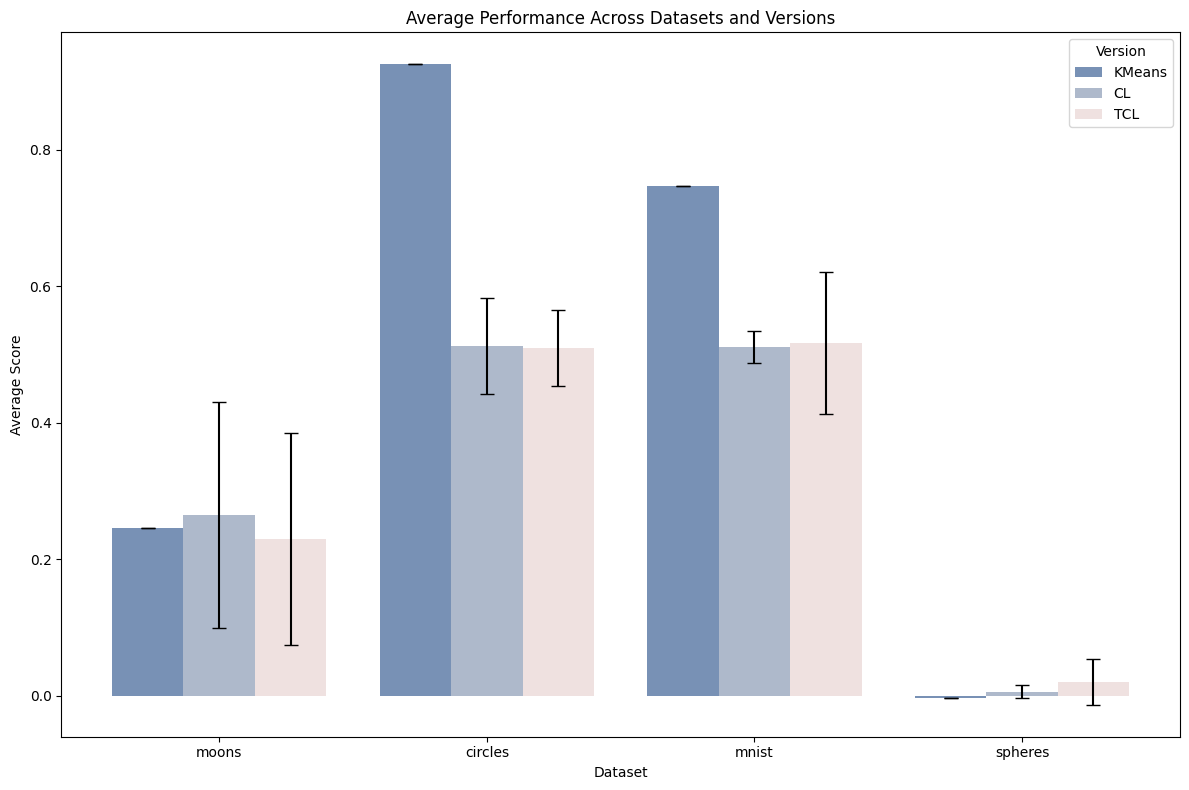

In [7]:
data_list = []
for dataset_name, versions in averages.items():
    i=0
    for version, avg_score in versions.items():
        std_score = std_devs[dataset_name][version]
        data_list.append({'Dataset': dataset_name, 'Version': versionss[i], 'Average Score': avg_score, 'Standard Deviation': std_score})
        i+=1

data_df = pd.DataFrame(data_list)

n_palette = sns.color_palette("vlag") # Example palette

# Skip a color, for example, the second color
n_palette = n_palette[:2]+n_palette[3:]
# Create the plot
plt.figure(figsize=(12, 8))
ax = sns.barplot(x='Dataset', y='Average Score', hue='Version', data=data_df, palette=n_palette)

# Calculate positions for error bars
n_bars = len(data_df['Version'].unique())
bar_width = 0.8
group_width = n_bars * bar_width
single_bar_width = bar_width / n_bars
offset = (np.arange(n_bars) - np.arange(n_bars).mean()) * single_bar_width

# Add error bars
for i, dataset in enumerate(data_df['Dataset'].unique()):
    for j, version in enumerate(data_df['Version'].unique()):
        subset = data_df[(data_df['Version'] == version) & (data_df['Dataset'] == dataset)]
        position = i + offset[j]
        plt.errorbar(x=position, y=subset['Average Score'], yerr=subset['Standard Deviation'], fmt='none', c='black', capsize=5)

plt.title('Average Performance Across Datasets and Versions')
plt.ylabel('Average Score')
plt.xlabel('Dataset')
plt.legend(title='Version')
plt.tight_layout()
plt.show()

In [8]:
for _ in range(n_runs):
            N_ari_score_mon = run_experiment(dataset_info['loader'], dataset_info['X'], dataset_info['Y'], 
                                       method=dataset_info['method'], n_clusters=dataset_info['n_clusters'], n_tensors=dataset_info['n_clusters'],
                                       epochs=dataset_info['epochs'], batch_size=dataset_info['batch'], embed= dataset_info['embed'], lr=dataset_info['lr'], model='non', version=version)
            N_results[dataset_name][version].append(N_ari_score)

KeyError: 'lr'

In [10]:
N_datasets = {
    'moons': {'loader': non_moon_triplet_loader, 'X': non_moon_X, 'Y': non_moon_Y, 'n_clusters': 2, 'epochs': 50, 'embed': 1, 'method': 'tensor', 'batch': BATCH, 'lr': 0.01},
    'circles': {'loader': non_circle_triplet_loader, 'X': non_circle_X, 'Y': non_circle_Y, 'n_clusters': 12, 'epochs': 20, 'embed': 1, 'method': '', 'batch': 600, 'lr': 0.1},
    'mnist': {'loader': non_mnist_triplet_loader, 'X': non_mnist_X, 'Y': non_mnist_Y, 'n_clusters': 3, 'epochs': 100, 'embed': 10, 'method': '', 'batch': 200, 'lr': 0.001},
    'spheres': {'loader': non_sphere_triplet_loader, 'X': non_sphere_X, 'Y': non_sphere_Y, 'n_clusters': 2, 'epochs': 50, 'embed': 1, 'method': '', 'batch': BATCH, 'lr': 0.001}
}

versions = ['KMeans', 'CAE', 'Tensor']
N_results = {dataset: {version: [] for version in versions} for dataset in N_datasets}
moon_results = {dataset: {version: [] for version in versions} for dataset in N_datasets}

n_runs = 10
# (dataset_loader, X, Y, method, n_clusters,n_tensors,epochs, batch_size, embed, lr):
for dataset_name, dataset_info in N_datasets.items():
    for version in versions:
        for _ in range(n_runs):
            N_ari_score = run_experiment(dataset_info['loader'], dataset_info['X'], dataset_info['Y'], 
                                       method=dataset_info['method'], n_clusters=dataset_info['n_clusters'], n_tensors=dataset_info['n_clusters'],
                                       epochs=dataset_info['epochs'], batch_size=dataset_info['batch'], embed= dataset_info['embed'], lr=dataset_info['lr'], model='non', version=version)
            moon_results[dataset_name][version].append(N_ari_score)

# This loop will populate the `results` dictionary with ARI scores for each method across each dataset.


Training Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 2/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 3/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 4/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 5/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 6/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 7/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 8/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 9/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 10/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 11/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 12/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 13/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 14/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 15/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 16/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 17/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 18/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 19/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 20/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 21/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 22/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 23/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 24/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 25/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 26/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 27/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 28/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 29/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 30/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 31/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 32/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 33/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 34/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 35/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 36/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 37/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 38/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 39/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 40/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 41/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 42/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 43/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 44/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 45/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 46/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 47/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 48/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 49/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 50/50:   0%|          | 0/1 [00:00<?, ?it/s]

/Users/omardebouni/miniconda3/envs/pytorch/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Training Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 2/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 3/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 4/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 5/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 6/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 7/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 8/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 9/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 10/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 11/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 12/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 13/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 14/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 15/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 16/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 17/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 18/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 19/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 20/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 21/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 22/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 23/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 24/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 25/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 26/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 27/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 28/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 29/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 30/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 31/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 32/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 33/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 34/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 35/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 36/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 37/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 38/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 39/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 40/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 41/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 42/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 43/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 44/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 45/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 46/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 47/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 48/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 49/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 50/50:   0%|          | 0/1 [00:00<?, ?it/s]

/Users/omardebouni/miniconda3/envs/pytorch/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Training Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 2/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 3/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 4/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 5/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 6/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 7/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 8/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 9/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 10/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 11/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 12/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 13/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 14/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 15/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 16/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 17/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 18/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 19/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 20/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 21/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 22/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 23/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 24/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 25/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 26/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 27/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 28/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 29/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 30/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 31/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 32/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 33/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 34/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 35/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 36/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 37/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 38/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 39/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 40/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 41/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 42/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 43/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 44/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 45/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 46/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 47/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 48/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 49/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 50/50:   0%|          | 0/1 [00:00<?, ?it/s]

/Users/omardebouni/miniconda3/envs/pytorch/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Training Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 2/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 3/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 4/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 5/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 6/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 7/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 8/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 9/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 10/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 11/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 12/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 13/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 14/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 15/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 16/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 17/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 18/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 19/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 20/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 21/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 22/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 23/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 24/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 25/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 26/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 27/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 28/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 29/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 30/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 31/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 32/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 33/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 34/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 35/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 36/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 37/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 38/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 39/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 40/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 41/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 42/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 43/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 44/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 45/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 46/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 47/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 48/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 49/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 50/50:   0%|          | 0/1 [00:00<?, ?it/s]

/Users/omardebouni/miniconda3/envs/pytorch/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Training Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 2/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 3/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 4/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 5/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 6/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 7/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 8/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 9/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 10/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 11/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 12/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 13/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 14/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 15/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 16/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 17/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 18/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 19/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 20/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 21/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 22/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 23/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 24/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 25/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 26/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 27/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 28/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 29/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 30/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 31/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 32/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 33/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 34/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 35/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 36/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 37/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 38/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 39/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 40/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 41/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 42/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 43/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 44/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 45/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 46/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 47/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 48/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 49/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 50/50:   0%|          | 0/1 [00:00<?, ?it/s]

/Users/omardebouni/miniconda3/envs/pytorch/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Training Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 2/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 3/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 4/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 5/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 6/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 7/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 8/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 9/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 10/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 11/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 12/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 13/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 14/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 15/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 16/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 17/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 18/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 19/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 20/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 21/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 22/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 23/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 24/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 25/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 26/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 27/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 28/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 29/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 30/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 31/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 32/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 33/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 34/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 35/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 36/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 37/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 38/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 39/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 40/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 41/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 42/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 43/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 44/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 45/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 46/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 47/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 48/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 49/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 50/50:   0%|          | 0/1 [00:00<?, ?it/s]

/Users/omardebouni/miniconda3/envs/pytorch/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Training Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 2/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 3/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 4/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 5/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 6/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 7/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 8/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 9/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 10/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 11/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 12/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 13/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 14/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 15/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 16/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 17/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 18/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 19/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 20/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 21/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 22/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 23/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 24/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 25/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 26/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 27/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 28/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 29/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 30/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 31/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 32/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 33/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 34/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 35/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 36/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 37/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 38/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 39/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 40/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 41/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 42/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 43/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 44/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 45/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 46/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 47/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 48/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 49/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 50/50:   0%|          | 0/1 [00:00<?, ?it/s]

/Users/omardebouni/miniconda3/envs/pytorch/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Training Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 2/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 3/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 4/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 5/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 6/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 7/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 8/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 9/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 10/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 11/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 12/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 13/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 14/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 15/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 16/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 17/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 18/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 19/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 20/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 21/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 22/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 23/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 24/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 25/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 26/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 27/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 28/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 29/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 30/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 31/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 32/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 33/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 34/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 35/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 36/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 37/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 38/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 39/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 40/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 41/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 42/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 43/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 44/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 45/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 46/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 47/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 48/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 49/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 50/50:   0%|          | 0/1 [00:00<?, ?it/s]

/Users/omardebouni/miniconda3/envs/pytorch/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Training Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 2/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 3/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 4/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 5/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 6/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 7/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 8/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 9/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 10/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 11/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 12/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 13/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 14/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 15/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 16/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 17/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 18/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 19/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 20/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 21/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 22/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 23/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 24/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 25/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 26/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 27/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 28/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 29/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 30/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 31/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 32/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 33/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 34/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 35/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 36/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 37/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 38/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 39/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 40/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 41/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 42/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 43/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 44/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 45/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 46/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 47/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 48/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 49/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 50/50:   0%|          | 0/1 [00:00<?, ?it/s]

/Users/omardebouni/miniconda3/envs/pytorch/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Training Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 2/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 3/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 4/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 5/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 6/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 7/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 8/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 9/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 10/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 11/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 12/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 13/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 14/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 15/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 16/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 17/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 18/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 19/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 20/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 21/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 22/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 23/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 24/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 25/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 26/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 27/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 28/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 29/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 30/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 31/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 32/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 33/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 34/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 35/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 36/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 37/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 38/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 39/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 40/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 41/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 42/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 43/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 44/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 45/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 46/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 47/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 48/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 49/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 50/50:   0%|          | 0/1 [00:00<?, ?it/s]

/Users/omardebouni/miniconda3/envs/pytorch/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Training Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 2/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 3/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 4/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 5/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 6/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 7/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 8/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 9/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 10/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 11/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 12/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 13/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 14/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 15/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 16/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 17/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 18/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 19/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 20/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 21/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 22/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 23/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 24/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 25/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 26/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 27/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 28/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 29/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 30/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 31/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 32/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 33/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 34/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 35/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 36/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 37/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 38/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 39/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 40/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 41/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 42/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 43/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 44/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 45/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 46/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 47/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 48/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 49/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 50/50:   0%|          | 0/1 [00:00<?, ?it/s]

Training Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 2/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 3/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 4/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 5/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 6/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 7/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 8/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 9/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 10/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 11/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 12/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 13/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 14/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 15/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 16/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 17/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 18/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 19/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 20/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 21/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 22/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 23/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 24/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 25/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 26/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 27/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 28/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 29/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 30/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 31/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 32/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 33/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 34/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 35/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 36/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 37/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 38/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 39/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 40/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 41/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 42/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 43/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 44/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 45/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 46/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 47/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 48/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 49/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 50/50:   0%|          | 0/1 [00:00<?, ?it/s]

Training Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 2/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 3/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 4/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 5/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 6/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 7/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 8/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 9/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 10/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 11/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 12/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 13/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 14/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 15/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 16/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 17/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 18/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 19/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 20/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 21/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 22/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 23/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 24/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 25/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 26/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 27/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 28/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 29/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 30/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 31/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 32/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 33/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 34/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 35/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 36/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 37/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 38/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 39/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 40/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 41/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 42/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 43/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 44/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 45/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 46/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 47/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 48/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 49/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 50/50:   0%|          | 0/1 [00:00<?, ?it/s]

Training Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 2/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 3/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 4/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 5/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 6/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 7/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 8/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 9/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 10/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 11/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 12/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 13/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 14/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 15/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 16/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 17/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 18/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 19/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 20/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 21/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 22/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 23/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 24/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 25/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 26/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 27/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 28/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 29/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 30/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 31/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 32/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 33/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 34/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 35/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 36/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 37/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 38/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 39/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 40/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 41/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 42/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 43/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 44/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 45/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 46/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 47/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 48/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 49/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 50/50:   0%|          | 0/1 [00:00<?, ?it/s]

Training Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 2/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 3/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 4/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 5/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 6/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 7/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 8/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 9/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 10/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 11/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 12/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 13/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 14/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 15/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 16/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 17/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 18/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 19/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 20/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 21/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 22/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 23/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 24/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 25/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 26/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 27/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 28/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 29/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 30/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 31/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 32/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 33/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 34/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 35/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 36/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 37/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 38/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 39/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 40/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 41/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 42/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 43/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 44/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 45/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 46/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 47/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 48/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 49/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 50/50:   0%|          | 0/1 [00:00<?, ?it/s]

Training Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 2/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 3/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 4/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 5/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 6/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 7/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 8/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 9/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 10/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 11/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 12/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 13/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 14/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 15/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 16/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 17/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 18/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 19/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 20/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 21/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 22/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 23/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 24/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 25/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 26/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 27/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 28/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 29/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 30/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 31/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 32/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 33/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 34/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 35/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 36/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 37/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 38/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 39/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 40/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 41/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 42/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 43/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 44/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 45/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 46/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 47/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 48/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 49/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 50/50:   0%|          | 0/1 [00:00<?, ?it/s]

Training Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 2/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 3/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 4/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 5/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 6/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 7/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 8/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 9/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 10/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 11/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 12/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 13/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 14/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 15/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 16/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 17/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 18/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 19/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 20/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 21/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 22/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 23/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 24/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 25/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 26/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 27/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 28/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 29/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 30/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 31/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 32/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 33/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 34/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 35/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 36/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 37/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 38/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 39/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 40/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 41/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 42/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 43/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 44/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 45/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 46/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 47/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 48/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 49/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 50/50:   0%|          | 0/1 [00:00<?, ?it/s]

Training Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 2/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 3/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 4/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 5/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 6/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 7/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 8/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 9/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 10/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 11/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 12/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 13/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 14/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 15/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 16/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 17/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 18/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 19/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 20/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 21/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 22/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 23/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 24/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 25/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 26/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 27/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 28/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 29/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 30/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 31/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 32/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 33/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 34/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 35/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 36/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 37/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 38/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 39/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 40/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 41/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 42/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 43/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 44/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 45/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 46/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 47/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 48/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 49/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 50/50:   0%|          | 0/1 [00:00<?, ?it/s]

Training Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 2/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 3/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 4/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 5/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 6/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 7/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 8/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 9/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 10/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 11/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 12/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 13/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 14/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 15/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 16/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 17/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 18/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 19/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 20/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 21/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 22/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 23/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 24/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 25/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 26/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 27/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 28/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 29/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 30/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 31/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 32/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 33/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 34/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 35/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 36/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 37/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 38/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 39/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 40/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 41/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 42/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 43/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 44/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 45/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 46/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 47/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 48/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 49/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 50/50:   0%|          | 0/1 [00:00<?, ?it/s]

Training Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 2/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 3/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 4/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 5/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 6/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 7/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 8/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 9/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 10/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 11/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 12/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 13/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 14/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 15/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 16/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 17/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 18/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 19/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 20/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 21/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 22/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 23/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 24/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 25/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 26/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 27/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 28/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 29/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 30/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 31/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 32/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 33/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 34/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 35/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 36/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 37/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 38/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 39/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 40/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 41/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 42/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 43/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 44/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 45/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 46/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 47/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 48/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 49/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 50/50:   0%|          | 0/1 [00:00<?, ?it/s]

Training Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 2/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 3/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 4/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 5/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 6/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 7/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 8/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 9/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 10/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 11/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 12/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 13/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 14/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 15/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 16/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 17/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 18/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 19/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 20/20:   0%|          | 0/1 [00:00<?, ?it/s]

/Users/omardebouni/miniconda3/envs/pytorch/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Training Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 2/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 3/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 4/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 5/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 6/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 7/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 8/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 9/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 10/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 11/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 12/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 13/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 14/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 15/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 16/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 17/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 18/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 19/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 20/20:   0%|          | 0/1 [00:00<?, ?it/s]

/Users/omardebouni/miniconda3/envs/pytorch/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Training Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 2/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 3/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 4/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 5/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 6/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 7/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 8/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 9/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 10/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 11/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 12/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 13/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 14/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 15/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 16/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 17/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 18/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 19/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 20/20:   0%|          | 0/1 [00:00<?, ?it/s]

/Users/omardebouni/miniconda3/envs/pytorch/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Training Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 2/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 3/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 4/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 5/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 6/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 7/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 8/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 9/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 10/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 11/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 12/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 13/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 14/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 15/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 16/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 17/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 18/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 19/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 20/20:   0%|          | 0/1 [00:00<?, ?it/s]

/Users/omardebouni/miniconda3/envs/pytorch/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Training Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 2/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 3/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 4/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 5/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 6/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 7/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 8/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 9/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 10/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 11/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 12/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 13/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 14/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 15/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 16/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 17/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 18/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 19/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 20/20:   0%|          | 0/1 [00:00<?, ?it/s]

/Users/omardebouni/miniconda3/envs/pytorch/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Training Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 2/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 3/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 4/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 5/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 6/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 7/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 8/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 9/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 10/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 11/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 12/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 13/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 14/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 15/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 16/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 17/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 18/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 19/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 20/20:   0%|          | 0/1 [00:00<?, ?it/s]

/Users/omardebouni/miniconda3/envs/pytorch/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Training Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 2/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 3/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 4/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 5/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 6/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 7/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 8/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 9/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 10/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 11/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 12/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 13/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 14/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 15/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 16/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 17/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 18/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 19/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 20/20:   0%|          | 0/1 [00:00<?, ?it/s]

/Users/omardebouni/miniconda3/envs/pytorch/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Training Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 2/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 3/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 4/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 5/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 6/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 7/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 8/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 9/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 10/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 11/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 12/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 13/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 14/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 15/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 16/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 17/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 18/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 19/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 20/20:   0%|          | 0/1 [00:00<?, ?it/s]

/Users/omardebouni/miniconda3/envs/pytorch/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Training Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 2/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 3/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 4/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 5/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 6/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 7/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 8/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 9/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 10/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 11/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 12/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 13/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 14/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 15/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 16/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 17/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 18/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 19/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 20/20:   0%|          | 0/1 [00:00<?, ?it/s]

/Users/omardebouni/miniconda3/envs/pytorch/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Training Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 2/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 3/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 4/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 5/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 6/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 7/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 8/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 9/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 10/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 11/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 12/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 13/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 14/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 15/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 16/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 17/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 18/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 19/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 20/20:   0%|          | 0/1 [00:00<?, ?it/s]

/Users/omardebouni/miniconda3/envs/pytorch/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Training Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 2/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 3/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 4/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 5/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 6/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 7/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 8/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 9/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 10/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 11/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 12/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 13/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 14/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 15/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 16/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 17/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 18/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 19/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 20/20:   0%|          | 0/1 [00:00<?, ?it/s]

Training Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 2/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 3/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 4/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 5/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 6/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 7/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 8/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 9/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 10/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 11/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 12/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 13/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 14/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 15/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 16/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 17/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 18/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 19/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 20/20:   0%|          | 0/1 [00:00<?, ?it/s]

Training Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 2/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 3/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 4/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 5/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 6/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 7/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 8/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 9/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 10/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 11/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 12/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 13/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 14/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 15/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 16/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 17/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 18/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 19/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 20/20:   0%|          | 0/1 [00:00<?, ?it/s]

Training Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 2/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 3/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 4/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 5/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 6/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 7/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 8/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 9/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 10/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 11/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 12/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 13/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 14/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 15/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 16/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 17/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 18/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 19/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 20/20:   0%|          | 0/1 [00:00<?, ?it/s]

Training Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 2/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 3/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 4/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 5/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 6/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 7/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 8/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 9/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 10/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 11/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 12/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 13/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 14/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 15/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 16/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 17/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 18/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 19/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 20/20:   0%|          | 0/1 [00:00<?, ?it/s]

Training Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 2/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 3/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 4/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 5/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 6/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 7/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 8/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 9/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 10/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 11/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 12/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 13/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 14/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 15/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 16/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 17/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 18/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 19/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 20/20:   0%|          | 0/1 [00:00<?, ?it/s]

Training Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 2/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 3/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 4/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 5/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 6/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 7/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 8/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 9/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 10/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 11/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 12/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 13/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 14/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 15/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 16/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 17/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 18/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 19/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 20/20:   0%|          | 0/1 [00:00<?, ?it/s]

Training Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 2/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 3/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 4/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 5/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 6/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 7/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 8/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 9/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 10/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 11/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 12/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 13/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 14/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 15/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 16/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 17/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 18/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 19/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 20/20:   0%|          | 0/1 [00:00<?, ?it/s]

Training Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 2/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 3/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 4/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 5/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 6/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 7/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 8/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 9/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 10/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 11/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 12/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 13/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 14/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 15/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 16/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 17/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 18/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 19/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 20/20:   0%|          | 0/1 [00:00<?, ?it/s]

Training Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 2/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 3/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 4/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 5/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 6/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 7/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 8/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 9/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 10/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 11/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 12/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 13/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 14/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 15/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 16/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 17/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 18/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 19/20:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 20/20:   0%|          | 0/1 [00:00<?, ?it/s]

Training Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 2/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 3/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 4/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 5/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 6/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 7/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 8/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 9/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 10/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 11/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 12/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 13/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 14/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 15/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 16/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 17/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 18/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 19/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 20/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 21/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 22/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 23/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 24/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 25/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 26/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 27/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 28/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 29/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 30/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 31/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 32/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 33/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 34/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 35/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 36/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 37/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 38/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 39/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 40/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 41/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 42/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 43/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 44/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 45/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 46/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 47/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 48/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 49/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 50/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 51/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 52/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 53/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 54/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 55/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 56/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 57/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 58/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 59/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 60/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 61/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 62/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 63/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 64/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 65/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 66/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 67/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 68/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 69/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 70/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 71/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 72/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 73/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 74/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 75/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 76/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 77/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 78/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 79/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 80/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 81/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 82/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 83/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 84/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 85/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 86/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 87/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 88/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 89/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 90/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 91/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 92/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 93/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 94/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 95/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 96/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 97/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 98/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 99/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 100/100:   0%|          | 0/1 [00:00<?, ?it/s]

/Users/omardebouni/miniconda3/envs/pytorch/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Training Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 2/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 3/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 4/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 5/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 6/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 7/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 8/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 9/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 10/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 11/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 12/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 13/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 14/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 15/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 16/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 17/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 18/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 19/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 20/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 21/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 22/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 23/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 24/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 25/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 26/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 27/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 28/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 29/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 30/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 31/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 32/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 33/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 34/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 35/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 36/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 37/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 38/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 39/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 40/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 41/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 42/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 43/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 44/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 45/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 46/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 47/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 48/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 49/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 50/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 51/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 52/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 53/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 54/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 55/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 56/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 57/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 58/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 59/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 60/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 61/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 62/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 63/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 64/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 65/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 66/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 67/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 68/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 69/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 70/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 71/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 72/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 73/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 74/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 75/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 76/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 77/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 78/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 79/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 80/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 81/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 82/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 83/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 84/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 85/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 86/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 87/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 88/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 89/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 90/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 91/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 92/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 93/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 94/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 95/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 96/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 97/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 98/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 99/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 100/100:   0%|          | 0/1 [00:00<?, ?it/s]

/Users/omardebouni/miniconda3/envs/pytorch/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Training Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 2/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 3/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 4/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 5/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 6/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 7/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 8/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 9/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 10/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 11/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 12/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 13/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 14/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 15/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 16/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 17/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 18/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 19/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 20/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 21/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 22/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 23/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 24/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 25/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 26/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 27/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 28/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 29/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 30/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 31/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 32/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 33/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 34/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 35/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 36/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 37/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 38/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 39/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 40/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 41/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 42/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 43/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 44/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 45/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 46/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 47/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 48/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 49/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 50/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 51/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 52/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 53/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 54/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 55/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 56/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 57/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 58/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 59/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 60/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 61/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 62/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 63/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 64/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 65/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 66/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 67/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 68/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 69/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 70/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 71/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 72/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 73/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 74/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 75/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 76/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 77/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 78/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 79/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 80/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 81/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 82/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 83/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 84/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 85/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 86/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 87/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 88/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 89/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 90/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 91/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 92/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 93/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 94/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 95/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 96/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 97/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 98/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 99/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 100/100:   0%|          | 0/1 [00:00<?, ?it/s]

/Users/omardebouni/miniconda3/envs/pytorch/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Training Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 2/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 3/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 4/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 5/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 6/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 7/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 8/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 9/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 10/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 11/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 12/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 13/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 14/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 15/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 16/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 17/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 18/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 19/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 20/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 21/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 22/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 23/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 24/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 25/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 26/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 27/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 28/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 29/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 30/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 31/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 32/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 33/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 34/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 35/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 36/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 37/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 38/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 39/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 40/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 41/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 42/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 43/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 44/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 45/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 46/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 47/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 48/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 49/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 50/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 51/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 52/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 53/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 54/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 55/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 56/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 57/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 58/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 59/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 60/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 61/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 62/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 63/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 64/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 65/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 66/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 67/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 68/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 69/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 70/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 71/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 72/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 73/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 74/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 75/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 76/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 77/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 78/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 79/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 80/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 81/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 82/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 83/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 84/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 85/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 86/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 87/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 88/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 89/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 90/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 91/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 92/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 93/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 94/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 95/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 96/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 97/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 98/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 99/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 100/100:   0%|          | 0/1 [00:00<?, ?it/s]

/Users/omardebouni/miniconda3/envs/pytorch/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Training Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 2/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 3/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 4/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 5/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 6/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 7/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 8/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 9/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 10/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 11/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 12/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 13/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 14/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 15/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 16/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 17/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 18/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 19/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 20/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 21/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 22/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 23/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 24/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 25/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 26/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 27/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 28/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 29/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 30/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 31/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 32/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 33/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 34/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 35/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 36/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 37/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 38/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 39/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 40/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 41/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 42/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 43/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 44/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 45/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 46/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 47/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 48/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 49/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 50/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 51/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 52/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 53/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 54/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 55/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 56/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 57/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 58/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 59/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 60/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 61/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 62/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 63/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 64/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 65/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 66/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 67/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 68/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 69/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 70/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 71/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 72/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 73/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 74/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 75/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 76/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 77/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 78/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 79/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 80/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 81/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 82/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 83/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 84/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 85/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 86/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 87/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 88/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 89/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 90/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 91/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 92/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 93/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 94/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 95/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 96/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 97/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 98/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 99/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 100/100:   0%|          | 0/1 [00:00<?, ?it/s]

/Users/omardebouni/miniconda3/envs/pytorch/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Training Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 2/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 3/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 4/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 5/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 6/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 7/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 8/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 9/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 10/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 11/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 12/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 13/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 14/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 15/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 16/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 17/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 18/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 19/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 20/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 21/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 22/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 23/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 24/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 25/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 26/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 27/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 28/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 29/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 30/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 31/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 32/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 33/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 34/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 35/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 36/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 37/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 38/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 39/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 40/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 41/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 42/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 43/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 44/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 45/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 46/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 47/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 48/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 49/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 50/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 51/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 52/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 53/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 54/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 55/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 56/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 57/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 58/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 59/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 60/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 61/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 62/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 63/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 64/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 65/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 66/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 67/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 68/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 69/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 70/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 71/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 72/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 73/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 74/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 75/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 76/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 77/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 78/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 79/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 80/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 81/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 82/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 83/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 84/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 85/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 86/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 87/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 88/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 89/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 90/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 91/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 92/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 93/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 94/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 95/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 96/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 97/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 98/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 99/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 100/100:   0%|          | 0/1 [00:00<?, ?it/s]

/Users/omardebouni/miniconda3/envs/pytorch/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Training Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 2/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 3/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 4/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 5/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 6/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 7/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 8/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 9/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 10/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 11/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 12/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 13/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 14/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 15/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 16/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 17/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 18/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 19/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 20/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 21/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 22/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 23/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 24/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 25/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 26/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 27/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 28/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 29/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 30/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 31/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 32/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 33/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 34/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 35/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 36/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 37/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 38/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 39/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 40/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 41/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 42/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 43/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 44/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 45/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 46/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 47/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 48/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 49/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 50/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 51/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 52/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 53/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 54/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 55/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 56/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 57/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 58/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 59/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 60/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 61/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 62/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 63/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 64/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 65/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 66/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 67/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 68/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 69/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 70/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 71/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 72/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 73/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 74/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 75/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 76/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 77/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 78/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 79/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 80/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 81/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 82/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 83/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 84/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 85/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 86/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 87/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 88/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 89/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 90/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 91/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 92/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 93/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 94/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 95/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 96/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 97/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 98/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 99/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 100/100:   0%|          | 0/1 [00:00<?, ?it/s]

/Users/omardebouni/miniconda3/envs/pytorch/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Training Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 2/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 3/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 4/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 5/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 6/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 7/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 8/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 9/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 10/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 11/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 12/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 13/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 14/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 15/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 16/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 17/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 18/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 19/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 20/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 21/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 22/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 23/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 24/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 25/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 26/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 27/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 28/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 29/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 30/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 31/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 32/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 33/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 34/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 35/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 36/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 37/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 38/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 39/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 40/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 41/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 42/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 43/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 44/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 45/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 46/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 47/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 48/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 49/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 50/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 51/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 52/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 53/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 54/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 55/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 56/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 57/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 58/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 59/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 60/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 61/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 62/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 63/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 64/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 65/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 66/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 67/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 68/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 69/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 70/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 71/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 72/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 73/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 74/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 75/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 76/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 77/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 78/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 79/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 80/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 81/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 82/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 83/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 84/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 85/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 86/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 87/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 88/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 89/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 90/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 91/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 92/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 93/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 94/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 95/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 96/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 97/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 98/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 99/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 100/100:   0%|          | 0/1 [00:00<?, ?it/s]

/Users/omardebouni/miniconda3/envs/pytorch/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Training Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 2/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 3/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 4/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 5/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 6/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 7/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 8/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 9/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 10/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 11/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 12/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 13/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 14/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 15/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 16/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 17/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 18/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 19/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 20/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 21/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 22/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 23/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 24/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 25/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 26/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 27/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 28/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 29/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 30/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 31/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 32/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 33/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 34/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 35/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 36/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 37/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 38/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 39/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 40/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 41/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 42/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 43/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 44/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 45/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 46/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 47/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 48/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 49/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 50/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 51/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 52/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 53/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 54/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 55/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 56/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 57/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 58/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 59/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 60/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 61/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 62/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 63/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 64/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 65/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 66/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 67/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 68/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 69/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 70/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 71/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 72/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 73/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 74/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 75/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 76/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 77/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 78/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 79/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 80/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 81/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 82/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 83/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 84/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 85/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 86/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 87/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 88/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 89/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 90/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 91/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 92/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 93/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 94/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 95/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 96/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 97/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 98/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 99/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 100/100:   0%|          | 0/1 [00:00<?, ?it/s]

/Users/omardebouni/miniconda3/envs/pytorch/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Training Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 2/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 3/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 4/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 5/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 6/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 7/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 8/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 9/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 10/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 11/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 12/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 13/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 14/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 15/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 16/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 17/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 18/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 19/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 20/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 21/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 22/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 23/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 24/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 25/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 26/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 27/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 28/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 29/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 30/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 31/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 32/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 33/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 34/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 35/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 36/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 37/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 38/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 39/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 40/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 41/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 42/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 43/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 44/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 45/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 46/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 47/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 48/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 49/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 50/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 51/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 52/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 53/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 54/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 55/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 56/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 57/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 58/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 59/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 60/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 61/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 62/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 63/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 64/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 65/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 66/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 67/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 68/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 69/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 70/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 71/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 72/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 73/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 74/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 75/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 76/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 77/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 78/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 79/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 80/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 81/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 82/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 83/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 84/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 85/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 86/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 87/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 88/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 89/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 90/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 91/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 92/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 93/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 94/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 95/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 96/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 97/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 98/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 99/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 100/100:   0%|          | 0/1 [00:00<?, ?it/s]

/Users/omardebouni/miniconda3/envs/pytorch/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Training Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 2/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 3/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 4/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 5/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 6/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 7/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 8/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 9/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 10/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 11/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 12/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 13/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 14/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 15/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 16/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 17/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 18/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 19/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 20/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 21/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 22/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 23/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 24/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 25/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 26/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 27/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 28/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 29/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 30/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 31/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 32/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 33/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 34/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 35/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 36/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 37/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 38/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 39/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 40/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 41/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 42/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 43/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 44/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 45/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 46/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 47/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 48/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 49/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 50/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 51/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 52/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 53/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 54/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 55/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 56/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 57/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 58/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 59/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 60/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 61/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 62/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 63/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 64/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 65/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 66/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 67/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 68/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 69/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 70/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 71/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 72/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 73/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 74/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 75/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 76/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 77/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 78/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 79/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 80/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 81/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 82/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 83/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 84/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 85/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 86/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 87/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 88/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 89/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 90/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 91/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 92/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 93/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 94/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 95/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 96/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 97/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 98/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 99/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 100/100:   0%|          | 0/1 [00:00<?, ?it/s]

Training Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 2/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 3/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 4/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 5/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 6/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 7/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 8/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 9/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 10/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 11/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 12/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 13/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 14/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 15/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 16/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 17/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 18/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 19/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 20/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 21/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 22/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 23/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 24/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 25/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 26/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 27/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 28/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 29/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 30/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 31/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 32/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 33/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 34/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 35/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 36/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 37/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 38/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 39/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 40/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 41/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 42/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 43/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 44/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 45/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 46/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 47/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 48/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 49/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 50/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 51/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 52/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 53/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 54/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 55/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 56/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 57/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 58/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 59/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 60/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 61/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 62/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 63/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 64/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 65/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 66/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 67/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 68/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 69/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 70/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 71/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 72/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 73/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 74/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 75/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 76/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 77/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 78/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 79/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 80/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 81/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 82/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 83/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 84/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 85/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 86/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 87/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 88/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 89/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 90/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 91/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 92/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 93/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 94/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 95/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 96/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 97/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 98/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 99/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 100/100:   0%|          | 0/1 [00:00<?, ?it/s]

Training Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 2/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 3/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 4/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 5/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 6/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 7/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 8/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 9/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 10/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 11/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 12/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 13/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 14/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 15/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 16/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 17/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 18/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 19/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 20/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 21/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 22/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 23/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 24/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 25/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 26/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 27/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 28/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 29/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 30/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 31/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 32/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 33/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 34/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 35/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 36/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 37/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 38/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 39/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 40/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 41/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 42/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 43/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 44/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 45/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 46/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 47/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 48/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 49/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 50/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 51/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 52/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 53/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 54/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 55/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 56/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 57/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 58/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 59/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 60/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 61/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 62/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 63/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 64/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 65/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 66/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 67/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 68/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 69/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 70/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 71/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 72/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 73/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 74/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 75/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 76/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 77/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 78/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 79/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 80/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 81/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 82/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 83/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 84/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 85/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 86/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 87/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 88/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 89/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 90/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 91/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 92/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 93/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 94/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 95/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 96/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 97/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 98/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 99/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 100/100:   0%|          | 0/1 [00:00<?, ?it/s]

Training Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 2/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 3/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 4/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 5/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 6/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 7/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 8/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 9/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 10/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 11/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 12/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 13/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 14/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 15/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 16/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 17/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 18/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 19/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 20/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 21/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 22/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 23/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 24/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 25/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 26/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 27/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 28/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 29/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 30/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 31/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 32/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 33/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 34/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 35/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 36/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 37/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 38/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 39/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 40/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 41/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 42/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 43/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 44/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 45/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 46/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 47/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 48/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 49/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 50/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 51/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 52/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 53/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 54/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 55/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 56/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 57/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 58/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 59/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 60/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 61/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 62/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 63/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 64/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 65/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 66/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 67/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 68/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 69/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 70/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 71/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 72/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 73/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 74/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 75/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 76/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 77/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 78/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 79/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 80/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 81/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 82/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 83/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 84/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 85/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 86/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 87/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 88/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 89/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 90/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 91/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 92/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 93/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 94/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 95/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 96/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 97/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 98/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 99/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 100/100:   0%|          | 0/1 [00:00<?, ?it/s]

Training Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 2/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 3/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 4/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 5/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 6/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 7/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 8/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 9/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 10/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 11/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 12/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 13/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 14/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 15/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 16/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 17/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 18/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 19/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 20/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 21/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 22/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 23/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 24/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 25/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 26/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 27/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 28/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 29/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 30/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 31/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 32/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 33/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 34/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 35/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 36/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 37/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 38/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 39/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 40/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 41/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 42/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 43/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 44/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 45/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 46/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 47/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 48/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 49/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 50/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 51/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 52/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 53/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 54/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 55/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 56/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 57/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 58/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 59/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 60/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 61/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 62/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 63/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 64/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 65/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 66/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 67/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 68/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 69/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 70/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 71/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 72/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 73/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 74/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 75/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 76/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 77/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 78/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 79/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 80/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 81/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 82/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 83/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 84/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 85/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 86/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 87/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 88/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 89/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 90/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 91/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 92/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 93/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 94/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 95/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 96/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 97/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 98/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 99/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 100/100:   0%|          | 0/1 [00:00<?, ?it/s]

Training Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 2/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 3/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 4/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 5/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 6/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 7/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 8/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 9/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 10/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 11/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 12/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 13/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 14/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 15/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 16/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 17/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 18/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 19/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 20/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 21/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 22/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 23/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 24/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 25/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 26/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 27/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 28/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 29/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 30/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 31/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 32/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 33/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 34/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 35/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 36/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 37/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 38/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 39/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 40/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 41/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 42/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 43/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 44/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 45/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 46/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 47/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 48/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 49/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 50/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 51/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 52/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 53/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 54/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 55/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 56/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 57/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 58/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 59/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 60/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 61/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 62/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 63/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 64/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 65/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 66/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 67/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 68/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 69/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 70/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 71/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 72/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 73/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 74/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 75/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 76/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 77/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 78/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 79/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 80/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 81/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 82/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 83/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 84/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 85/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 86/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 87/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 88/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 89/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 90/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 91/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 92/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 93/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 94/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 95/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 96/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 97/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 98/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 99/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 100/100:   0%|          | 0/1 [00:00<?, ?it/s]

Training Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 2/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 3/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 4/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 5/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 6/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 7/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 8/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 9/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 10/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 11/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 12/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 13/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 14/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 15/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 16/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 17/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 18/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 19/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 20/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 21/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 22/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 23/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 24/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 25/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 26/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 27/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 28/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 29/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 30/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 31/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 32/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 33/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 34/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 35/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 36/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 37/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 38/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 39/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 40/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 41/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 42/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 43/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 44/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 45/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 46/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 47/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 48/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 49/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 50/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 51/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 52/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 53/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 54/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 55/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 56/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 57/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 58/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 59/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 60/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 61/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 62/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 63/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 64/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 65/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 66/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 67/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 68/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 69/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 70/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 71/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 72/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 73/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 74/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 75/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 76/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 77/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 78/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 79/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 80/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 81/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 82/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 83/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 84/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 85/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 86/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 87/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 88/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 89/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 90/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 91/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 92/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 93/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 94/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 95/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 96/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 97/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 98/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 99/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 100/100:   0%|          | 0/1 [00:00<?, ?it/s]

Training Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 2/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 3/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 4/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 5/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 6/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 7/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 8/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 9/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 10/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 11/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 12/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 13/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 14/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 15/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 16/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 17/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 18/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 19/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 20/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 21/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 22/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 23/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 24/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 25/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 26/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 27/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 28/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 29/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 30/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 31/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 32/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 33/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 34/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 35/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 36/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 37/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 38/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 39/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 40/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 41/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 42/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 43/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 44/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 45/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 46/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 47/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 48/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 49/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 50/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 51/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 52/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 53/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 54/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 55/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 56/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 57/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 58/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 59/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 60/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 61/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 62/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 63/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 64/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 65/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 66/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 67/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 68/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 69/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 70/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 71/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 72/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 73/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 74/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 75/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 76/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 77/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 78/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 79/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 80/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 81/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 82/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 83/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 84/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 85/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 86/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 87/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 88/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 89/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 90/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 91/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 92/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 93/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 94/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 95/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 96/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 97/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 98/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 99/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 100/100:   0%|          | 0/1 [00:00<?, ?it/s]

Training Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 2/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 3/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 4/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 5/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 6/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 7/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 8/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 9/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 10/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 11/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 12/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 13/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 14/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 15/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 16/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 17/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 18/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 19/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 20/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 21/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 22/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 23/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 24/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 25/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 26/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 27/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 28/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 29/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 30/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 31/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 32/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 33/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 34/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 35/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 36/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 37/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 38/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 39/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 40/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 41/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 42/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 43/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 44/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 45/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 46/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 47/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 48/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 49/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 50/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 51/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 52/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 53/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 54/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 55/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 56/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 57/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 58/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 59/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 60/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 61/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 62/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 63/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 64/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 65/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 66/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 67/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 68/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 69/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 70/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 71/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 72/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 73/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 74/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 75/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 76/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 77/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 78/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 79/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 80/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 81/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 82/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 83/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 84/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 85/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 86/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 87/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 88/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 89/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 90/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 91/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 92/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 93/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 94/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 95/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 96/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 97/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 98/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 99/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 100/100:   0%|          | 0/1 [00:00<?, ?it/s]

Training Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 2/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 3/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 4/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 5/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 6/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 7/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 8/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 9/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 10/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 11/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 12/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 13/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 14/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 15/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 16/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 17/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 18/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 19/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 20/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 21/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 22/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 23/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 24/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 25/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 26/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 27/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 28/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 29/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 30/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 31/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 32/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 33/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 34/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 35/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 36/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 37/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 38/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 39/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 40/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 41/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 42/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 43/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 44/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 45/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 46/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 47/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 48/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 49/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 50/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 51/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 52/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 53/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 54/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 55/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 56/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 57/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 58/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 59/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 60/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 61/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 62/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 63/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 64/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 65/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 66/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 67/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 68/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 69/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 70/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 71/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 72/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 73/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 74/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 75/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 76/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 77/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 78/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 79/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 80/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 81/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 82/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 83/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 84/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 85/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 86/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 87/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 88/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 89/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 90/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 91/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 92/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 93/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 94/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 95/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 96/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 97/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 98/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 99/100:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 100/100:   0%|          | 0/1 [00:00<?, ?it/s]

Training Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 2/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 3/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 4/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 5/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 6/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 7/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 8/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 9/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 10/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 11/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 12/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 13/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 14/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 15/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 16/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 17/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 18/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 19/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 20/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 21/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 22/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 23/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 24/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 25/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 26/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 27/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 28/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 29/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 30/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 31/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 32/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 33/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 34/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 35/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 36/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 37/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 38/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 39/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 40/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 41/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 42/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 43/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 44/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 45/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 46/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 47/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 48/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 49/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 50/50:   0%|          | 0/1 [00:00<?, ?it/s]

/Users/omardebouni/miniconda3/envs/pytorch/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Training Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 2/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 3/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 4/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 5/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 6/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 7/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 8/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 9/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 10/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 11/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 12/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 13/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 14/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 15/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 16/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 17/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 18/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 19/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 20/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 21/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 22/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 23/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 24/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 25/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 26/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 27/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 28/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 29/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 30/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 31/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 32/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 33/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 34/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 35/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 36/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 37/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 38/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 39/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 40/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 41/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 42/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 43/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 44/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 45/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 46/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 47/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 48/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 49/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 50/50:   0%|          | 0/1 [00:00<?, ?it/s]

/Users/omardebouni/miniconda3/envs/pytorch/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Training Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 2/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 3/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 4/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 5/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 6/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 7/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 8/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 9/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 10/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 11/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 12/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 13/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 14/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 15/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 16/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 17/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 18/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 19/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 20/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 21/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 22/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 23/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 24/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 25/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 26/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 27/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 28/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 29/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 30/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 31/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 32/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 33/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 34/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 35/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 36/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 37/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 38/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 39/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 40/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 41/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 42/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 43/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 44/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 45/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 46/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 47/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 48/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 49/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 50/50:   0%|          | 0/1 [00:00<?, ?it/s]

/Users/omardebouni/miniconda3/envs/pytorch/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Training Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 2/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 3/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 4/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 5/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 6/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 7/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 8/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 9/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 10/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 11/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 12/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 13/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 14/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 15/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 16/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 17/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 18/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 19/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 20/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 21/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 22/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 23/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 24/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 25/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 26/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 27/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 28/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 29/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 30/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 31/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 32/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 33/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 34/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 35/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 36/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 37/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 38/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 39/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 40/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 41/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 42/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 43/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 44/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 45/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 46/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 47/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 48/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 49/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 50/50:   0%|          | 0/1 [00:00<?, ?it/s]

/Users/omardebouni/miniconda3/envs/pytorch/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Training Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 2/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 3/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 4/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 5/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 6/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 7/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 8/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 9/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 10/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 11/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 12/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 13/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 14/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 15/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 16/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 17/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 18/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 19/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 20/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 21/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 22/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 23/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 24/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 25/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 26/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 27/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 28/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 29/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 30/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 31/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 32/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 33/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 34/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 35/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 36/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 37/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 38/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 39/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 40/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 41/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 42/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 43/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 44/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 45/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 46/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 47/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 48/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 49/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 50/50:   0%|          | 0/1 [00:00<?, ?it/s]

/Users/omardebouni/miniconda3/envs/pytorch/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Training Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 2/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 3/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 4/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 5/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 6/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 7/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 8/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 9/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 10/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 11/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 12/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 13/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 14/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 15/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 16/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 17/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 18/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 19/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 20/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 21/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 22/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 23/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 24/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 25/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 26/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 27/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 28/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 29/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 30/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 31/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 32/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 33/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 34/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 35/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 36/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 37/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 38/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 39/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 40/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 41/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 42/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 43/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 44/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 45/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 46/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 47/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 48/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 49/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 50/50:   0%|          | 0/1 [00:00<?, ?it/s]

/Users/omardebouni/miniconda3/envs/pytorch/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Training Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 2/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 3/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 4/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 5/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 6/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 7/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 8/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 9/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 10/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 11/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 12/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 13/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 14/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 15/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 16/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 17/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 18/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 19/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 20/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 21/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 22/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 23/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 24/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 25/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 26/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 27/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 28/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 29/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 30/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 31/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 32/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 33/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 34/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 35/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 36/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 37/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 38/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 39/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 40/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 41/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 42/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 43/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 44/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 45/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 46/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 47/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 48/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 49/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 50/50:   0%|          | 0/1 [00:00<?, ?it/s]

/Users/omardebouni/miniconda3/envs/pytorch/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Training Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 2/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 3/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 4/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 5/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 6/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 7/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 8/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 9/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 10/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 11/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 12/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 13/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 14/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 15/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 16/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 17/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 18/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 19/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 20/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 21/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 22/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 23/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 24/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 25/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 26/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 27/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 28/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 29/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 30/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 31/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 32/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 33/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 34/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 35/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 36/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 37/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 38/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 39/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 40/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 41/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 42/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 43/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 44/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 45/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 46/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 47/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 48/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 49/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 50/50:   0%|          | 0/1 [00:00<?, ?it/s]

/Users/omardebouni/miniconda3/envs/pytorch/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Training Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 2/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 3/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 4/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 5/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 6/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 7/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 8/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 9/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 10/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 11/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 12/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 13/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 14/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 15/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 16/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 17/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 18/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 19/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 20/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 21/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 22/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 23/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 24/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 25/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 26/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 27/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 28/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 29/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 30/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 31/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 32/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 33/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 34/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 35/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 36/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 37/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 38/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 39/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 40/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 41/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 42/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 43/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 44/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 45/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 46/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 47/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 48/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 49/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 50/50:   0%|          | 0/1 [00:00<?, ?it/s]

/Users/omardebouni/miniconda3/envs/pytorch/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Training Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 2/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 3/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 4/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 5/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 6/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 7/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 8/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 9/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 10/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 11/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 12/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 13/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 14/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 15/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 16/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 17/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 18/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 19/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 20/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 21/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 22/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 23/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 24/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 25/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 26/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 27/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 28/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 29/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 30/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 31/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 32/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 33/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 34/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 35/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 36/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 37/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 38/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 39/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 40/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 41/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 42/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 43/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 44/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 45/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 46/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 47/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 48/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 49/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 50/50:   0%|          | 0/1 [00:00<?, ?it/s]

/Users/omardebouni/miniconda3/envs/pytorch/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Training Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 2/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 3/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 4/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 5/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 6/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 7/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 8/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 9/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 10/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 11/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 12/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 13/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 14/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 15/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 16/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 17/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 18/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 19/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 20/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 21/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 22/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 23/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 24/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 25/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 26/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 27/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 28/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 29/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 30/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 31/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 32/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 33/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 34/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 35/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 36/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 37/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 38/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 39/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 40/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 41/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 42/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 43/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 44/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 45/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 46/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 47/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 48/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 49/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 50/50:   0%|          | 0/1 [00:00<?, ?it/s]

Training Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 2/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 3/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 4/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 5/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 6/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 7/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 8/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 9/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 10/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 11/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 12/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 13/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 14/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 15/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 16/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 17/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 18/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 19/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 20/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 21/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 22/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 23/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 24/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 25/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 26/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 27/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 28/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 29/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 30/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 31/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 32/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 33/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 34/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 35/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 36/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 37/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 38/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 39/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 40/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 41/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 42/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 43/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 44/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 45/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 46/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 47/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 48/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 49/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 50/50:   0%|          | 0/1 [00:00<?, ?it/s]

Training Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 2/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 3/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 4/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 5/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 6/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 7/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 8/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 9/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 10/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 11/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 12/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 13/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 14/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 15/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 16/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 17/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 18/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 19/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 20/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 21/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 22/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 23/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 24/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 25/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 26/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 27/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 28/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 29/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 30/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 31/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 32/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 33/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 34/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 35/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 36/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 37/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 38/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 39/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 40/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 41/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 42/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 43/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 44/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 45/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 46/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 47/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 48/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 49/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 50/50:   0%|          | 0/1 [00:00<?, ?it/s]

Training Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 2/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 3/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 4/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 5/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 6/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 7/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 8/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 9/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 10/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 11/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 12/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 13/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 14/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 15/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 16/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 17/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 18/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 19/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 20/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 21/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 22/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 23/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 24/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 25/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 26/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 27/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 28/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 29/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 30/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 31/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 32/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 33/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 34/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 35/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 36/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 37/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 38/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 39/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 40/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 41/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 42/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 43/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 44/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 45/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 46/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 47/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 48/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 49/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 50/50:   0%|          | 0/1 [00:00<?, ?it/s]

Training Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 2/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 3/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 4/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 5/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 6/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 7/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 8/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 9/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 10/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 11/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 12/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 13/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 14/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 15/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 16/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 17/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 18/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 19/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 20/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 21/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 22/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 23/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 24/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 25/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 26/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 27/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 28/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 29/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 30/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 31/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 32/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 33/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 34/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 35/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 36/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 37/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 38/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 39/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 40/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 41/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 42/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 43/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 44/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 45/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 46/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 47/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 48/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 49/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 50/50:   0%|          | 0/1 [00:00<?, ?it/s]

Training Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 2/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 3/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 4/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 5/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 6/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 7/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 8/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 9/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 10/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 11/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 12/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 13/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 14/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 15/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 16/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 17/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 18/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 19/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 20/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 21/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 22/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 23/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 24/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 25/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 26/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 27/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 28/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 29/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 30/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 31/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 32/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 33/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 34/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 35/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 36/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 37/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 38/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 39/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 40/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 41/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 42/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 43/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 44/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 45/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 46/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 47/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 48/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 49/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 50/50:   0%|          | 0/1 [00:00<?, ?it/s]

Training Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 2/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 3/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 4/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 5/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 6/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 7/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 8/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 9/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 10/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 11/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 12/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 13/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 14/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 15/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 16/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 17/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 18/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 19/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 20/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 21/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 22/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 23/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 24/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 25/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 26/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 27/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 28/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 29/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 30/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 31/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 32/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 33/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 34/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 35/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 36/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 37/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 38/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 39/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 40/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 41/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 42/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 43/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 44/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 45/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 46/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 47/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 48/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 49/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 50/50:   0%|          | 0/1 [00:00<?, ?it/s]

Training Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 2/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 3/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 4/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 5/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 6/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 7/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 8/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 9/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 10/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 11/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 12/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 13/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 14/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 15/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 16/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 17/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 18/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 19/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 20/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 21/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 22/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 23/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 24/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 25/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 26/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 27/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 28/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 29/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 30/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 31/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 32/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 33/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 34/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 35/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 36/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 37/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 38/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 39/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 40/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 41/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 42/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 43/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 44/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 45/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 46/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 47/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 48/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 49/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 50/50:   0%|          | 0/1 [00:00<?, ?it/s]

Training Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 2/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 3/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 4/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 5/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 6/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 7/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 8/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 9/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 10/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 11/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 12/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 13/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 14/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 15/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 16/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 17/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 18/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 19/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 20/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 21/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 22/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 23/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 24/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 25/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 26/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 27/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 28/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 29/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 30/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 31/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 32/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 33/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 34/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 35/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 36/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 37/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 38/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 39/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 40/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 41/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 42/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 43/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 44/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 45/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 46/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 47/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 48/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 49/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 50/50:   0%|          | 0/1 [00:00<?, ?it/s]

Training Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 2/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 3/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 4/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 5/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 6/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 7/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 8/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 9/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 10/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 11/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 12/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 13/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 14/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 15/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 16/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 17/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 18/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 19/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 20/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 21/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 22/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 23/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 24/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 25/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 26/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 27/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 28/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 29/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 30/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 31/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 32/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 33/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 34/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 35/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 36/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 37/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 38/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 39/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 40/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 41/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 42/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 43/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 44/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 45/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 46/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 47/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 48/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 49/50:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 50/50:   0%|          | 0/1 [00:00<?, ?it/s]

In [11]:
averages = {dataset: {} for dataset in N_datasets}
std_devs = {dataset: {} for dataset in N_datasets}

for dataset_name in N_datasets:
    for version in versions:
        avg_ari = np.mean(N_results[dataset_name][version])
        std_ari = np.std(N_results[dataset_name][version])
        averages[dataset_name][version] = avg_ari
        std_devs[dataset_name][version] = std_ari


/Users/omardebouni/miniconda3/envs/pytorch/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/omardebouni/miniconda3/envs/pytorch/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Users/omardebouni/miniconda3/envs/pytorch/lib/python3.9/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/omardebouni/miniconda3/envs/pytorch/lib/python3.9/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/Users/omardebouni/miniconda3/envs/pytorch/lib/python3.9/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [12]:
for dataset_name in N_datasets:
    for version in versions:
        avg_ari = np.mean(moon_results[dataset_name][version])
        std_ari = np.std(moon_results[dataset_name][version])
        averages[dataset_name][version] = avg_ari
        std_devs[dataset_name][version] = std_ari


/var/folders/sk/9lczs5_52kq25vck6g54sfv40000gn/T/ipykernel_1493/2785737226.py:17: UserWarning: The palette list has more values (5) than needed (3), which may not be intended.
  ax = sns.barplot(x='Dataset', y='Average Score', hue='Version', data=data_df, palette=n_palette)


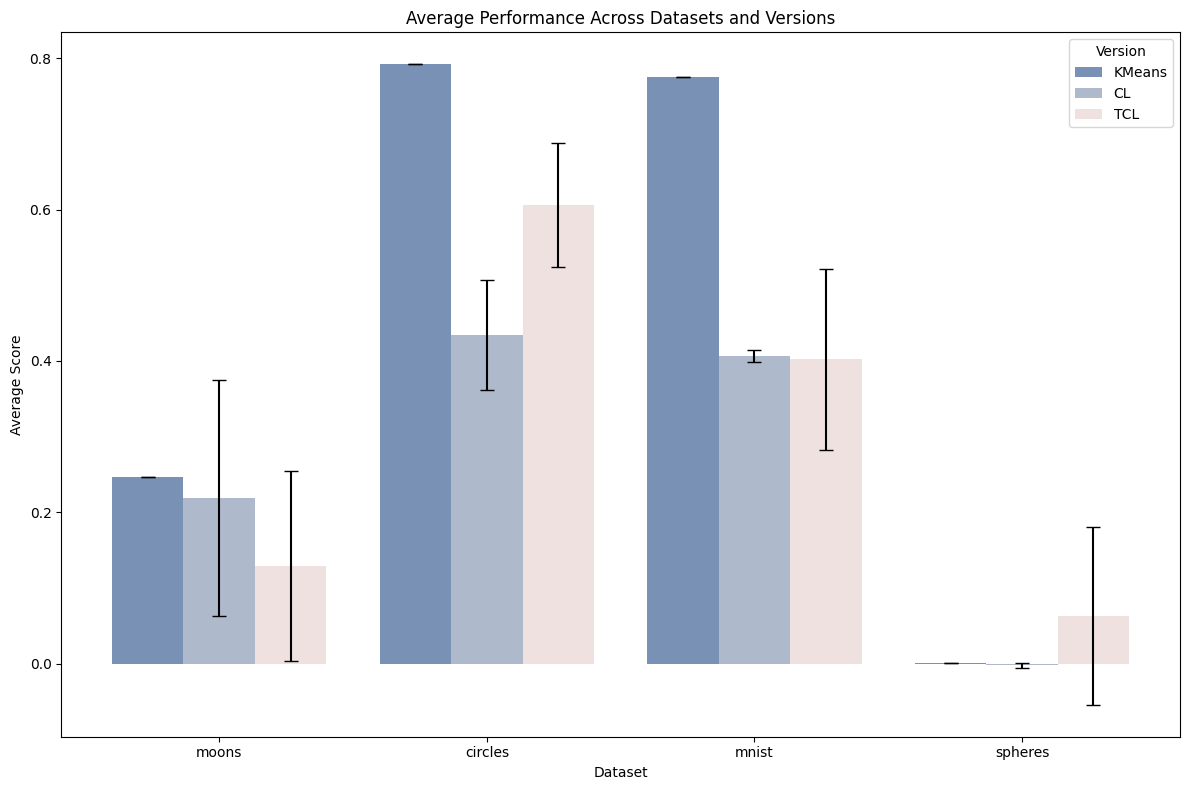

In [13]:
data_list = []
for dataset_name, versions in averages.items():
    i=0
    for version, avg_score in versions.items():
        std_score = std_devs[dataset_name][version]
        data_list.append({'Dataset': dataset_name, 'Version': versionss[i], 'Average Score': avg_score, 'Standard Deviation': std_score})
        i+=1

data_df = pd.DataFrame(data_list)

n_palette = sns.color_palette("vlag") # Example palette

# Skip a color, for example, the second color
n_palette = n_palette[:2]+n_palette[3:]
# Create the plot
plt.figure(figsize=(12, 8))
ax = sns.barplot(x='Dataset', y='Average Score', hue='Version', data=data_df, palette=n_palette)

# Calculate positions for error bars
n_bars = len(data_df['Version'].unique())
bar_width = 0.8
group_width = n_bars * bar_width
single_bar_width = bar_width / n_bars
offset = (np.arange(n_bars) - np.arange(n_bars).mean()) * single_bar_width

# Add error bars
for i, dataset in enumerate(data_df['Dataset'].unique()):
    for j, version in enumerate(data_df['Version'].unique()):
        subset = data_df[(data_df['Version'] == version) & (data_df['Dataset'] == dataset)]
        position = i + offset[j]
        plt.errorbar(x=position, y=subset['Average Score'], yerr=subset['Standard Deviation'], fmt='none', c='black', capsize=5)

plt.title('Average Performance Across Datasets and Versions')
plt.ylabel('Average Score')
plt.xlabel('Dataset')
plt.legend(title='Version')
plt.tight_layout()
plt.show()